卷积神经网络之卷积层
===

接下来我将会介绍卷积层、池化层、正则化层、Dropout层、激活层、全连接层、损失函数的前向算法、后向算法以及梯度计算，我们使用的是$224,224,3$的图片

# 1.卷积层的意义
卷积层只要是为了提取图片的特征，它传统神经网络的优势在于可以有效的减少计算量。卷积层的输入时上一层所输出的特征图。

# 2.卷积层的特点
- 局部连接：这个是最容易想到的，每个神经元不再和上一层的所有神经元相连，而只和一小部分神经元相连。这样就减少了很多参数。
- 权值共享：一组连接可以共享同一个权重，而不是每个连接有一个不同的权重，这样又减少了很多参数。
- 下采样：可以使用Pooling来减少每层的样本数，进一步减少参数数量，同时还可以提升模型的鲁棒性。

# 3.卷积层的关键参数
- 输入通道：即输入数据的神经元个数
- 输出通道：即输出数据的神经元个数
- 卷积核大小：即参与操作的卷积核的大小
- 步长：即没做完一步操作，需要跨几个像素去寻找下一个卷积核
- 是否需要扩充图片

# 4.卷积的效果图
我们可以先看一下用纯numpy实现的一个卷积层的效果

(1, 224, 224)


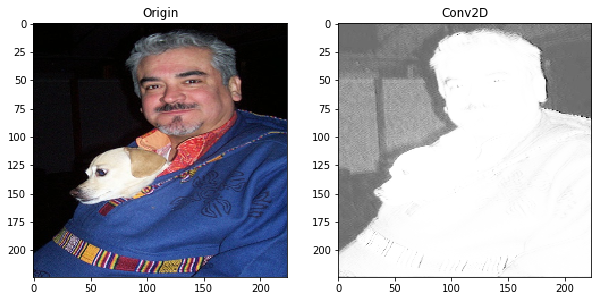

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision.models as models
import torch
from JLib.pyn.layers import Conv2D
from JLib.pyn.functions import preprocess_image

plt.figure(figsize=(10,10), facecolor='w')
imagePath = "data/ConvVisible01.jpg"

img = cv2.imread(imagePath)
basicImage = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
originImg = cv2.resize(basicImage, (224, 224))
plt.subplot(1, 2, 1)
plt.title('Origin')
plt.imshow(originImg)

convImage = np.expand_dims(originImg, axis=0)
conv = Conv2D(convImage.shape, 12, 3, 1, 'SAME')
convImage = conv.forward(convImage) # 这里使用的是初始化权重，还没有进行过迭代
convImage = convImage[:, :, :, 0]
print(convImage.shape)
feature = np.reshape(convImage, newshape=(convImage.shape[1], convImage.shape[2]))
feature = 1.0 / (1 + np.exp(-1 * feature))
feature = np.round(feature * 255)
plt.subplot(1, 2, 2)
plt.title('Conv2D')
plt.imshow(feature, cmap='gray')

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJ%0AChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/%0A2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo%0AKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAJ2BIEDASIAAhEBAxEB/8QA%0AHAABAQADAQEBAQAAAAAAAAAAAAYEBQcDAgEI/8QAYxAAAQQBAgIEBQsOCAoJ%0ABAIDAQACAwQFBhESIQcTMUEUFiJRYRUyN1Vxc3WUsrPTFyM0NUJSU1RWgZGV%0A0dIzNmKToaSxtAgkQ3KCg4WSlsElY2Z0oqW1wuImRKPUGEVYZPH/xAAWAQEB%0AAQAAAAAAAAAAAAAAAAAAAQL/xAAlEQEBAAAGAQMFAQAAAAAAAAAAAQIRMUFR%0A8CFhkcEycYGhseH/2gAMAwEAAhEDEQA/AP6pREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAWg6QpJIdA6llhe6OVmMsua9p2LSInEEHuK36nekf2PNU%0AfBVr5lyDXY3QOmpMdVfJjS57omOJNiXmSB/KWxx+itP4+7Dbp0OrsRO4mP6+%0AQ7H3C7ZbjE/aql7yz5IWUgIiICIiAiIgIiICIiAiIgIoHXuExmoNbaToZyhW%0Av0zFdk6mwwPZxBsWx2PeNz+lZD+ivQDGOc/SWDa1o3JNRgAH6EFsi5Tk9LdF%0A8GlrWdo6b0tbqQksbIWxRxPeHcJaJCCO3ly33PIblaHQ2itO6pw1LVFrT2j8%0AfgXiSQ1YsaZHuY0uaS6Z5bsN27/wYO3bt2IO6IuNYLou6LdeY6DUNHTobQmd%0AJFHC0OqtPVSPjLuFhB5lpPM9m24HMKop9D3R7UrmGLSWLczmd5YzK7/ecSf6%0AUF6ig29D/R8CCNJYrcc+cW6+L/Q10eXmtbNpPGtDezqGmE/pYRugv0XH7fRn%0A0aaRsw16+jfVO7kSeopNYbT9mDd7gZXbMaOIblzgNy0dpAUlJp3BVS04vSmm%0A85alty1G4S1im07zJGND3tMrXOj2axzXcRYAQ5uzjxBB/RqLkdPA9E0uMq3b%0AumsHQbLO+o8WabWCCww8Lonv24Wu35Dcji7t91Tjoq0C4AjSODIPMEVGfsQW%0AqKQ6I42Q9HeHiiaGRxtkYxo7GtErwAPQAq9AREQEREBERAREQEREBERAREQE%0AREBERAREQEREBERAREQEREBERARcu01oXSuob2pb+c0/jb9w5mywzWIGveWg%0AgAbnuC3n1KdBfkhhPijP2ILVFxbN6X0nQ6Q9Oafj6N8OzHZKaaKTITQQ8Lyy%0As+UCJrSXdrQCXAdhAB3BWJqHSGGwtG3nLmgtJV8PXtNgbSlrDwqaMyiMPDwe%0AAOdvu2PhO/IFwJ5B3RFFfUp0F+SGE+KM/Yn1KdBfkhhPijP2ILVFFfUp0F+S%0AGE+KM/Yn1KdBfkhhPijP2ILVFw6fRmGx4x2Ry+hNIVcfevw0m481v8bjE0oj%0AY7j3LHOHEHuYG8mh2zjw8/WxgNBu6TsdpelofAyVZIrBs2zUb5M0bY3dU3ls%0ASGyNLjz9cB27oO2Ior6lOgvyQwnxRn7Fo9T6E0rp+xp2/g9P4yhdbmajBPXr%0AtY8Av2I3HnCDqKIiAiIgIiICIiAiIgIiICIiAiIgIiICLX6izFPT2Bv5fJyd%0AXSpQPnlcNt+Fo32HnJ7AO8kBRD9U69finZ2toun6mdU6ZmMmyD2ZNzOI8JMY%0AiLGvLNndVxEg+TvxckHR0Wg0/q/B53GYO7SyNUDNQmalBJMwSy8Ld5GhoJ3c%0AzmHgb8JB3WBrzpD09orB5HJZS4yc0JIoZqdWWN1gPk2LG8DnDmW7v2JB4WuI%0A3AQVyLQ39ZaYx8cEl/UeFqssRMnhdPeiYJI378D2ku5tdwu2I5HY7di2MWWx%0A0raDor9R7cgN6ZbM0iyOAv3j5+X5ILuW/Ib9iDNRSmtOkHTmkMTlLuTyNeST%0AHGNs9OCeM2A+QFzGcDnDynNDnAHbcNJHYqapZguVYbVOaKetOxskUsTw5kjH%0ADcOaRyIIIIIQeqIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg%0AIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICnekf2PNUfBVr5lyolO9I/seao+%0ACrXzLkG4xP2qpe8s+SFlLFxP2qpe8s+SFlICIiAiIgIiICIiAiIgIiIIjWeQ%0Aq4rWmnMhkZmwU6tPITTSu7GMa2Ik/oW3zemqmortebLTT2cZGwFuMdsK8j9y%0AeOVu28nds1xLRtvtvzEr0nYyXL660JUZGJK/XzzWGkjbq43Qycwe0bsaCPMV%0A0pB8sjZHG2NjGtjaAGtA2AA7AAuO6Dx2Ty3RRpalTrxTY11ixJfa6yYXSMbY%0AkLYh5DgWud67s8lpHPi3HZFp7OqMFVw0eWs5ejFjJHmNlp8zWxOcCRsHE7E7%0Atd+goJ7oafO/RcnhELYSMrktg1/Fv/j05PcOw7j82/fsrla/CZvF56o61hch%0AVv1mvMZlrSiRocACRuO/mP0rYICIiCC6UekCro042jHJRGayZcyqb07Ya8LW%0A7cUkrydwweYc3HkPRGYKTC4DU2nM/JqajlKEwyEGTzfhEfUm/KIHgOIPCwFk%0AXC0dwa0d437DmszjcJWZYy92CnC94jY6Z4bxuIJDR5zsCdh5ivynfxmbxAt1%0ALFW9jZWn641zXxuAOx3PZyIO/uIJPoyZHkq+qchwtnxWVy00tYuAcyeEMZGX%0Agdha4sdse8c+9bunjMfozE5Kxj47vqfGw2BRicZWxBoJLYGH1oP3gO2/YBz3%0A3GNuVchj69vHTRT05mB8MsRBY9pHIgjuWSgj+iKWOfo7xEsLw+N7ZHNcOwgy%0Av2KsFB9B9SWj0cUIJDH1QnsuhDCeUbp3uAPLltuR7gCvEBERAREQEREBERAR%0AEQEREBERAREQEREBERAREQEREBERAREQEREEn0ees1J8N2v7QqxSfR56zUnw%0A3a/tCrEElqvEXr+tdEX6kHWVMbbsy2pONo6tr6ssbTsTud3OaOW/b5lJQ1NS%0AZrVxyusdL5WanSsn1KxsFmm6tEAfJsy7zAvm2325bMHYCea6tLPDFJDHLLGy%0ASZxbG1zgC8gEkNHedgTy7gVjnK48PLDfqB4OxaZm77+btQZiIiAvx5LWOIaX%0AEDcNG259HNfqIOTaapakymp4c7rfTWU8OZM5lGvHYqPp4uNx4esA67ifJw83%0AP2J5kNaO/wCqmgc7ita6PsVstJcxuPZddasSQRNfxymNzuLnu90rg8lwB2I3%0A5brpbMpj35F1Bl6q680burCZpkA235t33X03JUXZB1BtysbzW8bqwlb1gb5y%0A3ffbmOaDKUn0i/Y2A+G6XzirFJ9Iv2NgPhul84grEREBERAREQEREBERAREQ%0AEREBERAREQQ3TjgbepuifUmLxrS+5LXEkUYaXGQxvbJwADtc7g4R6SF4y9L+%0AiYMBLk7WcrVpYWOMuNne1l6ORpLXROrk8YkDgW7bbd++3NX6xHYyg7JtyTqV%0AU5FsfVNtGJvWhn3oftvtzPLfvQfznp7Gz6Jf0FT6odFja1VuXfbsWSYoqr7M%0ATpY4pXvDQyTZxbwnbymuA32Wq6RMpS1Hpnp3v4Kwy/SfYxAZNBu5r+r6pry0%0A97QWO8ociBuCRzX9SZGjUyVOSpkasFurJtxwzxiRjtiCN2nkdiAfzLIAAAAG%0AwHcg47e1Fpqh/hAR5LK5bE1q8+k4X07lieNkbw61Kd45Cdju0g8jzHnAUhpO%0A5BhL2CzGSu1a2lna1zLsdaM7fBY6r4J2R8DgeFjDIJNhyB3JHI7rs13RdTIa%0A4tZ7ImC5VsYqLGPx89cSMPBO6UPJJIPNw5cPLbfdUl6nWv1JKt6vDZrSjZ8M%0AzA9jx5i08ig/mXVNyrnT/hB28JZhyVWSninsmpvEzHNZCeMhzdwQ3hdv5uE7%0A9i/pfF5Kjl6EV7FXa16lLv1ditK2WN+xIOzmkg7EEe6CvatBDVrxV60UcMET%0ABHHHG0NaxoGwaAOQAHLZeiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIC%0AIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAp3pH9jzVHwVa+ZcqJ%0ATvSP7HmqPgq18y5BuMT9qqXvLPkhZSxcT9qqXvLPkhZSAiIgIiICIiAiIgIi%0AICIiCP1NGZdf6WjbI+Jz6uQaJGbcTN2xcxuCNx6QV7abzWQr3mYDVEZGVa0m%0Avejj2gyDGj17duTJAPXRn0lu7ezx1LNFB0h6SfNIyNnUXhxPcAOyLzqm9UqP%0A47W/nW/tQfmVxtTLUZKeRhE9WTbjjJIDtjvsdjzHo7D3rkOg8O/J9Fmg6+Py%0AlLF2auRnsQCeISdbwm03hYzibu5odxjtA4NyCNwrfIwZGtenuaf1VVIldxuo%0AZPhmg37+B7S2SP8AS5o7mrGykWnqOjqFXIYyKSGvI2UVsRK6R1WY8RdJE5vB%0AINi53lNAd5XYNyg2Oispkp72dw+amht2sTPHGLkMXVNmZJG2RvE3chrxvsdj%0At2HlvsKpRGitQ6Mia7HYCwKssr3TyRW4poZpXnbie8zAPe7s3cSSqKTUmCjs%0AOgkzWMbO07GN1qMOB237N9+xBtUWCMvjTF1oyFMx9vGJ27fp3WIdV6eE7ITn%0AsT1z39W1nhkfE533oG/M+hBq9c5bB4C1icnk6st3M8UlTFVoGmSaWSQNLmxt%0A34QdmDd7tuEbjcBxBiZIMli6Tcfn6WRj8Y702Vy3qVSmtx149o2ioHRMd5Tw%0A1oc7YAgSkbcQVTrTK6LjyNObOl1rIwxP8G8DinnlaxxAcB1IJG5A39z0LYaV%0Ay+NkxVk46vPjm8bjGzJShpkdwjyti9zg3sHMA8jyQa3oJtMtdEelurZM3qqE%0AUTuthfHuQwblvEBxN8zhuD3FbXVN3LWrQwWnoZoLU8YfPlHx/WacRJBLSeUk%0Ap2PC0bgdrthsHafBYDqIaEWU1JBHSpcHg+MxDvBK0YbsWgu4jI8DYci4NPe3%0AuVr6pUfx2t/Ot/agmeiKMRdHeHjDnuDGyNBe4ucdpX8yT2n0qwUl0TkHQGKI%0AIIPWkEe+vVagIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAi%0AIgk+jz1mpPhu1/aFWKL0FcqwHUjJrMMb/Vu0eF7wD2hVXqlR/Ha38639qDnW%0AscNWr9MWgMq2S2+1ZuW4y2S1I+JjRRl5MjJ4Gb7AnYAkr915p/C5fVWntOQY%0AemyWzOcresRVmBzYIHNds47b/XJTG33ONWl6HB38ljb9uatJbxsj5asnhG3V%0Auex0bjsDsd2ucOe/b51+wxYOHNWcsyat6o2YY68kzp+ImNhcWtAJ2aN3uOw2%0A3J3O6DcosX1So/jtb+db+1PVKj+O1v51v7UGUixfVKj+O1v51v7V+OyFBzS0%0A3a+xG3KYA/p3Qctlp4u7l8ZpvRdCK0/FZGO5k8y5vEa745BI9nXbbvnkPkOA%0APJrn8W3YtBpF1ijpPSuosxUxdypbycb5ZYOsZeZamnLOtMwcA4Bzgx0Rb63c%0AEuA2PTNP6Y0pp6vBXw1iarXhkMrIWZecs4i7iJLTKQ7c8zuDv3ryh0rpiLMM%0Aui450Ec5txY91zepFY4uLrmxb7B+5J8wJJA35oLVSfSL9jYD4bpfOKi9UqP4%0A7W/nW/tUrr+5Vmi0+yGzDI/1bp+SyQE/wiC0REQEREBERAREQEREBERAREQE%0AREBERBxOrlcjidYay1Nn8U+axVuQ4yhWr5uWQGaSCsIq8cLmMj2eZuMvPNpc%0A7kdi42dfWmUoalp4jVuAjxwv1pJqVmhaffZLJG0vkgIELHNkDAXDkQ4AhpJG%0AywNY6CuZ/Datrs9TnWb2XrZWgLjHSwEwwVWcEzB2tcYJGkc/JdvsTyWrxWjs%0AjcsXTS0TpXREjKtqtFkarI57nXvj4I5YHxNZ1cY4nElx43chwt7UGzg6QNQV%0Aq2nr2odIMxmOzF6Gk1nqlx3KxmcWxOlhMTWgE8HEA8uaHcxuCFgT6/1JgsTr%0A/L6gwtKStg7LGw14MhxEE16zuqDupbuPrpfxnc7uLdtmgqUwvR3np4dM15tE%0AYHFZDD5WpbyGemuMntZIRS8UskbmsL95COM9Y4bb8O3eLTV+i87nsd0g4WJu%0APho6g4bVS66w8vZM2vWiEUkXV8mkwOPGHHYEeSUFLqLV3qNrvSOm/Aeu9X/D%0AP8Y63h6jqIhJ63hPFxb7do29Kl9PdKlzK6Fj1VNpxtelYcatOu3ICSxbtmx1%0AMcbG8AHA49r3ODgQ7yC0B58IcVrDVXSHorUuc0/UwFTAm62Wu/ItszSmaAMD%0Am8DeHh3A7Xb9u4HLfwx3Rhkm9BVHSNs4t+apWDchM7XTVHSNtuma2QbAuY5p%0A4HDY+uPI7IKvH6uy0GrcdgtVYGDGOycD30bVS663FLKwFz4HExMLHhgLwSOE%0AgHYkjZYGi9f5bVlbH5TG6dpz4G5YMTpa2YjmtVGcy188PCGNO3AXMbK57ePs%0AJBCw9JaZusz4uw6A0fpIVGTxssxwx2bEspaGsfEYmx8EWxfvxEPcPJ4Wb7qd%0A8Sc9ktdYXJP0ditO5inais5HUOMyJbDeYHh80bYW8L3GUkgmVvIcQLnciQ7k%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAp3pH9jzVHwVa+ZcqJTvSP7HmqPgq18y5BuMT9qqX%0AvLPkhZSxcT9qqXvLPkhZSAiIgIiICIiAiIgIiICIiDByuHxmXZGzLY6neZGS%0AWNswNlDSe0jiB2X8u9MfSli9H6jv6fxfRpgoLlZ2wtZGnE5sjT2PYxgG7SOY%0APF7oB3C/pTU+oo8K2CvXrvv5i3uKlCEgPlI7XE9jI27jieeQ3HaSAeaa/wCh%0AGPX9Srd1Hln+MYnY6WzACIY6/F5VeJh7GgEkOO7i7meR2AQH+DtpG9r/ACMm%0AstZU6PqRAXRUKUNKKCGeTsc9zGNAc1vYOLfd3f5K/obxK0r+TOE+IRfura4f%0AG08Pi6uOxldlelVjbFDEwcmtA2AWWgn/ABK0r+TOE+IRfurzk0Fo+UkyaU0+%0A8nvdjoT/AO1Uiw8zamo4i9aq1pLdiCB8kVeMeVK8NJDB6Sdh+dBwHC5HSV7/%0AAAjspo6PTmB9SI8f4NHCMfDwOtR/XHnbh7eFz2n/ADF2aPQWj4yDHpTT7SPv%0AcdCP/av4t0hpfpCw3SrUztrTuUmyNS3FkbzWRcUhjlkeHO2bz8rhlHLzFf3s%0Agn/ErSv5M4T4hF+6niVpX8mcJ8Qi/dVAiD+dP8IDJYPo21Xoa/DpnDzYyx4Z%0AHfqijF9djBg2cPJ2427kg+kjsJXXcFgNEZ7D1MpicDgbNG3GJYpWUItnA/6P%0AIjsI7iCFyX/C40bntYSaPh03jLOQsRPtNe2JvksDhDsXPOzWjye8hbT/AAVN%0AJ6i01pe27LZSvJjbEsgjxrWuc+rOx5ZJu47Bp3aQWgEbgHft3Dt1OrXpVo61%0AOCKvXjHCyKJgYxo8wA5BeyIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIi%0AAiIgIiICIiAiL4nmjrwSTTyMihjaXve9wa1rQNyST2AINJlNK4K26zak07hr%0Al94L+KxVj3kfty4n8JPPlz2PuFfxbrnpWzBy1zEVNGaWwNmCZ1d8ceKinnY8%0AHhLeJ7S0nfzNX9e+F5LWWzcXJPi9Nu9deG7LN1vmhHbHGfwh8oj1oHJ618XQ%0A/pCDXWO1RWx0cNmjB1UddgHVGQHyZnDtMgG/M778j2gFBL9CHRLFi8C7K66o%0A1b+fyID317EDHR02doY1m3CHd7iB6O7n0vxK0r+TOE+IRfuqgRBP+JWlfyZw%0AnxCL91c/6do9LaI6M8rkoNPYOPITN8Ep/wCIxA9c/cBw8ntaOJ/+iuwL+Yf8%0AL3C6v1DcxrMZiJ5dOY6LrH2GyM2fPI4N9bxcXIcIHLtcUHU+inE6W1R0cadz%0AD9OYR8tmmzrnGjEd5W+Q/wC5++a5VfiVpX8mcJ8Qi/dXN/8ABXxuocBoW7hN%0AUYq3j5KtsyV+vbsHRyAEgHsOzg4n/OC7Qgn/ABK0r+TOE+IRfup4laV/JnCf%0AEIv3VQIgnn6I0o9padM4TYjY7UYh/wC1fzNobpHxXRzrq9pTXeCx0jMZcdBW%0AzUVKPwiJod5DpCG7uBbwniHlc+fF3f10v5w6bugrKa86VIMpiZ69PH2qjfDr%0AUvlFkrPJGzAd3Et4B3DyTuexB/Q2Mv1MpQgvY2zDapztD4poXhzHtPeCO1ZK%0A5z0I4rEaY05LpujUkoZai8HIV5pTI98jhsJmu5B0bwPJIAHIggODgOjICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICnek%0Af2PNUfBVr5lyolO9I/seao+CrXzLkG4xP2qpe8s+SFlLFxP2qpe8s+SFlICI%0AiAiIgIiICIiAiIgLRaoz/qSyCrSg8NzVwltOmHcPGR2vefuI27gud3bgDdxA%0APrqjOR4Ogx7YXW71h4gp04zs+xMQSGjzDYEuceTWgk9ix9LYGTGmfIZWZtzP%0AXQDasgbNaB62GIH1sTdzsO0ndx3JKD70xp8Ynr7l6bw7N3NjbuubsX7djGDn%0AwRt3Ia0ekndxJO9REBERAREQSeI59KOp3ebF41n6JLh/9yrFJ4T2TNVf9xx4%0A/psqsQEREBRuG/6D6Qstiz5NTMx+qtUdwmbwx2Gj/wDC/wB17yrJSfSRWmjw%0A9fOUY3SX8FML7GMHlSxAFs0Y8/FE54A++DT3IKxF5U7MNypBaqyNlrzsbJHI%0A07hzXDcEeggr1QEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBEW%0AJlsjUxGOsX8lYZXpwN45JXnk0f8AM9wA5knYIGWyVPEY6e/k7EdanA3iklee%0AQH/Mk7AAcySAFMV8dc1fLHc1DXkq4Njg+tiZRs+Yg7iSyP0FsXYO127tgxic%0Abb1Lkq+d1FXfXqQO6zGYqUc4T3TzDvlI7G9kYP325FkgIiICIiApLpT/AIlz%0AjuNumD7nhUSrVJdK3LQWTk/BGGb3OCZjv+SCtREQEREBERBO6s09JlDXyOJn%0AZS1BR3NS04btcD66GUD10TthuO0HZw5gL20pqGPO1ZmTQPpZWm8Q3qMh3fXk%0A237fumOHNrxycPzgbxTOq8DZsWoM3gHRw6gpsLGF52jtxb7mvLt9yTzDu1ju%0AY3HECFMi1Omc7W1BjBarNkhlY8w2K0w2lrTN9dG8dzh+gggjcEFbZAREQERE%0ABERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQERE%0ABERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBTvSP7HmqP%0Agq18y5USnekf2PNUfBVr5lyDcYn7VUveWfJCyli4n7VUveWfJCykBERAREQE%0AREBERAWDnMtUwmKsZDIyFleEAnhaXOcSdmta0c3OcSAAOZJACziQ0EkgAcyS%0AovDg6wzUWdnBOBovPqVGeyzJsQbZHe3YlsfoLn/dN2DL0tirk96TUWoowzLW%0AGGOvV3Dm4+uSD1QPYXnYF7h2kADk0KpREBERAREQEREEnhOXSXqof/6OPP8A%0ATZ/YqxSeI5dKOp2+fF41/wD+S4P/AGqsQEREBDzGx7ERBGdHzvUixldJy+T6%0AlSCWkD91SlJdFt6GEPi9yMedWajOkAHDWsZq6EEDFuMN/b7qjIQJCfe3Bkvu%0AMd51ZghwBBBB5ghAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQf%0AFiaKtBJPYkZFDE0vfI9wa1rQNyST2ADvUVho5Na5Kvnr0b2YCq/rMTUkbsbD%0Ah2W5Gn/8bT2DyzzLeH4vjx7zsuNb5WlcZNw3Xd2QstP8APPEw83/AHzgGdge%0AFdgbDYcggIiICIiAiIgKW6VYnTdGeq2x/wAIMXZcz/OETiP6QFUrX6iq+G6f%0AydXbfr6ssW3+cwj/AJoMyvK2evFMz1kjQ8e4RuvRaLQdrw3Q2nbW+/X46tLv%0A5+KJp/5reoCIiAiIgIiIJHU2Lt43KeM+nYXS3WtDMhRZ/wDfwN7Nh2dcwblh%0A7xuw8iC2kxORq5bG1r+OmbPUsMEkcje8H0doPcQeYPIrKUbZ/wDo7Pm2PJ07%0AlpwLDfuaVt52EnojkJAd5nkO+7cQFkiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICnekf2PNUfBVr5lyolO9I/seao+CrXzLkG%0A4xP2qpe8s+SFlLFxP2qpe8s+SFlICIiAiIgIiICItFq/NS4mjDDjo2T5m/J4%0ANQgdvs6QgkvdtzDGAF7j5hsOZAIavUbn6ozEmmKr3NxsLWvzMzDtu1w3bVaR%0A3vHN/eGbD7sEV8UbIo2RxMayNgDWtaNg0DsAC1mmMLFgcRHTjlfYmLnS2LMg%0A8uxM47vkd6Se7sA2A5ALaoCIiAiIgIiICIiCTp+R0r5j/rcJS/8ADPa/fVYp%0AN31vpXj/AOvwjvz8E7fpP6VWICIiAiIg87EEVmvLBYjbJDK0sexw3DmkbEEe%0AYhSXR5PLjxe0pekc+1hS1teR53dPSfv1D9+8gB0bj99GT3qxUZ0gQy4uahq6%0AjG582J4m3Yoxu6ei/brQB3uYQ2Ro/kED1yCzRedeeKzXinryMlhlaHsew7tc%0A0jcEHvBC9EBERAREQEREBERAREQEREBERAREQEREBERAREQFJa0ydue1W0zg%0AZjFl8gwvlst7aNUHZ83+cfWsHe479jXLc6mzdbT2EsZK2HvbGA2OGMbyTSOI%0AayNg73OcQ0Dzla/RGEs42rZyGZLJM/lHixeew7tYdtmQsP3kbfJHnPE7tcUG%0A4w2Mp4XFVcbjYWwU60YjijHcB5z3k9pJ5kkkrMREBERAREQEREBERBJdEvk9%0AGunYvwFNlf8Am/I/9qrVJdFnLRzY/wADfvw/7lyZv/JVqAiIgIiICIiAsfI0%0Aq2Sx9mjfhZPUsxuilieOT2OGxB/MVkIgl9F3bNeS3pzLTPmyOLDTHPIfKtVX%0AbiKU+d3kljv5TCeQcFUKT15G7HNp6orA9dhy51kNHOWk7br2+nhAEgH30YHe%0AVVse2RjXscHMcNw4HcEedB+oiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICnekf2PNUfBVr5lyolO9I/seao+CrXzLkG4xP2qpe8s+%0ASFlLFxP2qpe8s+SFlICIiAiIgIiIPieWOvDJNPI2OKNpe97zsGtA3JJ7gpPR%0AkMuavz6tvscw24+pxkLxsYKe+4cR3PlID3d4AjaebSvnVI8ZM5DpaM70GMbb%0Ay5HY6Hc9XX/1jmkuH3jHA+vCsQNhsOxAREQEREBERAREQEREEll/rXSfpmXs%0AEuNyFc+k8dV4+Q5VqktY/WNUaJtd3qlLWcfM19Scj/xMYPzqtQEREBERAQgE%0AEEbg9oKIgitGb6bzNrSE5LajWuuYZx7DWJ8uAemJxAA+8fH5irVT2tsJNmMX%0AHLjJGQZqhILePnd2NlAI4XfyHtLmOH3rj3gLK0pnYNRYODIQRvhe4ujnryev%0ArzNPDJE/+U1wI/Nv2FBt0REBERAREQEREBERAREQEREBERAREQEREBEUnrS5%0AYu2K2mMTM+G9kWl9mxGdnVKgOz5Ae57t+BnpJdz4CgxMWPHDVXqzJ5WCw8r4%0Acc37mxZG7JbHpa3yo2enrHd7SrdY+PpVsdQr0qMLIKleNsUUTBs1jGjYAe4A%0AshAREQEREBERAREQEREEl0ZcsFkR3DN5Xb49Of8Amq1SXRh5WmrUvdLl8pIP%0AcN+cj+jZVqAiIgIiICIiAiIg+ZGNkjcyRoexwLXNcNwQe4qW6N3ur4a1hZXO%0AdLhLcmPBcdz1I2fBv5z1L4tz3ndVaksb/inSfnIOyO9jatto872Pljef93qf%0A0IK1ERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQ%0AEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAU70%0Aj+x5qj4KtfMuVEp3pH9jzVHwVa+Zcg3GJ+1VL3lnyQspYuJ+1VL3lnyQspAR%0AEQEREBa7UeXgwOFtZK01744G+THGN3yvJDWRtHe5zi1oHnIWdNNFAzjnkZG3%0Afbd7gB/So6SzBqfXkNSGaOXHYACzKGuBElt7do2+kRscXn+VJGe1qDbaMxE+%0ALxT5ckWPzF+Q278jTuDK4AcLT96xoaxv8lg791vkRAREQEREBERAREQEREEl%0A0m/WcHj7w/8AsctRnJ8zDYYx5/3HuVap3pGoSZPQWoakG/hElCbqdu0SBhLD%0A/vALbYa9HlMRRyEJBitwRzs28zmhw/tQZiIiAiIgIi+ZZGQxl8r2sYO1zjsB%0A+dB9KF1ADo3UTtSQ+Tg8g5kWZjHZA/k2O2B3AcmSfyeF33B3sPVKj+O1v51v%0A7V52LeMs15YLFinLDK0skjfI0tc0jYgg9oIQZwO43HMIoLS2Tg0xlG6Xu3op%0Acc5pdh7b5g762OZrPdv69g9aT65nnLHFWfqlR/Ha38639qDKRYvqlR/Ha386%0A39qeqVH8drfzrf2oMpFi+qVH8drfzrf2p6pUfx2t/Ot/agykWL6pUfx2t/Ot%0A/anqlR/Ha38639qDKRYvqlR/Ha38639q94ZY52ccMjJGdnExwIQfaIiAiIgg%0AoM1rPLX8r6h1NPNo07slNhuTTCRxZtuSGtI57rI6zpG/F9I/GLP7iyejz1mp%0APhu1/aFWIIrrOkb8X0j8Ys/uJ1nSN+L6R+MWf3F59NEOQd0c6gs47L2sb4Lj%0AbU7/AAZreOUtjLmjjIJaNxz4djseRB5q5QRXWdI34vpH4xZ/cTrOkb8X0j8Y%0As/uK1RBFdZ0jfi+kfjFn9xafB4fpDxt3J3pW6Us38jMJJpnz2BwsaNo4mjg5%0AMaN9h53OPa4rpqIIrrOkb8X0j8Ys/uJ1nSN+L6R+MWf3F69K+RtY/R7m0Zn1%0A57tyrQ6+M7PibNOyN7mkdjuFztj3HY9ywcBSbpzpLlw+OntHFXMQLfg89iSY%0ARSxyhhc0vcSOJrxuO8t35klBk9Z0jfi+kfjFn9xY9nNa0xFzFuzdTTrqNq7D%0ATeak8xkb1juEEBzQOSvVJ9Iv2NgPhul84grFFZXNaosasyGJ03Vwpho14JZJ%0AL8srXOdKZNgAxp5Dq+/zq1Ulg/ZK1X/3PH/22EGP1nSN+L6R+MWf3Fg5jNa2%0AwtTwrLSaKqVy8Rh81qw0Fx7GjyOZPmC6GpPXuSwGCOLzGbry2shBK6LGV4Gu%0Akmmne0jgijB2c8gEbns3PMboNTiMxrfM0WXMU/RVyq4lolhtWHN3B2I5M7Qe%0A5ZvWdI34vpH4xZ/cXv0d4jI0oMvlM3FHVyOaueHSU4ncTaw6tjGsLuxz+Fg4%0AnDkSTtyAVcgius6RvxfSPxiz+4nWdI34vpH4xZ/cVqiDm2mMX0h4HCwY+Nmk%0A5hG6R5kdPYBc573PP3HncVtOs6RvxfSPxiz+4rVEEEzI68fkJaLBo11yKNss%0AkItWONrHEhriODkCWu29wrI6zpG/F9I/GLP7iw9N4mjiOl/UEWOrMgbNhaM0%0AnDuTI82LYLnE8ydgBue4AdgC6Cg5zqPN6/0/gMjmLlLS0tahXfZkZFYscbms%0AaXEN3ZtvsO9dGUl0uexbq34Ks/NuVagk9WZnO1tRYjDabr4ySxcq2rUkl+SR%0ArWthdA3YcAJJJn/oWN1nSN+L6R+MWf3Fk5T2VdN/A+T+eoqsQRXWdI34vpH4%0AxZ/cWNTyWu7slplTxNmfVl6icMtWD1cnC13C7yOR2c07ekK6swR2a0sEwLop%0AWFjwCRuCNjzHMKF6KKFTGXdc08fXjr1Ys+7gjjbsBvTqk/nJJJPeSSgyes6R%0AvxfSPxiz+4tW/F9ITtTw5nq9JiSOm+mY+vsbEOex+/rO0cP9K6SiCK6zpG/F%0A9I/GLP7idZ0jfi+kfjFn9xWqIIrrOkb8X0j8Ys/uLSWNX6nrZgYqxf0JHkS9%0AsXUOuzh3G4btb6z1x3Gw7TuuoLk+Zip599zRGi6Y8FF4WM1knEujrSGUSva1%0AziS+dxHdyZuNyNgEFH1nSN+L6R+MWf3E6zpG/F9I/GLP7itUQabReYk1BpLD%0A5eeFkMt2rHO+NhJa1zmgkAnu3W5Ul0Sexjpf4Ph+SFWoCIiAvC9cq0Kr7N+z%0ADWrs24pZnhjG7nYbk8hzIC91zHAYOlrDXur8rqaCDKRYu43E46lcibLFTY2C%0AKSV7WnlxSOkG7iOIBgG+3JB0uvNFZgjnryMlhkaHskY4Oa5p5ggjkQV9rm2p%0AocT0SYHVercTB4PRfXje7FQN4a5tb9WyRrRyYXl0bXloG4YCdyOfjNndXaPy%0A+mnazyeFyGPzt1mNkjpU5IXUrUjHOiEbi53WxlzXMJcGkeSfOEHT0XAoOkrW%0AreiaPpJvy4NuOrz8MmJr05OKzF4UICeudL9bd64gBrhyBO+/CL7K6+kwWR13%0ADmakEUOCoxZSievax12B8TgRsSdnCaN7N9vumDbvcF+i5ZR1Fq7VOaOBxlzF%0AYLJYjG07GcklpvtOZcsMLhXjZxtbwNa1zi/jd2tA7HFaaPVdrVUOkPVWGCLL%0A4nWsmJvisHdQ6aKtZ3dFxEu4C1zT5XPfcd26DtiLnWptcZLF9FGotT14Kbr+%0AOtXYIo3scYnNhuyQN4gHAklrATsRz37ByWBk7mep6s6QZLt3G3sbUwMVllCS%0AlJwFpNwsad5iN9mbPPD5Y4dgzh5h1RFybT+e1NqSrp3F6XOHwMDdO0sncsCk%0AZo4nTgiKCGHrG8LAIpeZLtgGjl34Wc6RNXYvDUqslLDx6jOrItNzSSxvdWfH%0ALH1kc7GNk4m7sfEdi4keVuB2AOzIoLSeZz1XXt/SmpL1PKSMxsWUguVqZq8L%0AXSvjdG5nG8HmwEEEdp37leoCIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg%0AIiICIiAiIgIiICIiAiIg5f06aZxsuitSai3vx5epj5HwzQZCxE1ha0lp6trw%0Aw/nHPvXzejxfRZoCzqnE467etGGqySCfKTydaZJY2cutc8NO79+QHZtyVh0j%0AYWzqPQmew1F0TLV6nJBE6UkNDnDYbkA8lq+kXS17UfRpLp+i+Bt13gmzpXEM%0A+tTRPdzAJ7GHbl5kHxmc9qzHQVo34vCRSzOkfLdnvllSnG3bha4loc97tyOQ%0AAG2+/ctPU6Vt9O5CeahVs5irlYcNHDSt9ZXtzy8HA5kvDuGkP3PIkcJHNZXS%0ADpTJ5HWeJz1TF4zUFWpVkr+peTnMMcMhcHCww8DwXbDhO7ewDYqer9Geedic%0A1NKcLTy785WzuPhqB/gzHwsYBG7kCAeFwLgO/i27kHtYyeooekmzFqitUZFD%0ApS7OGY65J1U+00O/JzQWPHMcXPkdx3hfGltSZ21rTQNSjBDBp69poWxXlvvl%0Afw8MPlPJj3c9vFwjd3lAlxLTyW28XdV5zU1vM5uriceyTA2sTDVr2nzubJI+%0ANwe55Y0EHgPIDly7d+XzidF5/D5Po+uVTjp/UfDNw+QZJK9uwIhDpIiGni26%0At2wPD3fmDD05riZmk9L09M4frMpm7l+KvBdvPkZAyGaXrZpJS0uLQQNm7fdh%0AoPYsjNdJ+S0zitRs1Bg67s5hxVmbBVtERXYLE4ibJG5zd27EkEEHm3bfnusT%0AGaA1HgcHpK1in46xnMDayDn1ppXMhswWpXvczjDSWuG8ZB223ae0dvxqTQOp%0AtW43U17MNxdPM5JtGrTrRTvkjrVq9kTODpOEcTnEuPJu3JvnKCrxmqc5X1fR%0Awmp8VRrHKVZrVJ9Oy6UsMRZxxSbtA4tpGniHI81oL/STm8M+jaz2NwtSvatx%0AVnYxuR48hA2STq2yOaBwu57EtHYD28lUap01dy2s9P5WrYZXgoU79eR4P1xr%0Ap2xBjmDbY7cBPM+Zcyg6MtR+K+KwEen9K0nUrVaezl2WHvsXTFI1zn7dUC17%0Ag3c7ud5uQ22DoXRrYmnzuvmzTSSNizpZGHuJDG+DQHYb9g3JO3pW46R/Y81R%0A8FWvmXLx0ZgLWFymq7Np8TmZXKG7AIySQzqYmbO5cjuw+fuXt0j+x5qj4Ktf%0AMuQbjE/aql7yz5IUZfxFbPdJ2UrZOS6+vWw9KSKKG7NA1rnzWw520bm7khjB%0AufvQrPE/aql7yz5IUgzJ1afTPepzyEWb2HoxwMDS7iLZLz3E7dgAb2nluQO0%0AhB85zTejcFUFnL2blSJzgxnWZe3vI49jWN6zdzj3AAkrV630tBicYyzhMdbs%0ADn1r5cnkZHx9gaGwxFzpCSewlgG25KssbpfH08xPlputvZWVzuG3ccJHwsJ/%0Ag4uQEbB2bNA323cXHmt6g4/0SaXqaj0nBnsvZyUzr5cY67blmBtcMe9mwHXO%0Adudtzu47bADvJo7HRHo+0P8AHaWQtnvNjLW5N/zGXZZHQzStY/o2xNW/Wnq2%0AWGfjimjLHt3nkI3B5jcEH86tUERc6K9IXa0Va7jbFivCQY4pshZe1hA2BAMm%0Aw5Ej868sd0R6Jxsxmx2IkqTO3BfBesMcd+3mJN1eIggpuiLRU1t9qTFWTZed%0A3TDJWg9x85cJN+4L2u9GeElxklSjZzVGQjaOxFlbMj4+e/ISPcD5uY7OzbkV%0Abog4XpTEmzr2xp2wy5epV6/hEl2xPkMfKW8TmeQ0yuEvlAcwGN232377F+G0%0AVHqH1EsT5Gvk3AOihnydyPrwRv8AWnOkDZNu8NJI2O+y2zalj6rMtzwebwQ4%0ARkQn4DwcfXuPDxdm+3Pbt2VBmcTQzdCSllqkNuq/mY5W7jcdhHmI7iOY7kEP%0ArjRmHx+i8/dpnJxWq2PsTRSDK2iWPbG4tPOTuICvMY5z8bUe9xc50LCSTuSe%0AEKK6S7lPS/RpkMfO+4+CxRs0orEzzNwvMEhYJHuPF5RHCCd93Fo33IVpiftV%0AS95Z8kIJPWlKPK6y0vjrcloU5YrkkkcFmSDjc1sfCSWOBO25/SszxAwH4PJf%0Ara39KvjP+yNpL/u9/wDsiVagkLWh9O1q008seWMcTC9wjyVx7tgNzs1shLj6%0AACT3Kf0Ri9N6sjzEkOMztJuPvuo8NvJ3I5H7RRycZYZAWg9ZyB57DflvsOnq%0AR0HUs1cvrZ9mvNCyxnDNC6RhaJWeCVm8Td+0btcNxy3BHcg9PEDAfg8l+trf%0A0qeIGA/B5L9bW/pVVIglfEDAfg8l+trf0q8q3RzpqrWir1q1+GCJoZHHHlLT%0AWsaBsAAJOQA7lXoglfEDAfg8l+trf0qmL1DS9bWmM023HahfYuGQOsuv3Y4I%0A+CIybB7pNnuOw5N3A57kEbHqKktUVLE2udFzw15pIK81szSMYS2MGu4AuPYN%0AzyG/eg+/EDAfg8l+trf0qeIGA/B5L9bW/pVVIgleiySSXQWKdNLLM8Nkbxyv%0AL3ECRwG7iSTyAHNY/ShWguY3CV7cMU9eXM02yRSsDmvHWdhB5EL16Kf4g4v/%0AAFvzr1+9Iv2NgPhul84gzPErSv5M4T4hF+6vC/pTSFGjYt2NN4QQ143SvIoR%0AcmtG5+58wVOsXK02ZHF3KMpLY7ML4XEdoDmkH+1ByLEVqLfFHIZrTGlXY3U0%0AjYooIcVG2Sm98L5owXkkSbhhB8luxO/oXR/ErSv5M4T4hF+6o3D4LPXmaJw+%0AUxbqVfS8rJ57rpY3R23RQPhjEIa4u2PHxHjDdttua6kgn/ErSv5M4T4hF+6n%0AiVpX8mcJ8Qi/dVAiCf8AErSv5M4T4hF+6niVpX8mcJ8Qi/dVAiDmXSJi8Vp7%0AFxWcVojAWGmeCOaxNVhayJr5mRnyQOJzvL5DkO8nlsa3xK0r+TOE+IRfur56%0AQMXazOlpqVBjX2HWK0gDnBo2ZPG93M/yWlUSCf8AErSv5M4T4hF+6tZ0b1K1%0ACzq+rRrw1q0eacGRQsDGNHg1c8gOQ5kqzUnoT7aaz+G3f3augrEREBERBJ9H%0AnrNSfDdr+0KsUn0ees1J8N2v7QqxBrdTYiLUGnMph7Ej4ochVlqvfHtxNa9p%0AaSN+W/NbJSGXuZfKawlwWIyDMZDTox3bNgQNlle6V72xsAdu0M+tSF3Lf1ux%0AHNbHQ2Znz2mKt66yFlzjlr2GwgiPropXxScO/Ph4mO237tkG+REQEREGr1Ph%0Aa+ocHaxlp8kbJg0tljOz4pGuD2SN7t2va1w35bjnuFg4HTtinm7WZy+S9UMl%0ANAyo1zIepiiia5ztms4nc3F27iTz2GwA5Le2nTMqzOqxslsNYTHG9/A1ztuQ%0ALtjsCe/Y7eYqR6N83msy/UbNRMqRWqOSNZkVQl0cbBFG4AOIBcfKJJIHMnYA%0AbBBZqT6RfsbAfDdL5xVik+kX7GwHw3S+cQViksH7JWq/+54/+2wq1SWD9krV%0Af/c8f/bYQVq0modK4XUVinPmaLbM9Pi8Hk43MdHxAB2xaR2gbLdrS6jtZqN9%0AOtp+nXklsPIlt2iTDVYBvxOYCHPJ7AAR27k8uYZOEwlDBwSQ4yF0McjuNwdK%0A9+5227XErYqa0XnrWXlzNLIx1xdxNsVJZqu/UzExsfu0HctPl7FpJ2I7SqVA%0AREQEREGKzH1WZSXItgaLssLK75u90bHOc1vuAvefzrKUhpzVOQyutcvhr2Gl%0AxkFSnBahM8jHyzCR8rC4hjnNaN4jsN9+87b7KvQSXS57Furfgqz825Vqkulz%0A2LdW/BVn5tyrUEnlPZV038D5P56iqxSeU9lXTfwPk/nqKrEBYtLH1KMtySpA%0AyKS5N4ROW/5SThaziPp4WNH5lj6it3qOJlmxND1QvbtZFAZBG0lzgOJzj2Nb%0AvxHbc7A7AlaPBZzLM1fLpzPHG2LPgIvsnotfGGt6zgLXxuc4jcncO4uezuQ2%0A5hXIiICIiApOv0eaWrPLq2L6kmQykR2JWgvJ3J2DttyearFzyxrbJxUb2onV%0AqLNL07z6UjXOd4Q9jJ+oknDt+EBrg48BG5DD5Q3AQdDREQSXRJ7GOl/g+H5I%0AVapLok9jHS/wfD8kKtQEREBRWV0lk6uqL+otH5SrQv5GKKO/WvVTYr2TGOGO%0ATyXsex4aS3k7hIA3buN1aog5zN0anPY/Uo1tkosrkM5VjpmStUFeOlDGXPjZ%0AECXOO0ri/dzjxEN3HJelfRmocrlsDNrbPY7KUsJMLdeGrjeodZstYWMnmJe4%0AAt3c4NYGjidv2NAXQloM1qeridU6cwU0Mz7ObdYbDIzbgj6mPrHcW535jkNt%0A+aCMm6Jes6Dn9Hfq1txOJ9UPBOze14R/B8f+j670+hbvXfR7U1dncNkZrLa7%0AahEdyHwWOUX64minbA8uG4aJIWH3C8fdFW/Z2oCCNwQR6EETmtK5ivqy1qLR%0A2RxtG3frR1shXvUTNFYMZPVS7sex4kaHOZzJBaRy8kLCwvRnHjMfhmOyjp8h%0AWzkmfv23Vw03rL45WPPAHbRj64NgNwAwctySuh7oCCNwQR6EHKtR9G2ocvg8%0A/puLVFODTmVsz2wH4zrLMBmlMzog8SBpZ1jnHct4tiRuORFFn9H3slnszcq5%0AaCvSy+JGLtV5KZkeC0T8EjJBI0N2M/Npadw3tG+4swQd9iDtyU50fatqa20f%0AQ1FQhmrVLnWcEdjYPbwSOjO+xI7WnvQTdXQeawJwdnSueqRXKOGgw1pl6m+S%0AvcZD/By8DJGlj2kyd7uT9u7njv6LJ7OOxTchqCSzk6+po9TXLbq5IsyM3aIW%0AMMh6tgYI2Dm7YM7Oew6eiCdZpnh6RJtU+F79Zio8Z4L1fZwzPk4+Pfv49ttu%0A7fdUSIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiI%0ACIsLN25aGFyFuvGJZq9eSVkZ+6c1pIHLzkIM1FybQmmWX9H6d1XZ1Dl2Z2y2%0ADIWLjrz+rn4yHGu6Iu6vqjvwBoAI2BB37Z3G0Js50R5PX1rNZaDU/V278VmK%0A7I2Op1T38MDYt+DqtmbFpBJ4nc99iA72i41hIpdc6/txahs5OOi7T2OuHGQX%0ApoIWTS9YXO4WOB3G23M+YkEhpGv0Xn8pU09oDUmWy9ybHus2cLkBLK5zXB8r%0A2V5XjsJa+NjC889n9vag7qsPNZOrhcPeymQeWU6UD7Ezg0uLWMaXOOw5nkCu%0AJtyWZzON054TlMjXoay1BNKXNmfHJFQbG90MDDyMYkbG0nh2PlHvJX50gQO0%0ArLq3TuKtW5cLkNI37zqdmw+fwSSMcHFG57iWtfxncHluNx5kHdKs8dqrDYhO%0A8UrBIwkbbgjcLytZGnUu0qlmxHHZuucyvG47Olc1pe4N8+zQT7gXO9H37bul%0AAUHWrBos0vTmbXMh6tshkcC8N324iABv28lE4KF+cznR3ayt3J2LBz+ah4zf%0AnaQyMWSwDZ4224Q30tHCd28kHeMfkoL816KBswdTm6iTrInMBdwtd5JI8obO%0AHMct9x3LMXCMxm8vYyuWwjcterVsnrOPFOsxzuElav4JHKY4Xb/Wy5zSNx2c%0ATthud1sdQQyaI1ZLi9PXb7MZkcBfsvqy2pJhWmha3hmjc9xcwni2Ox25A9qD%0Asynekf2PNUfBVr5ly5LShs4fT/RPqCHLZefMZfIUqt+ezellFiGaCRzmOYXc%0AGwLW7bDflvzJJPWukf2PNUfBVr5lyDcYn7VUveWfJCkKlGOTpvyt9zQZYNO0%0A4WO25gPs2Sfm2/oVfiftVS95Z8kKGzFPJ2+kbOHB3RUyMGIxs0XWDeKYie7v%0AFKNt+BwJBI5jkRzGyDoaLUabzTsxXm8JoW8derv6uxWsN9Y7bfyXjyZGnuc0%0A7efY7geGssdQv45j85dNbDVHGxbYZerjmY1p2bI7ceQCQ4jfY8IB3G4Qb5FB%0AdEx6+vmL2OhsVdM2rLXYiCfi3MQjaHSta7mxj3blreXIb7DiV6gIiICIvOyx%0A8teWOKUwyOYWtkABLCRyOx5HZB6IuQ1sfSra8wOJ0hPYtZfHTddqLJCZzuOE%0AxPBjsEnZ0j5C1wZzLeEkcIC68gk+lqlHf6L9V15mtcPUyw9vEN9ntjLmn8zm%0Ag/mVDh9/UijxbcXUM327PWhc56QY8rqTTmpLNqKzjMBjqFx0MDnFk1+ZsTwJ%0AHgethady1pO7zsSAAA7o+J+1VL3lnyQgnM/7I2kv+73/AOyJVqks/wCyNpL/%0AALvf/siVagIvG5FJPTnigsPrSyRuayeNrXOjcRsHAOBBI7eYI5cwVDdEtaxS%0An1rUt5K5kpIc85vhNxzTI7epWd9yA0AEnYAAAIL9ERAREQERc91FTu1+lbSN%0Ap+ZyEtOzLaa3HksbXi4azvKAa0Oc7ffm4nbc7bIOhIiIJLop/iDi/wDW/OvX%0A70i/Y2A+G6Xzi/Oin+IOL/1vzr1+9Iv2NgPhul84grEREHx10XX9T1jOu4eP%0Aq+IcXDvtvt5t+9fa5lgcRXxPTtlfB5bcrrOBjnkdZsyTniNmQbAvJ4WgAANG%0AwHmXTUBERAREQY1y/TpOhbct167pn9XEJZAwyO8zdzzPoCyVz2DFUM50g61b%0AmqcFsRU6lSJs7A4NgcyR7tgezd5duR28I8y3HRVas3ejbTVi65zp30ISXv33%0AeOEAOO/buNjv377oKpSehPtprP4bd/dq6rFJ6E+2ms/ht392roKxERAREQSf%0AR56zUnw3a/tCrFFU8FqjFW8p6kZLC+CXLslxrbVOV72F+27SWygHs8yy+o1x%0A7Y6a+IT/AEyDwz2PzuP1ac9pylTyAt02UrdaxZMDgY5HOika7hcNh1socNtz%0Au3bfbZbXRGFl0/pinQtSxy2wZJ7MkYIY6eWR0spaDzDeN7th5tlo83e1XhMX%0AYyOUzGmK9SBu73uoTn0AACbckkgADmSQAvPT83SHksZHbvHT2OfKS5laWnM6%0ARrPueMCbZriOZaCduzdBeIpXqNce2OmviE/0ydRrj2x018Qn+mQVSKV6jXHt%0Ajpr4hP8ATJ1GuPbHTXxCf6ZBVKc0lgrOHyOpJ7L4XsyWRNyERkktYY427O3A%0A2O7D2b93NeHUa49sdNfEJ/pk6jXHtjpr4hP9MgqlJ9Iv2NgPhul84vrqNce2%0AOmviE/0yxLuC1TlrONGWyWE8EqXYbjm1qcrXu6t24aC6Ugb+4gtVJYP2StV/%0A9zx/9thVqkb2Dz8GqsjlsFfxccd6CCGSK5VkkLTEZNiC2Rvb1nm7kFconpOm%0A1Y6tQoaRo2Hx2pHNvXq0kImqxAf5Jsr2gvceQJ3DRudt9lmdRrj2x018Qn+m%0ATqNce2OmviE/0yD20Bj4MTgGUKuEuYeGFx8i3LFJJM483SOdG9+7iSdyTvuq%0ARQudyWqMFj3XcrmtMV4AQ0E4+wXPcexjGibdzj3NAJPcF8YCfpEyVEWr3i9j%0AusJMUE1OZ0oZ3GQCbZrj96Cdu877gBeopXqNce2OmviE/wBMnUa49sdNfEJ/%0ApkFUileo1x7Y6a+IT/TJ1GuPbHTXxCf6ZB6VcXcj6S8plnw7Y+bEVKscvEOc%0AjJrLnN2335CRh3225+gqmUr1GuPbHTXxCf6ZOo1x7Y6a+IT/AEyD46XPYt1b%0A8FWfm3KtUHqTA6xz+n8liLWV0/HXvV31pHx0JuJrXtLSRvNtvzV4gk8p7Kum%0A/gfJ/PUVWKY1LhMta1Fisxg7lCvPTq2ar2XIHyte2Z0DtxwvaQQYB5/XL46j%0AXHtjpr4hP9Mgy9c3M9R01am0ljGZPNHhZBBJI1jBudi9xc5oIA3O24J5D0rR%0AdGWHnxLrj8lisx6r2wJLuYyclVz7TxyDQIZXcDQCeFgAa0d+/bsuo1x7Y6a+%0AIT/TLxuO1jSpz2reW0xDWgjdLLI+jOGsa0bkk9d2ABBYIoLTVvXmZwVPJTTa%0Aep+FM61kElGcvawndnF9e5OLdiR3E7dy2fUa49sdNfEJ/pkFUileo1x7Y6a+%0AIT/TJ1GuPbHTXxCf6ZBVLkN3BZmxp7LaCfhrhrXchNMzLMfH4O2rNa697iS7%0Ai6xoe9oZw8yAfWklWnUa49sdNfEJ/pk6jXHtjpr4hP8ATIKpFK9Rrj2x018Q%0An+mTqNce2OmviE/0yD46JPYx0v8AB8PyQq1afR2Hdp7SmJxEk7bD6VaOB0rW%0A8IeWtAJA3O36VuEBERAREQFxfp2jz82vOjqLR81KvnnnJtqzXQTFGTV8px2B%0A5hvEW7gji23BG67Qsaxj6Vm7UuWKleW3ULjXnkia58JcOF3A4jdu45HbtCD+%0AdrJp2cF0b4zDY6pPhr+UnGfqZm++J02XbFxCC7LwFz5DKHnhdGQ90cYDQ0tC%0A3GW05ksFjekqSCrpzC4Wxped9jC4q8+fgtdXI1lgRmGNsTXxtc08IHEYweZB%0AI7LltOYXMUrtTKYqjar3XCSyyWBpErw0ND3cubg1rQHdoDRseQWLgNGab0/h%0ArGKw+EoVsfZa5liERBwnadwRJvuXjZxHlb8jt2IITVWlcJHn+jnFR46FtGzk%0AbMtmMEg2n+Aylzpnb8UpdwgPLyeMbh3ECQeeak/6Ey3S1hMTDUo6bbkMDHYq%0AMl8DrQwWGNZYO7B9bEgDWvc1pPCSdjsv6VmpVZp6s01aCSaq4uryPjBdCS0t%0AJYfuSWkjl3EheDsLinS5KR2NpGTJMEd55gZvaaGlobKdvLAaS0B2/I7IOY4X%0ASVjD9Jmn8hSxOk9LB0FmC3TxeQLn5GAM3G0JrRglkhjcXg7gEg7ggLnfRXgp%0ANQdGXR63H+K+XuUYL8s2Azjt2ywvuPHhDGgOIeCzgDnMc3y3dh7f6A0zonTO%0Al7Vmzp7BY/H2LBcZJYIQ15DiCWg9oZu0HgGzRtyCx8z0e6QzOIqYvIacxb8f%0AULjWgZA2JsHEeJ3BwbcPEeZ223Pbug03Qhk8ZkNMZKHFYKXT7qGVs1LmMdY6%0A+KvZBDpGwkEtEe7+QaGtB4th3noSwcHiMfgcTWxmGqQ0qFZvBFBC3ha0b7n3%0ASSSSTzJJJ5lZyAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiI%0ACIiAiIgIiICEAggjcFEQQtPot03TyUNmBuQFaCz4ZDjjelNOKbi4g9sPFwjZ%0A3MDbYHuXzc6KdMW8hPPJHfbTsT+FT42O7KylLLvxcboQeE7kAkdhPd2q8RBr%0AK2CoVtQW81DCW5C1BHWlfxHYxxlxaA3sG3E5ap+g9PSaJm0nLRMmDl4i6B8j%0Aid3SdZuHb7ghx3HPkqhEGhzekcLmdOwYS5UDaFYR+DCF5jfXMe3A6N4PExzd%0AuRB9HYStZjejnA0qGZryi9eky9c1Ltq9cknnkhLS3q+scd2tAceQ2ViiCSz2%0AgMLmLVK092QpWqtcVBPQuSVpJIOX1p7mEFzeXYezc7dq+G9G+mo8Jj8VXqTV%0A6uPtPuVHQWZI5IZHlxdwvB4gDxuBbvtsdlYIgmchoXAZChmKdum58OVtC7YP%0AWuDhOGsa2Rjgd2EBjduHbs9JWNhOj3CYr1ReTfv279c1J7eQtyWJ+pIP1tr3%0AHdreZOw257eYKvRBPyaPw0mLwGPfXeauCnhsUW9a7eN8TCxhJ33dsHHt7V89%0AI/seao+CrXzLlRKd6R/Y81R8FWvmXINxiftVS95Z8kKcoeyxnfgTH/P3VR4n%0A7VUveWfJC1ma0lg83fF3J0GTWxE2HreN7HcALiGnhI3ALnH85Qbi1A21Vmry%0AOkayVhY50Ujo3gEbbtc0gtPmIII7lzXVXRtl83PiK8uqrdrCUrjLTqdyKJ8h%0AI7N5eAiQN5kNkY7c7bu5Kl+p7pj2s/rEv7yfU90x7Wf1iX95As5OxpmUx3o9%0ASZuCRof4XHUhmER3ILOCBrXk8gfWEcxse0LbYXPUMzTmtUnzthhcWSeE1pKz%0AmEAE7tka0jkR3LU/U90x7Wf1iX95Pqe6Y9rP6xL+8gy62tNLWiwVdS4SYv8A%0AW9Xfidxe5s7mtllMvjcRGyTK5CnRjedmuszNiDj5gXEbrmeK0Fpivq7J4PL4%0Apk4m3yONlllkJdESBLFvxczG87/5sjB3FVcvRvpOYtMuHY8tO7eKaQ7e55SD%0AcYjUmCzVmath81jMhYhaHSRVbUcrmDzuDSSB7q0+a1VDML2Mx2N1LatAPrmS%0AjQdFwO5tJZNMGREg9h4iF9M6O9LMbwsxQa3zCeUf+5fX1PdMe1n9Yl/eQaXT%0AWh8lp/TGPp6Yzl7FkFsktfIVqtnYu5v4zGxpfJv91xnmO8clTYDTgxlx9+5k%0A8jlMnJH1T7FubZobuCQyJgbGwbgdjd+Q3JWH9T3THtZ/WJf3k+p7pj2s/rEv%0A7yDI6R/Y81R8FWvmXLcYn7VUveWfJCnZOjrSssb45cS18bwWua6eUgg9oI4l%0AVxsbHG1jAGsaAAB3BBJ5/wBkbSX/AHe//ZEq1anPacxOfNc5emyy6uXGJxc5%0ApZxbb7EEHnsP0LV/U90x7Wf1iX95BVLV4XCVsRay89Z8zn5O54bMJCCGv6qO%0APZuwGw2ib27ncnn3DU/U90x7Wf1iX95Pqe6Y9rP6xL+8gqkUr9T3THtZ/WJf%0A3k+p7pj2s/rEv7yCqRSv1PdMe1n9Yl/eT6numPaz+sS/vIKpazI4WvfzGJyU%0Az5mz4x8r4WsIDXGRhYeLlueR5bEc1qPqe6Y9rP6xL+8vw9HmlyCDjDz81iUf%0A+5BVouRT6MxmkJ5H5XHzZXTbnFwuCWV1igPNKA765EPvwOJo9cHDd4rquhtI%0A260VirRjnrytD45Y7UjmvaeYIIfsQfOg+uin+IOL/wBb869fHSZNFXoYKaxI%0AyKJmaplz3uDWtHWdpJ7FTYrHVMTj4KOOgZXqQN4Y4mdjRvuvS3Vr3YDDcgis%0AQkglkrA9p/MUGB4yYP25xvxpn7U8ZMH7c4340z9qeLeD9psb8VZ+xPFvB+02%0AN+Ks/YgwBc0qM8/NDJY31SfWFMzeGt5xBxeG8PFt65xO+2/PtWf4yYP25xvx%0Apn7U8W8H7TY34qz9ieLeD9psb8VZ+xA8ZMH7c4340z9qeMmD9ucb8aZ+1PFv%0AB+02N+Ks/Yni3g/abG/FWfsQPGTB+3ON+NM/anjJg/bnG/GmftTxbwftNjfi%0ArP2J4t4P2mxvxVn7EE3qGhpDO3/DLGcir2HxCtYdUyYh8JgBceqk4Xc27udz%0AGzhudiNyt/WzmnqtaKvWyuLigiYI42NsxgNaBsAOfYAtJqLo3weTmZdxtavi%0ActEPItVq0Za8feyxEcMjfQRuPuS081qW2aenz1OudL4uvAOQzFCmJKbvTINi%0A+A/527P5aC28ZMH7c4340z9q0fR3YhtXdYTVZY5oX5txbJG4Oa7/ABav2ELa%0A0sNpu9VitUsdh7NaUcUcsMET2PHnBA2IW1pU6tGHqqVaGvFvxcELAxu/n2CD%0A3REQEREBanUmfo6eoizfe9z5HdXBXhbxzWZD2RxsHNzj/R2nYAlajLauM16b%0AEaTrNy+YjPBM4O2q0j555R2EdvVt3efMBzGTp3S0ePuuyuVsuyuflbwPuyt4%0ARG0/5OFnMRR+gcz2uLjzQYeHwN7LZKvndYNZ4VC7jo4tj+OGh/KceySbY839%0Ajexve51giICIiAiIgIiICIiAiE7Dc9im59W155nV9PVps3aaS1xqkCvGf5c5%0A8gbd7QXOH3qCkUld1ebtqXH6PqNzN6N3BLP1nBTrO7+smAO7h94wOd5w3tX6%0A/TV7Oji1feEtY/8A9VRc6Ot7kj+T5vz8LD3sVPUq16VWKtTgir14m8McUTAx%0AjB5gByAQT+D0sIMg3L560ctnQCG2Hs4YqwPayCPciMdxO5c77px7qVEQEREB%0AERAREQEREBERAUTqv/6o1HX0pF5WOgDLuZPc6PfeKuffHNLnD7xhB9eFvdW5%0A1un8O6y2E2bkr216dVp2dYnfyYwHu58ye5ocTyBXxo/BuweKLLUws5S1IbV+%0A1tt187tuIgdzQAGtHc1rR3IN4iIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIi%0AICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIi%0AICIiAiIgIiICIiAiIgIiICnekf2PNUfBVr5lyolO9I/seao+CrXzLkG4xP2q%0Ape8s+SFlLFxP2qpe8s+SFlICIiAiIg02qsJ6tUY/BpvBcnUkFila4d+plAI5%0AjvaQS1ze9riOXavnTWd9VWz1rkHgWYpkNt03O4uAnsew/dxu2Ja7v2IOzg4D%0AdrSaj0/HlnQW6076GXqg+C3ohu6PftY5vY+M7Ddh5HYEbEAgN2inMLqJ7rzM%0ARqGFmPzRB6toJMFwDtfA89vLmWHym94I2caNAREQEREBERAREQEREBERAREQ%0AFJy6dt4Oea5o58MTJHGSbEzkirK48y6MgEwvPaS0FpO5LdzxKsRBo8DqWnlr%0AElJ7JqOWhbxTY+2A2Zg7OIbEh7N/u2Et7t9+S3i1WoMBjs/XjjyMJMkLuOCx%0AE8xzQP8Avo5G7OafcPPsO45LR9fqXTXK5HJqTEt/y8DGsvRD+XGNmze6zhd5%0AmOKCxRa7B5vG52mbWJtxWYmuLH8PJ0bh2te082OHe1wBHmWxQEREBERAREQE%0AREEpb0PQZbku6esWdP35DxSSY8tbFKfPJC4GN5/lcPF5nBefh2scPyvYylqC%0AsP8AL42QVrG3phldwE+kSj3FXnkNz2KYyWvNN0bJqjJx3b4/+zx7XW5/zxxB%0Azh7pACD5pa90/NZZVu234m87kKuVidUkcfM3rAA//QLgqkEEAggg8wQoe5kd%0AQ6jrPrUtJV69GQbGXUErdnDz+Dx8Zd7jnMK0Nfoaqvgstu5/KVhY9dTwxFGi%0Az/Nr+W0/6ZcD5kFdltbYupdfjsaJ81mG8jQxrRK9h/6x24ZEPS9zfzrCdhdR%0AalH/ANTXm4nGO7cXipXdZIPvZbPJ23nbGG+bicF54rBam0rSZUwL8BkMfH6y%0AtLV9T3j/AE4Q5hP+qaszxwtUuWf0zmqLR2z1ohei90dSXP291gQUeLx1LE0I%0AaWMqwVKcI4Y4YWBjGj0ALKWlwuq8Bm5DFisxRs2BydA2UCVp8zoz5TT7oW6Q%0AEREBERARFpspqjC4yz4LavxG7tuKkAM1gj0RMBefzBBuUU0c1m7/ACw+n3wx%0AnssZWYV2kecRtD5D7jgz3V+eL2UyHPPagtPjPbWxjfAoj/pAul/RIB6EGxzO%0AocThnMjyV6GKeT+Drgl80v8AmRt3e7/RBWt9WM9lPJwuG8CgPZcy7ur5edsD%0Ad3u9x5jK2uGwWLwrXjFUK1Uyc5HxsAfIfO93a4+kklbJBMN0ky8ePU1+zmnd%0Apry7RVB6OobycPfC8+lUsUbIYmRQsbHGwBrWNGwaB2ABfSICIiAiIgIiICIi%0AAiIgIiIC+ZpY4YXyzPbHExpc97jsGgcySe4L6UPm3HWmbm0/XcfUCi8eq8re%0AyxJycKjT5ttjJ6CGfdO2D60pFJqjMt1beY5tFjXRYSu9uxbC7k6y4H7uQet8%0A0e3e5wVsgAaAGgADkAEQEREBERAREQEREBERAREQEREBERAREQEREBERAREQ%0AEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQ%0AEREBERAREQEREBERAU70j+x5qj4KtfMuVEp3pH9jzVHwVa+Zcg3GJ+1VL3ln%0AyQspYuJ+1VL3lnyQspAREQEREBERBhZjFUszRfTyddliu4h3C7cFrhzDmkc2%0AuB5hwIIPMFaDwnL6Xbw3xYzWFb2Wo2cduu3/AKxjR9daPvmDj7N2u5uVYiDG%0Ax1+pk6UVzHWYbVWUcUc0Lw5rh6CFkqayOl+G9Nk9OWzicpKeOYtZx17R/wCu%0Ai3Acf5bS1/8AK25L5p6pNa1FQ1TVGIvSODIpS/jqWXdwjl2ADj948Nd5gRzQ%0AU6IiAiIgIiICIiAiIgIiICIh5DcoCKdy2uNKYhzm5TUmGqvb2sluxtd/u77r%0AV/VP01Nyxj8pln9zcdi7NgH/AEms4f0lBt83pTG5W54e3r6GWDQ1uQov6qfY%0AdgceyRv8l4c30LX+H6m0/wAstTGfx7f/ALzHx8Flg874Cdn+7Gdz3MXh455i%0Az9q9B6ilH39p9aq39D5eL/wp6q6+t8q2l8JRH393Luef92OE/KQUmCzuMz1Z%0A8+JuRWWsdwyNbyfE7717Ds5jvQ4ArZLl+Y0RqrUVuO5kspp7FXYxsy3jKE/h%0ATR9713XtPD6CCD3gr5uaa6QKMjXu1ffztADZ1atFVoWB6WvMTg8+guj91B1J%0AeFy5WpRGW5YhrxD7uV4YP0lc5xFXS+VuNo5LLaljyrv/AOvyuVtVZXefhja9%0ArJB6WcTfSqinoPSlSYTRaexbrA/y8tdssn++4F39KD4m6QdJRyGNmocbYmHb%0AFUmFh4/0Y+I/0Lz8d68/2sweo757uDGSVwfcdP1Y/PvsqmGKOGMRwxsjjHY1%0AgAA/MvtBJ+rGrLfKjpavTB+6ymSawj/RhbKD7nEPdT1K1de+ztSU8dGfuMVQ%0AHWN/1kzng/zYVYiCR+p9hLJDs2b+cf3jKW3zxn/U7iIfmYFS47H08bWbXx1S%0AvUrt7IoI2xtH5gNlkogIiICIiDW5rA4jORCPNYujkGDsFqBsm3ucQOy0niLT%0Aq88Flc3hiOxtW66SIe5FNxxj8zQtxntQ4jT8LJMzkK9TrDtGx7vLlPmYweU8%0A+hoJWkGps3leWnNM2REey3mJPAoz6RHs6Y+45jfdQengutaH2PkcLmYx2Mtw%0APpyn3ZIy9v6IwsPKa9k05VNjV+Ct4uq311uGeKxAP0OEn/41leL+o8lzzeqZ%0AK8Z7a+GrNrN28xkf1kh91pZ+ZZmK0Vp7GWhbhxkU18f/AHlxzrNj+dkLn/0o%0AJgdM+k7diGrg5rOUuzN4o4Wx+C8Q8/FYMbf0En0Ldg60yoDg7DYGu7mOT785%0AHu/W2MP++FT3qVW/XdBerQWYHdsc0Ye0/mPJTR6P9PxEuxUFnDP7QcVakqN3%0A97Y4MP52lB9R6MiseVnsxmMw49rJ7PUwn0dVCGMcPQ4OW/xeLoYmt4Pi6VWl%0ABvv1deJsbf0NAU96h6no/azVfhTB2R5egyb83HCYj+c8X509VtW0fthpmtkG%0AD7vE32l5/wBXMIwPc4ygrEUn4/YevyzEWSwzh2nI0ZIox/rQDF/41v8AFZfG%0A5iDr8TkKd6H8JWmbK39LSUGaiIgIiICIiAiIgIiICIiAiIgIi0erdQNwNGLq%0AYDcylt/UUaTDs6xKRvtv9y0DdznHk1oJ8wIYWsMxcNiHT2nXtGdvMLzMW8Ta%0AMG+zrDx3nuY0+ud6A4jc4DEVMDiK+Nx7HNrwggF7uJ73E7ue53a5ziS4k9pJ%0AKwdI4A4WrPNdmFvM3nie/c2262TbYNaPuY2jyWt7gO8kk75AREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAU70j+x5qj4Kt%0AfMuVEp3pH9jzVHwVa+Zcg3GJ+1VL3lnyQspYuJ+1VL3lnyQspAREQEREBERA%0AREQF43Kte7VlrXIIrFaVpZJFKwPY9p7QQeRC9kQSfqJldP8Al6XsizRHbib8%0Ari1o80M3N0f+a7ib2AcA5rYYTU1HKWXUntmoZVjeKTH3GiOZo++A3Ie3+Uwu%0Ab6VvFr83hcfnKzYMpVZO1juON+5a+J33zHjZzHfymkFBsEUnw6h056wyaixT%0AfuXFrL0I9B5MmHu8LvS8rdYPOY7OQSSY2y2UxO4JonNLJYXfeyRuAcx3ocAU%0AGyRF+OcGNLnENaBuSTsAEH6ilZ9d4d0z6+G8Jz1th4XRYqLrw0+Z0u4iYfQ5%0A4Xxxayy3NrcZp6sfv97tkj3AWxsP55AgrVO5PW2m8badVs5eq663tq1yZ5x/%0Aqow5/wDQsTxFpXOeocjls449rLlkthPuwxBkZHutKosXjKGJqtrYulVpVm9k%0AVaJsbB+ZoAQT3jZfucsLpXNWQeya2xlKP84lcJP0RlfEjNd3m+TNpzDA+aOb%0AIPaPdJhG/wCY/nVeiCJ8Tc1c55jXWclH4OhHBTZ+lrC//wAaDov0vKeLKVru%0AXf3nKZCe2D/oyPLf6FbIg1eJ07hcO0NxOHx1EN7BWrMi2/3QFtERAREQEREG%0AHlsVj8zTdUy1Ktdqu5mKxEJG7+fY9/pU94q38V5Wlc7aqRjspZDe7W9wcThI%0Az0cL+EfeqtRBJeNGRxXk6pwVmvGO29jeK5X90hrRKz87OEffd63+Hy+OzVQW%0AcRfq3q++3WV5WyAHzHbsPoWctDmNI4TK2zcnpCHIbbC9Ue6vYH+tjIcR6CSP%0AQg3yKS9TNVYnnisxXzNcdlbLs6uX3BYib8qNx9KeOsVDydUYvI4Qjtnlj66s%0AfT10fE1o984D6EFaixsdkKeTqMtY23XuVn+tmryNkY73HAkFZKAiKUymcvZO%0A/LiNJ9UZ4XcFzJSt44KZ72Af5Sb+Rvs3tcRya4NpqDUWOwTYRele6zYJbXqw%0AMMs87h2hkbeZ27z2DtJAWu6vUmb/AIV7dPUHfcRlk1x49LuccXuDrD5nArYY%0ALTtHDSS2IhJZyM4AsXrLusnm9Bd3N8zWgNHcAtwg02F0xh8NYfapUmeHSDaS%0A5M4zWJB5nSvJeR6N9luURAREQEREBERAWgyujdOZWfwi/hKElrusiEMmHuSN%0A2cPzFb9EEn4myVOeE1Jn8eB2Rvsi5H7hFgSO29xwTq9b0f4OxgMywdjZY5aM%0Ah91zTK0n/RCrEQSfjXkqfLM6TzMAHbNS6u7H+YRu6w/za9qmvdMWJ213ZmtU%0AtO7K97iqSn/Vyhrv6FTLxt1a9yB0NuCKeF3ro5WBzT7oKD1Y9r2B7HBzXDcE%0AHcEL9Uq/o+0217n4+g/Eyk78eKsSUufnIic0H84K+fFzP0/tTq+25o7IspUi%0AtMH52COQ/neUFYik/DdaUfsnD4fKxjtfSuOryH3I5Glv/wCRfnjxBW5ZrCZ/%0AFEdrpaLrEY92SuZGgekkIK1FpcNqvT+ak6vE5rHW5hyMUVhrpGnzFm+4PoIW%0A6QEREBEWNlMhUxWOsX8jOyvTrsMksrzsGNHaUGNqLNU9P4mbIZBz+qj2a2ON%0AvFJK9x2bGxv3T3EgAd5K0+k8Ncddl1DqRrPVy0zq44Gu4mUIN9xAw955AvcP%0AXOH3rWgYunaFzUWWh1Nn4JK8UW/qTjZRs6swjYzyj8M4Hs+4aeHtLlaICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0Ap3pH9jzVHwVa+ZcqJTvSP7HmqPgq18y5BuMT9qqXvLPkhZSxcT9qqXvLPkhZ%0ASAiIgIiICIiCSm1RlJc3lsfh9PPvMxszIJZnXI4gXuiZLsAee3DI3n5919+r%0Aep/yR/8AM4v2L40d/GvXfwpB/cKqyM1ez9rJvxmn6bKrGAdflbzOKJm432ij%0ABBldz5klrR53EFqDEt6l1BSrvsXNMRV4GDd8kuVhY1o9JI2C0+G6Sbmcu+DY%0AbTxvnhLuvrXRJX2H/XBnV7+YcW57lY2cfVbg42Z4erDabOudLYqtle97QfLE%0AbGbcXbsGt357BYOhtVRaqhy74Mfbox46+6iGWmGOR+0UcnGWEAsBEg2B57AH%0AlvsA1NrVWs4rDo4eju1Mxv8AlRl6rWu9zd2/6QF7M1HrA0OufoR7bG2/g4y0%0ABPb2cXZ6e1WqIOex621V4VDXs9HeTrvkcGhxuwyMHuujLgB6TstXqO7Jlc5D%0AVnwMNHUzIg6vLVzkEN1jCTtsNt3s3B8lwc07cwurLX5vDYvN0zXzWOq3643P%0ABYhEgHpG45H0jmg59Bl+lStVdTfpnF3p+fV5GS6yINHd1kLT5Tv81zQfM3sU%0A9mxbqtjsdJlduTLjuyrdzEFamTv2MrN5Sf6ZkPpXzPqPVeIwlzK4LB28bpDE%0ATvlkhylxxvWWsIJDetbJ1cPaOEeVtvwlvYun6Yy2I1FZlusoCrnarGw2YbUL%0AW2q4O7mtLue7Du4tc0lp3Ox7UGj07q3L38T1mE0TM2nCTHHGbDawOwB8hsjG%0A7t58nDye3nyK/RqzW7nDh6NrTQXbbyZmqNh5+TiugIgir+pdXVurMGgp7Ydv%0AxdTla4Lf98t3XhitY6lyEksfiJfqyRgEizbYwHffsdtwu7O4lXi0mpM67FSY%0A+pTqeG5PISOjrVzL1bTwsL3Oe/Y8LQB2gE7uaNuaDRYvWWVyzZXYvA1LoicW%0ASGvmYJOBwOxadt9iCDyKzvVvU/5I/wDmcX7Fg0cfg9aG5PkcMcfnsfOatiWG%0AQxWYZA1rvInj4XlhDmuB5bgjcdy3moMncwVerPBjLGSoRgttugfx2ImgDZ7Y%0A9vrg7eIA8XmDjyQam5qzM401JMtph9epPbr0zMy9HIWOmlbE08IG5HE8b+hW%0ASiNc5CpltIYe9jbEdmnPmcU+OWM7tcPD4P8A/m3cVboCIiAiIgIiINTqTPVs%0ABVrTWobU7rM7a0MVaLrHveQSAB7jSfzLV+OX/ZzUvxH/AOS+de/Z2kPhuP5i%0AZbrP5mtg6HhVpliXieIooa8TpZJZD2Ma0d59OwHaSACUGn8cv+zmpfiP/wAl%0AgZfpLxmFr9fmMbmKEH4S1A2Jv6XPC3unZs/blmtZutTx9V7R1FKNxlnZ5zLI%0ADw7/AMloIH3zlKtvaOwOdu2ocHI58Fpte7mzXEogneW7MdK9xk7ZG82gtbxc%0AyNjsGxtdIMNetHP4taqmjk24DXxbpeLcbg+STy9PYvOj0iNuTOjbpHWMQaN+%0AObFGNp7OQ3d6Vcog47nszpUX57VjR2sMXeB3fkaGLnrOd6XSxEBw9DiR6F9U%0AtWakgqR2sCzL56g/1keVxgje7ntsJ4dgOfLnE4+ldgWJlcbSy+Pmo5WpBcpz%0AACSCdgex2xBG4PmIBHmIBQc3v65z+VrxY6PR+p8RNMf8auNriRsUX3XUuB5y%0AHsBcG8O5dsdgDv8AGajq4uhBSx+ldRQVYW8McbKHID/e5nv37SV4WIKei8tQ%0AjxdjUFrwwSCLCQyCyx4aBxPaZjvE1u7f8o1u7gNiSFmaa6QMVnMxZxT4buNy%0AUMzoBXvxhhle1oc5rCCWkgOBLd99iHAFpBIevjl/2c1L8R/+SeOX/ZzUvxH/%0AAOSqkQSvjl/2c1L8R/8Aknjl/wBnNS/Ef/kqpEEr45f9nNS/Ef8A5J45f9nN%0AS/Ef/ksjB6zwue1FkcNiLQt2KETJZ5YtnRDjc5oaHA83AsO+3IeffcCiQSvj%0Al/2c1L8R/wDktzp7MVs9iYsjSbM2GR0jOGZnA9rmPcxzSO4hzSPzLYqT6Lf4%0Ao/7RyH99nQViIiAiIgIiICIiCPi1Vl7tzIx4jTb7denafUMzrscXG9m25DSN%0A9ua9vVvU/wCSP/mcX7F89HnrNSfDdr+0L6ydrUeXyE9DCRDD0oXcEuVtxiR7%0Az5q8W+x/z38t+xrkGLktWZrF1H2snpytTqs9dNYy8EbG+652wWuwXSHks9Yl%0AixGl5rLY28ZmbZ2hcN9vJlLAxx9DSSq7LxUKeMhtZas/ImgGujkNTwmfj9bx%0ANaxpPEd+ZaB2nsC8ND6jbqvTcOXZTnoiWaeLwef+EZ1Uz4vKHcTwbkd2+3Pb%0AdBGaguZ3MukhyfRHFk42bta63kKTw70t4iSB7oB9C18mFzdSi2fDaQzmMsbA%0A+DY/UzQ1p7wI5CYeX+auwog4nSzvSlDkYqcOIuv499jmIK8o5AnnNWcxjezt%0AI8w7SqPFa21XLmJMTc0viX34Wh00dXPRGRgI3BdEW8TQQR3ntXSVqs9p7D5+%0AJrMzjqtwR843SxgvjPnY71zT6QQUGq9W9T/kj/5nF+xTeSZq7Nair2MtpVpw%0A9BzZK1EZKIiaccxNIe8N+5btsHDiO54eHyl1hldM6ap2aemLk+GdajqVnZDJ%0Au8Nf1k3A0vbI0kAl2zeJ5O3DxbcyL7TuepZ+m+eiZGvieYbFeZhjmryDtZIw%0A8weYPmIIIJBBQar1b1P+SP8A5nF+xPVvU/5I/wDmcX7FVIglfVvU/wCSP/mc%0AX7E9W9T/AJI/+ZxfsVUp7Xeqq+j9O28raqXbggifKIasD5CeFpceJwBDGgAk%0AucQOXf2IMb1b1P8Akj/5nF+xPVvU/wCSP/mcX7FSUp/CqVexw8PWxtk4d99t%0AxvsvZBJRaoykOaxFHMaefRjyc760U7bkcoa9sMk3MDnsWxO5+fZVqk9Z/wAZ%0AtB/DMv8A6fcVYgIiICIiAiIgIiICIiAiIgIih+m7I3MT0UalvYyzLVuQVuKK%0AaJxa9h4hzBHYguEURn9aZCrroaUwenzksgcc3JGeW2K8EbDI+Mh7uFxB3by4%0AWuJLuwAFwxMh0kSVdK4PKR6cvz38nk34j1MZLH1kVlhmY9vHvwFofA4cW4HC%0AeI7bEIOhIuZZnpTfp2pqCLUmEFTN4mizJNp17onjtVnP6vjjk4WkcL92uDmD%0AY7bbg7re6y1m/T2pdP4OripMjezUV19drJ2xeXXh6wM3dy8skNBJAHaUFgi5%0A10AamzerejSlldSscbz554xYPVjwhjZHAPDWABu3NmxAJ6vfvBXRUBERAREQ%0AEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQ%0AEREBERAREQEREBTvSP7HmqPgq18y5USnekf2PNUfBVr5lyDcYn7VUveWfJCy%0Ali4n7VUveWfJCykBERAREQEREHKsZau3+lLVWCxs760ceSr5DIWGeuETadUR%0AxDzGRzXbn72N47SCOqqJ0VNXdrzpDhYG+FMyFV0h25lhowcPPzbh/wDSrZAU%0AjoOpZq5fWz7NeaFljOGaF0jC0Ss8ErN4m79o3a4bjluCO5Vr3tjY573BrGjc%0AuJ2AHnWq09qLFaibffhbkdyOjadTmkiO7RK1rXFoPYdg9vMd+47kG2REQFK6%0AYuW87ncllxYc3DQOfj6UDD5MxY/aWd3n8tpY3zBpP3fKqWr0vkaWX09j8jjI%0AjDTtQtmjicwMdHxcy1wG4DgdwQCee6Dl+cy1nVmp7dHUmOz9DSmOtcDKUGHt%0Ayuyr2H+EkkZGWiDfYhgJ4tt3ctguqXK1eOR+Whx7J8lDWfHE5rQ2VzOTuqDj%0A2Alo5HlusfJ6lxGMzOMxNu7E3JZGQxV64PE9xDC8kgdg2aeZ5dg71uEGFg8n%0AXzWGo5Oi4urXIWTxk9vC4AgHzHnzHnWap3QNaKpp0xVrUVuv4bdfFJECGhjr%0AUrgzn28O/Dv38O6okBQ2vYzjtVaW1PNHYlx+NFuvaFeB8z42TRtIlLWAuLQY%0AgDsOXGD2Aq5Wqz2eo4QVRcMz57Uhjgr14nSyyuDS48LGgkgAEk9g70Gg6OmS%0A27up886vPXq5jINmqssRmOR0UdeKEPLXAFocYy4AgHYhWi1+CzFLO49tzHSO%0AfFxujc17Cx8b2nZzHtIBa4EbEELYIOddKz8fpvTdGaOrFVp2NRY6xcnZwxxw%0A/wCNRPfPIezY8ABPncCe9X9O1XvVYrNKeKxWlHFHLC8PY8ecEciFB9PMLrHR%0AxYhjnbWfJfoMbM8EiMm5CA4gc9h28lT43TOPxWZnyOLEtMWGnwipAeGvK/lt%0AIY9tg/YbcTdt9/K32GwbtFg4TK083iq2Rxsplq2G8THFpaRz2Ic082uBBBB5%0AgggrOQEREBERBCdLWUr4Wnp7J3OPweplWzPDG8TiG15zs0d5PYB3kqm0x6qu%0Aw0MuoDEMjMXSyQxAcMAcd2xAj13CNml3eQT37Kc6URUfNo2PINa6F+oa4a1w%0AJBf1cpZ/4gFcIC4plszRpaJ1zpKzeiZqa5fyFarRMg6+V1yVzq7mN9c5vDMz%0Adw5N4Xferta0dzUWnK+fioW8njY8vuI2RSStEoL+xvnBd3DvQbxERAREQQXS%0Aj0gVdGnG0Y5KIzWTLmVTenbDXha3bikleTuGDzDm48h6PPRmA09mtGWqvqvW%0A1I61bdZvZKtM0l1zZp42OYfrbmARhux3aA1WGazeMwcMcuXvV6ccr+CMyvDe%0AN2xOwHedgTy8yycfdq5GlDcoWIrNWZvHHNE4Oa8ecEIPGrk6suVt4uN7vDKk%0AUUsjHA+sfxBrge8EscN/OCs5Tt2hJ4/4nIwPha31OtV7DC7Z8gMkDmOA7w0h%0A437us9KokBERBC4sAdNWfAGw9RKXz1hXS0uJ1XgcxffSxeXpW7TWl5iilDnF%0AoOxI84B5bhbpAUn0W/xR/wBo5D++zqsUn0W/xR/2jkP77OgrEREBERAREQER%0AEHLNEWb+S1nnMdTlfWxuNy1i3dkZ22JHktjg37mgAvd3/wAGOwldTUR0X2IZ%0A36vbCwsfDqG1HLuAN3bMO/Lt8ktVugKT6L6tilpN0NyCWvL6pZGTglYWO4XX%0AZ3Ndse4tIIPeCCt3n81RwGPN3JyuZEXtiY1kbpHySOPC1jWtBLnEkAABfOAz%0AtLOwzvomZr68phnhnhdDJE/YO4XMcARyc0juIIIQbNERARx2aTzO3PkiIOOY%0ATK2NX6nqZTVuNz9GnUtb4vDHD2wxjweFtizJ1fCX97RvwsB33J5jpWb8Dwlb%0AKaiZjTYuw1CZTXYOumjjBcGb8t9uew9PLtX6dS4kami0+27E/LyQPseDsPEW%0AMYWgl23rebhtv28/Mtwdtjvtt37oPOrPFarRWK8jZIJWCSN7exzSNwR+Zein%0AejqtFS0Lgq1W3HdqxVI2V7EYIbJEB9bI357cPCqJAU10m1p7nRtqyrThlnsz%0A4m3HFFEwufI90LwGtA5kkkAAKlWlzupsfhrUNScW7FyWN0za9Os+xJ1bSAXl%0ArASG7kDc9pOwQZ+HY6PEUWSNLXtgYHNcNiDwjkVlrFxWQqZbG1r+OnZPUsME%0AkUjOxwP9nudoWUgk9Z/xm0H8My/+n3FWKT1n/GbQfwzL/wCn3FWICIiAiIgI%0AiICIiAiIgIiICjemLC39RdGWocTh4PCMhar9XDFxtZxO4gdt3EAdneVupNS4%0AuPVMenTPK7Lvg8K6mOvI9rIt3AOe8NLGAljgOIjc7DvG+4QRkWEyDemWznTX%0A/wCin4CKk2fjbzmbYkeW8O/F61wO+23PtUXrCvl8DhdJdTjBbybdZ3bcFM2G%0Ax9c2R2QljAfza0uY9pG/YTsdue3Z1rTNiMpkZKhkoXL+LkZM+EuZJLUkcw8D%0Ay3mY3FpdseRIJ25IOT6s0Dm9f5LVuXs0jgZLWCbg8dXuSxyySbS9e6STqnOa%0AxpfwsGznHYFxA5A7C7R1TqXpT6Pc7a0vNicbh23hcM92CR7HzVw0bNjcd2cQ%0AADgeI+VxNYAC7rSIOc9BOHzumNGDTeocWKjsZPM2G2yyyVlxr5pJONoHlNAD%0AhycAefYOxdGREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQ%0AEREBERAREQEREBERAREQEREBERAREQEREBTvSP7HmqPgq18y5USnekf2PNUf%0ABVr5lyDcYn7VUveWfJCyli4n7VUveWfJCykBERAREQEREHN9K4my3pb1lmKl%0AhrYH2oql2B+/1wNpVnxPb/KaXSD0iQ+YLo7XBzQ5pBaRuCOwqT0d/GvXfwpB%0A/cKqUtOX9PZKM6YsQjCSzA2MVaJEcAJ8p9ZwBLO89WQWE9nBuSgqpoo54ZIp%0A42SRSNLHseN2uB5EEHtCiujWKOHK67ihY2ONmfLWsYNg0eBVeQCpLWoMRUzE%0AWKt5GrXyMrQ+KCaQMdKOfrN/Xdh5DdbGOKOJ0jo42MMjuN5a0DidsBufOdgB%0A+YIPtERAWh0rhpsAzJVTOx+OkuPsUmc+KFkmznRnfuEheW+YOA7lvlp9Ww4W%0AfA2ItTyVYsW7bjkszCFrCDuHB+44XAjcOBBBG4KCV6QqtePW3R/YjgibYlzL%0AhJK1gDngU7GwJ7TtvyVbqh2VbgrLdPxxvykgbFA6QgMiLnBpldueYYCXlo5n%0Ah2HMqZNPWFGSDH1DjMzWHlVcvkXbS1ABt9djaPrztjycws358W3a7Z6GnxnU%0AW61TUDs1kWzOfefLODI2XkCOqHKJo2ADQANtu0kkhudP4qvg8HQxVMvNenAy%0ABjnndzg0bcTj3k9pPeSVnoiAtPmb+NrZPG07U0dfK3RNFj5XwlxDg3dwa7bY%0AHYb8JI4uE7b7HbcLFyeOpZWo6rk6da7VdzdDYibIw+61wIQRfRJG+pHqfHSS%0AtuPq5mbrMg0beFySNZI9xA5BzS/qyG7DdnYFfLWVrGGxM1PC1psfSle0itQj%0AcyNxaAXHgjG3IDc8h51qszV1DmshLRhnbhsIwgPtQv4rdobAkR90Ld+XEd3c%0AjsG8nINF0vtyk7tNxVmMZiY8zjprkriCZXeGwNZEG777buLydvuGjvO3RVHd%0AIkDKul8TBFxdXFmMQxvE8vOwvQAbuJJJ9JO6sUGgxOEnxOpsnZpvibiMiBYl%0Ar8w6O3yDnsG23C9uxdz9c3fnxHbfrVaroWsnpzIVMdZkqX3xE1p2OLSyVvlM%0AJI7uIDcd43Hev3S2YZn9OY7Kxxui8KhbI6J3ron7eUw+lrt2n0hBtEREBERB%0Az3pnx9jJ47TdahK2G96tRS1ZHjdrJmRSvjLvOONrdx3jdXlOSaWnBJZh6id8%0AbXSRcQd1biObdxyOx5bqZ179naQ+G4/mJlmakxOTntQ5LT+RNbIwM4DXsOc6%0ArZZvvwyMHrT5pG+UN+fEPJQUC49ko43dFPSJLYEXql6pZGRpc4cXhDJT4J38%0AnbNrcI/zfOun4zJSy4mO3mKZxM2/BJDPMxwa7i4Rs9p2IJ22PIkEbgHksO3p%0ADBXMsclYoB9p0rJ3/XXiOSRm3A98YPA5zeEbOIJG3JBvkREBERBqcrDTkyVS%0ARpperscE/gHhB3cGngEha3fcj+DBI7NwNxvznOiHrocDlMddDPVGhlrUdt8X%0A8E+WR/Xkx+Zm0w2HdsR3Kg1LhsXla7J8nVlmlo8csElZ8kdiI8OzurfGQ8Ej%0Als0899lo9I47LGWtI2r4vYGBz5IsbxCWzae8kl9h54g3cuLuFpc4u5uf2tQZ%0AeCq27+sMtnb0D68MLPUzHxyNLXGNryZZdj2B7w0Dztia77pVSIgLFysFW1jL%0AdfIECnLC9k5LywcBaQ7ygQRy35gjZZS8L9SvkKNincibNVsRuiljd2PY4bEH%0A3QUHNMB1WtNQacvafpGno/Tjnvp23M4DeeYnQhsLTzETQ47uPriAANhuupLT%0AYzTGIxb4HUKz4eoAbE0TyFrABsAGl2223dstygKT6Lf4o/7RyH99nVYpPot/%0Aij/tHIf32dBWIiICIiAiIgIiIOddG+NsVtT6tyUdhnqfayNhk8Lu1s0bxwvb%0A3bFjiHb/AHjNu9dFB3G47FIaCjZNX1PFMxskT8zba5jhuHAkAgjvC9cNgsnp%0AzIQ1sTaZZ028keB23HraI2Owhfz4mb7Dgd60djtgGoMbpCfHWzGi7lxzGY+D%0AMbTueN2tc+vNHET5vrr49j3HZfOlvr/SRrW1Xe19MR0axLOzwhjZTIPSQ2SE%0AH3AO5bu3lcBfyNjT161j5rhaOsx9hzS57SNx5DvXDs7AQtjjsfTxlRlXG1K9%0AOqz1sNeNsbG+40AAIMlERARFh5LKY/Fsifk71Sm2V4jjNiZsYe4nYNHERudy%0AOSCKydWvX6a9OOrwRROmxeQkkLGBpe7jreU7btPIcyqPW1bJ38E/HYccEt94%0AqzWeIA1YXA9ZKAe1wbuGgfdOaTyBXxqSPN2LteDA16Ndzo3CTK2gJDXaSN2x%0Axjm9x235lrRsN+LsWxwWMbiMbHUbat3HAl77FuUySSOJ3Liewc+5oDR2AAck%0AGVSrQ0qcFWswRwQRtijYOxrWjYD9AXsiIC0OVt0psxJiKt1lDUU9Iywz+Dhz%0AxCH7Etc4cLtnH1u523BI5rfLBy+GxmagbDmMdSyELTxNjtQNlaD5wHA80Ev0%0AM8LOj2hXjbGY6ktiq2aIngsiOd7OvG5PKTbj7dvK5clbL5hijhiZFCxscTGh%0ArGMGwaByAA7gvpBJ6z/jNoP4Zl/9PuKsUnrP+M2g/hmX/wBPuKsQEREBERAR%0AEQEREBERAREQfzPmsrc0TrTpz1HUyWQks0YscIYyYix0liItjc8FnMRF44Ry%0A8kbO4jzWz0lns3jNX4HwCv0pX6962IMszPYw+Dhrw4CZh2+sBj3NJa3ZvAPR%0Az6wej/CS5XV124ye23VEUEN+vM8dVwxRmNvBwgOaSDuTxE77EbLxxOgYqmRx%0ANvJ6h1BnPUkONKHJTxuZHI5vD1ruCNhkkDS5odIXbcbtuZ3Qcc1fqTKRYHN6%0ArwWd1hl7mMmc9mVrNirYN4Epb1bIHSfXo2jiYXgSOLm8XFtst1ho7eK6Tenb%0AIVspdM9WhWljDywjjdVfIwnZv+T4eFn8kni4jzVbP0M4qXS82mY8/qODTT3y%0APZjIZ4Wxxcby/hDuq6wtDjuA5zh591TR6IxkWsctqGKW02TL146+RpOc19a2%0AGNLGuexzSdww8OwcGkdoJ3JCEzuqs3X6PeiC/DkJGXMzlMPBflDW7zsmiLpG%0Anly4jz5bKftaszOM0f0l6xt5nJ2LWDzN/FY2o17G14Q6SOON7mcP1wsL2nyy%0Adg3YAbuJvj0TY6RunYrOf1DYpaftwW8bUfPCIoTCfIYQ2IF7dthu8ucANg4b%0Au33eN0FhaeG1HipmTXaGfu2b12Ky8Hy59uNrS0NLWjbl90O3fdByXSWezeM1%0AfgfAK/Slfr3rYgyzM9jD4OGvDgJmHb6wGPc0lrdm8A9HPKiy2cwudZZ15ltV%0AYPKttgzX2QMn06a5s8LIhw7iNrmcLesk4ZGlwLnbcj0jE6BiqZHE28nqHUGc%0A9SQ40oclPG5kcjm8PWu4I2GSQNLmh0hdtxu25ndayLokw0eKgwjcnmDpeGyL%0ATcE58LqpIk6zgcTH1rmcflcLpCN0HRkREBERAREQEREBERAREQEREBERAREQ%0AEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQFO9I/seao+%0ACrXzLlRKd6R/Y81R8FWvmXINxiftVS95Z8kLKWLiftVS95Z8kLKQEREBERAR%0AEQSWjv4167+FIP7hVVapLR38a9d/CkH9wqqtQSXSnK1mkJIfBqVma7Zr0YG3%0AYBNC2SeVsTXuYQQQC/fb0LTaWxvivqGzoqrkLbqV3GPv1ZiI2y1nteIpOHhY%0AGAfXIi0cOwIdyIVTrfCTZ/T01SnOyvejkitVJZG8TGTxPbJGXD73iaN/Qtfp%0A/EZaxqiXUOo4aNa2yn4BWr053TNYwv45HOe5jSS4tj5bcg3tO6D1qYDP1bML%0AvHC7artcC+O3SrFz2777cUbGbcuW+y8NQ2MzZ1lQxGJyjMdA+hPbkf4M2Zzn%0ANkiaB5R5DZ5VetZJj6btS18i6Yi+ypJXZFxjYxuexzncPbyLWjfs5+lB8YDG%0A5DHic5POW8q+Th4euhhibFtvvwiNgPPfnxE9g22574dDROnqV8Xm41li+HFz%0AbV177UzSe3hfKXOb7gIVEiDmWvbuo9PYbKZybPshvCyI8Tiq8THw2QSBHE8O%0AZ1j5H8y7gcNu7k0k2ea0xhdQCKTNYmpYsMHkSuYOtiO33Eg2c33QQouvpTVD%0Ada3dRZKHC5iy2V4xhs3JWNx8B5cMcYhID3D1z9yT2ch29ObvsOLbfv2QarM4%0AqxdpwQY/MX8U+E7tlrCKRzhtts/rWPBHf3H0rxwWMzFGy92Tz78nAWkNZJUj%0AicDuCCXM235bjsHat2iCavYbUNm5M+DVL6lZ7yWRQ0Ii5je4cT+Lf3SFi6m0%0A3lsxh8dhRnLTKRcTkcg2QQ3ZWt5tbH1bGsHE7biOwHCNtjxEivUV0m4DP6kr%0A0KGHs1YsUZC7JQyWHwPtR7bCEPax2zDueLluRsARzQa7oaqY+vWz7MVHVnqV%0Ask+rXycddkclxjWMLi9zQBIWyF7OLv4N10ZajStW1QxEVO3Qx1COuBFBBQld%0AJG2MAADymN2Pby2/Otugkuk37QY74bxX9/gVapLpN+0GO+G8V/f4FWoC1OLy%0AdSTM5PD165gmoCKV44Q1r2zcTg9u3nc14O/eCtstJ6jyM1r6tRSMEUuP8DnY%0Ad+JzmyccZHdsOOXf3Qg3aIiAiIgk9e/Z2kPhuP5iZVik9e/Z2kPhuP5iZViD%0AwvU6uQqS1b9aG1VlHDJDMwPY8eYtPIrnUmPk0tr/AEzUwNK3Swd61LWnDsg5%0A9d58Emla2KuS4M2MXMjg7ANnb7jpi0OpMbZvZnStiu0Oix+SfZnJcBwsNOzE%0ACPP5UrBt6fQg88vW1Wb8suGyeFbTcBwV7lCVz2nbn9cbMAQT/I5br3s2szS0%0AretWIqM2XggllZHCX9U9zQS0c/K57DdbtCA4EEAg8iCgjtPWdXZetjMi+5p+%0ADHWWRWHRx1JpZHxOAcQHGVoa4g7b7OA8x7Ft89gPVqaIz5bLVqrW8Lq1Kx4O%0A2Q+cvYBID3cngehe2lcQNP6axeHbO6wyhWjrNlc3hLmsaGjlue4BbRBNTY9m%0Ak8FYGkcFFPYkeXmMSiIPfw/wksjt3O9a0E+U7s5HZZWh8rPndFafy9tsbbN/%0AH17UrYwQ0Pkja4gA78tyVuLDS+CRre1zSB+haTQGNs4bQmm8XfaGXKWNrVpm%0AtcHAPZE1rgCO3mDzQb5ERAWHmshFicPeyNgEw04H2Hgdpaxpcdv0LMWv1DjW%0A5nAZLGPf1bbtaSsX7b8PG0t32/OgkMRqXO1b2lvGTwF0GomOYyKtC5jqc/VG%0AZrHOL3CQFrXt3AbzA7jyv1zbE4rO5nIaOZm8U/Gs06HTWJjLG9lqfqDC0Q8L%0Ai7g8t7yXhp8kDbmSOkoCk+i3+KP+0ch/fZ1WKT6Lf4o/7RyH99nQViIiAiIg%0AIiICIiCT6PPWak+G7X9oVYpPo89ZqT4btf2hViCY1/p7xlxlelJ4C2qJw+zJ%0AZrMncyIAk9UHtc0PJAHERyG57dlPdGDm5LTGbxOJzNs42jffVoZKMM8I6vhY%0A93J7C3lI6Rg3ZsWgbDbZV+p4s4+CrNpyxVZZgnEkte0No7UfCQYy8AuYeYcH%0AAHm0bgjcHX6Rw2Qr5nNZzMsrV7+UEDHVKkpliiZE1waeMtaXPPG7c8I5Bg7t%0AyHrjcLnad2J9jVVm/Uad3RWaUAc8ebjja3b9C1vShLn8Zp/JZrC5ptKChUM7%0A4PA2SlwYS57uJx+87tu70q2WNlKMGTxluhbaXVrUL4JWg7Esc0tI/QSgxMPj%0AbVWjNDkcxdyj5iT1szYoixpG3CzqmM2Hfudzv39m2LhtIYHDWjboYyHw4jY2%0A5y6ewR5jLIXPP6Vs8RJVkxdV2PnbYqdW1sUrX8Ye0DYHi7+xZZ7PMg5s7KZf%0ACap03jspnxezGTsSeE45kbGVo6/DIQ+N3AHgtLWAcTiXeUNue7ekrndnT2qs%0A1HjcTqOXGzUqN6K6ctDIW2LHVSccY6gRhsbjsA5weRtvsOfLoiAiIgKd1FUy%0A9rIxPjzDcRgoIHyTzQcHXvk35AmRjmNjDdyT2k7dgHOiXPukbS2e1PmKEbHY%0A+zpmCMusYyezJALc2+460tjdxRt2BDeW55nfYBBt+jHMW87o+tfvTeEl807I%0AbXV9X4TCyV7YpuHu42BruXLmqpYeI8MGPiGRgq17DdwY6shfG0A8tiWtPZt3%0ABZiCT1n/ABm0H8My/wDp9xVik9Z/xm0H8My/+n3FWICIiAiIgIiICIiAiIgI%0AiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgI%0AiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAp3pH9jzVHwVa+ZcqJTvSP7Hm%0AqPgq18y5BuMT9qqXvLPkhZSxcT9qqXvLPkhZSAiIgIiICIiDneN1Hi8BrHWk%0AWXsPrPnyEM0W8L3B7PAq7dwQ0jbdrh+YrdfVC0x7Z/1eX91VSIJX6oWmPbP+%0Ary/up9ULTHtn/V5f3VVIglfqhaY9s/6vL+6pqxrjTx6R6NsZA+DtxNiIv6iT%0AYOM0JA9b5gf0Lp61UmX4NU18N1G5mpS3Ou4uzgfGzh227+s3337kGq+qFpj2%0Az/q8v7qfVC0x7Z/1eX91VSIJX6oWmPbP+ry/up9ULTHtn/V5f3VVIglfqhaY%0A9s/6vL+6n1QtMe2f9Xl/dVUiCV+qFpj2z/q8v7qfVC0x7Z/1eX91VSIJX6oW%0AmPbP+ry/up9ULTHtn/V5f3VVIg5trPVmGzdHF0cVbfZtvzOMeI2wSA8LbsLn%0AHm3bYNBJ9AXSURAUxrG3YpZjSMkM8kcEmVNewwPLWyMfWnDQ4d+z+rI37x59%0AlTrWZ6XGwRU5Ms1rm+GQsg3aXbTueGxkbdnN3ag2aIiAiIgjukaeGrPpOazL%0AHDCzNRl0kjg1rfrM3aSt54yYP25xvxpn7VnXKda9D1N2vDYi334JWB7d/PsV%0Ag+LeD9psb8VZ+xA8ZMH7c4340z9qeMmD9ucb8aZ+1PFvB+02N+Ks/Yni3g/a%0AbG/FWfsQPGTB+3ON+NM/anjJg/bnG/GmftTxbwftNjfirP2J4t4P2mxvxVn7%0AEEvofUWJr2tT0p8xQ4a+XldEXWWAOZLHHNu078xxSuHugjuVR4yYP25xvxpn%0A7Vq4qWnDqaxhvUHHtsMqR3Os8Fi4Xtc97Nhy33HAN/8AOC2ni3g/abG/FWfs%0AQPGTB+3ON+NM/anjJg/bnG/GmftTxbwftNjfirP2J4t4P2mxvxVn7EDxkwft%0AzjfjTP2p4yYP25xvxpn7U8W8H7TY34qz9ieLeD9psb8VZ+xA8ZMH7c4340z9%0AqeMmD9ucb8aZ+1PFvB+02N+Ks/Yni3g/abG/FWfsQPGTB+3ON+NM/anjJg/b%0AnG/GmftTxbwftNjfirP2J4t4P2mxvxVn7EDxkwftzjfjTP2rS9FMjJdGskic%0A18b7+Qc1zTuCDcm2IK3Xi3g/abG/FWfsWxrV4asDIasMcMLOTY42hrW+4Ag9%0AEREBERAREQEREHONMaoxGCtaiqZa0+tYOYsyBjoJDu1xGxBDSNit79ULTHtn%0A/V5f3VVIglfqhaY9s/6vL+6n1QtMe2f9Xl/dVUiCV+qFpj2z/q8v7qfVC0x7%0AZ/1eX91VSIOY6B1rgcZg56Fu6+Lwe/bEPFBL5ULp3viI8ns4HNH5lSfVC0x7%0AZ/1eX91bHH5eSxqrMYiWJrBTgrWI3Dfd7JesG5/0onhblBK/VC0x7Z/1eX91%0APqhaY9s/6vL+6qpEEr9ULTHtn/V5f3U+qFpj2z/q8v7qqkQSv1QtMe2f9Xl/%0AdT6oWmPbP+ry/uqqRBK/VC0x7Z/1eX91PqhaY9s/6vL+6qpEHO8rqTFZ/Vui%0AYcRYdZkgyks0oEL2hjPAbTeIktAA4nNHukLoiIgIiICIiAiIg0et8vPgdKZL%0AJ02RSWa8fFG2XcsLiQBvsQdufnWAYNcAb+qOm/iE/wBMvnpY9j3M+9t+W1fW%0AQyeVv6unxGBs1KzKFLrrU1iuZ29dK7aFnCHsJ2ayRx2cO1nnQSdfU3SLZdHN%0AXwcLsc94aLL8cY3FpIHH1LrQkDefe0O258Kreo1x7Y6a+IT/AEy/OjCfIT6T%0AJzF03r8WRyMEljg4A/q7s7Bs3c8LdmgBu52AA3Oy+3X7eM1+yjaldJjMxXMl%0ATiP8DYiA44x6HsIeB545POg+eo1x7Y6a+IT/AEydRrj2x018Qn+mVUiCV6jX%0AHtjpr4hP9MnUa49sdNfEJ/plVIgleo1x7Y6a+IT/AEydRrj2x018Qn+mWH0l%0AuztdmHt4vLw0sczK46O1XbVJmsNkuRRuaJeMBrCHjccBJ2I32JCtkETayeqs%0APlMIzKz4SzTv3RTe2tVljkbvG9wcC6Rw+47Nu9Wyk9e/Z2kPhuP5iZViAiIg%0AIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg%0AIiICIiAiIgIiICIiAiIgKd6R/Y81R8FWvmXKiU70j+x5qj4KtfMuQbjE/aql%0A7yz5IWUsXE/aql7yz5IWUgIiICIiAiIgIiICIiAtTLiHP1ZWzPXANhoy1Oq4%0AeZL5I38W/o6vbb0rbKYsTSjpMoQCR/UnEWXmPiPCXCaAA7dm+xPP0oKdERAR%0AEQEREBERAREQEREBTWvcZbyuOxkVBpc+HLUbUmxA2jjsMe88yPuWlUq0Grcp%0AZxrsIymWh93Jw1Xgs4t2EOc7bzHZp59yDfoiICIiAiIgIiICIiDR2MRM7WtD%0ANQviEEdCenOw78Ti6SJ8ZHLsHBIDufugt4pjXFuxQk05agmkjhbmIIZ2tfwi%0ARkrXwhrh3jjkYdvO0HuVOgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAi%0AIg1gxMTNTPzAlcJ5Kjabo+WzmteXg+6OJ36Vs1Ja33rZzR2QG+0WUNeTnsOC%0AaCVg/wDyGL9CrUBERAREQEREBERAREQEREBERAREQSXSx7HuZ97b8tq3Gn24%0AuaGfK4faSPKSCzJOC49c4MbGHeV2DhY0ADYcvStF0xOkb0ZZ90LS6UQAtA7z%0AxN2WzwFSXTehsVShpT25sfRhgFaBzA95YxrSAXua3fl2lwQZWmsR6iY6ar1/%0AX9Zdt3OLg4duvsSTcO259b1nDv37b7DfZNTW8fi8RPmMrAJa+LY+7xCMPdFw%0AscHPbv2ENLufmJWHoLL385p3wzLQQV7rbtytJFA8vYzqbUsQAcQC7lGPK2G5%0A57DfYbbMUmZLE3aEu3V2oHwO38zmlp/tQZYO43HYi1umoLlXTmKr5MsN+KpF%0AHYLHFzTIGAO2JA3G+/PZbJAREQarUuI9W8dDV6/qOru1LnFwcW/UWI5uHbce%0Au6vh37t99jtstqoXKZnVOSzGoYNKMx8cODDIiy7XMhv2nQiYxMcJW9U0NkhH%0AG5p5vPLZvOq07loc9p/GZeoyRlfIVYrcbJQA9rZGBwDtiRvseexKDR69+ztI%0AfDcfzEyrFJ69+ztIfDcfzEyrEBERAREQEREBERAREQEREBERAREQEREBERAR%0AEQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAU70j+x5qj4K%0AtfMuVEsfITVq9CzPfdGynHE58zpPWhgBLi70bb7oNRitRYRuLpg5jGgiFgIN%0Apn3o9K3NS1XuQCanPFPCdwJInhzTt6QoUZ/o7cARFjCDzBGOP7i2+E1XpZ80%0AOOw9iGN0jto4Yqz42lx/0QAgqUREBERAREQEREBERAWskuUW6mgpOhByb6ck%0AzJerG4ia9gc3i7Ru5zDt2Hb0LZrRTYyw/XVPKgN8Eixs1Zx358bpYnDl5tmO%0AQb1ERAREQEREBERAREQEREBavL0qN6/h/DZuCxVsm3WiEgaZHiJ7Dy7XACQn%0AYd4BW0Utchls9JuLkMMng1HFWXdZwng6yWWENHF2bhsT+X8pBUoiICIiAiIg%0AIiICIiDW6lmx1TB3L2aY1+Pos8Ol3YX8PUkSh4A5ktLA4bd4C2QIcAQQQeYI%0AWHmqLMnh79CT1lqCSB3uOaWn+1Y+lI7sOl8PHlY+qyLKcLbLOMP4ZQwcY4hu%0ADsd+aDaIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg1Wqsw3T2nMjmJ%0AIHzxUYHWJGMOxLGjdx39A3P5ltVg53Hsy+EyGNm26u5Xkru38z2lp/tX1hq8%0A1TD0a1uRstiGCOOWRo2D3BoBI37iQgzEREBERAREQEREBERAREQEREBERBCd%0AOdt1Hon1FZj242Qs4dxuNzI0D+1XaiemmrHc6Mc7BM4tY6OMkj0SMP8AyW71%0AdqGLTmNisOq2L1qzOypUp1+HrLEzz5LQXENA2DnFxIAa1x7kHlofH2sZhbMF%0A6LqpX5PI2Gt4g7eOW7NJGeRPax7Tt2jfY7HkqBaTCZyS9lb+Lu0ZKWRpRQzy%0AN6xskb45TIGOY4czzieCHNaQWnkRsTu0E30eXLV/SlebITGey2ezC6Q9ruCe%0ARgP6GhUi1OlX4uTCsfgNvU9005aRxbF/Wv6wji57F/H6PNy2W2QEREEJYi1F%0Ap/O6mfhsT6qxZp8dupK18cbKlkQMgc2xxytcYvrMT942uds5423Dd6bSWI8X%0A9K4bDdf4R6nUoafXcHB1nVsDOLh3O2+2+25Wh1HryPE38xWp4i7lW4Woy7kn%0A1JIfrDHcRDA1zwXS8DS/h5eTsd93Naa2nagvU4LdOaOerPG2WKWNwc2RjhuH%0AAjkQQQQUEzr37O0h8Nx/MTKsUnr37O0h8Nx/MTKsQEREBERAREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERARE%0AQEREBTvSP7HmqPgq18y5USnekf2PNUfBVr5lyDcYn7VUveWfJCyli4n7VUve%0AWfJCykBERAREQEREBERAREQFPz5C03X9LGtl2pSYyew6PhHORssLWnfbfse7%0AlvtzVAtZJFjTqaCZ7m+q4pyMjbxHfqC9heduz1wZz/ag2aIiAiIgIiICIiAi%0AIgIiIC0uCzL8pls/WELWV8bbZUZKDzld1Mcjjt6DIG+6Ct0tVpvDjC1LUXXG%0AeWzcsXJJC3h3Msjnhu255NaWtHnDQg2qIiAiIgIiICIiAiIgKe0Tk7WSx+Qb%0AfkElqpkrdVzg0N8hszuq5Dv6sx/nVCtXioMbTymWhoyDwyeVl23Fxlxa57BG%0A123cCIezzglBtEREBERAREQEREBERAREQEREBERAREQEREBERAREQFLdHViZ%0A+JyNS1NJNPRytyuXyv43FnXOfHufRG+MKpWro3KHq7k8ZVhEV2JkNywRGGiT%0AreNjX7/dH6y4b/yQEG0REQEREBERAREQEREBERAREQEREEJ06Qmfoj1RE0bu%0AdUIb7vENv6Vm6y1ZbwujoMticNcy1611TYKteCWQNL9iXydWxzmsaNyTtz2A%0AHMr96WPY9zPvbfltWXjdV05tNWMxkwKEdaxNVnjcTI5skczouEADdznOA4Wg%0AbuLmgAkjcNP0Y1w6TL5K9byV7PXXsdcsWsZZoRMYOLqoII5mjaNgLuwucS4u%0Acd3BXS02ntTYnUMl2LGWJHWaT2ss1rEEleeEubxN4opGteA4cwSNjsdidivH%0AXuVsYbSORt48tGQLBBT4huPCJXCOLl3+W9vLvQfPR7jreK0Vh6eSjMV5kAdY%0AjLmu4JHEuc3dvI7Ekctx6SqFfjQQ0Ancgcz51+oCIiDmtjUTdFai1m3JUrcz%0A78seTxjK8Mkhvu8GigNePhaR1odBuW8zwPDtuEOIrtC4uxg9EaexN3gNqhjq%0A9WXqzu3jZE1rtj3jcFZuZzOOwsdV+UtxVhbsxU4A885ZpHBrGNHaSSe7sAJO%0AwBIz0Enr37O0h8Nx/MTKsUnr37O0h8Nx/MTKsQEREBERAREQEREBERAREQER%0AEBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQER%0AEBTvSP7HmqPgq18y5USnekf2PNUfBVr5lyDcYn7VUveWfJCyli4n7VUveWfJ%0ACykBFARYeLUGudTsyN3MiOoazII6uWtVWMDog4+TFI0Ek89yN1sLWi8FUgfN%0AayWoIYWDd0kmpsg1rfdJnQV6LnGHoaKzd99PDagzeQmY0ucaupcjKxoB2O72%0AzloPo33XhksGyG9LVx2A11d6t23hJ1TYhgdy7QXW+M/mYg6cigDoozYHrYRm%0Aq2Xc3ya9jVeSdEw8X3T2y7nlz5Dt5b96wMb0e5c3oX5PNTMpgkyQ18vlnSOH%0AcGyOuANPpLD7neg6ci5xmui83bjX4/VuqsbWDQDFFmLkjiefPifMfR3dyyMP%0A0Y1aWPmgu6n1lkZ5HOIsz5+0x0W42AaI3tbsO3yg479pI5IL9Fzyt0V1oT9c%0A1drqfnv9cz84/N5JC2k/R9i5AODJ6ph2+81HfO/6Zigr1N2Ktg9I9G2IZDVb%0AibETpeHyQ8zQkNJ85DSdvQViQdH2Li4uPJ6pm37OPUV8bfomC9fEPEfjmpP+%0AI8j9OgqkUlLoHEvjLW39Txk/dN1HkNx+mYheUPR5jGPDnZbVcg+9dqK9sf0S%0AgoLJFB5HoypWnudBqXWlIHbZsGoLJDfc43OPNfsfRnSZiZqh1HrJ9l7XBt1+%0AoLXWxk9hADww7d27T6d0F2i5bU6J7VezE9+utW2YWuaXxz5Wzu8A8xuyVu24%0AWfnuj60+WJ2AzF+GMNIkju5nKyFzu4hzbbdh6OE+73IOhooDBaFkLJhn7GTa%0A4EdU6lqfKEOHfxB0w27uwn8y078U+q5wvaY12Yx/laWq7E7dvcNtr/0NKDq6%0AKAzWE0pgqcNrNZfUNCvKdhJY1HkWtadt9nO6/Zv5yFk4vS+mMtWFjFZrNXa5%0A7Ja2qb8jT+dtghBbIpXxDxH45qT/AIjyP06eIeI/HNSf8R5H6dB9dJliaLRl%0A6rTeWXclwY2u4drZJ3iIOH+bxl3uNKo6teOpVhrwN4IYWCNjfM0DYD9Cgxpz%0ADSardhIpNSyGKkLk83jLkdouJ/DE3bruZdwSnt5cHYd+W38Q8R+Oak/4jyP0%0A6CqRSviHiPxzUn/EeR+nXnY0Vg60L5rGQ1DFEwbue/UuQa1o9JM/JBXIub4q%0AnojMZI0MRqHN5CyAS7wTUuRmY3bt4ntnLQfQT6F55bBR1r0tXHYHXN/g2/xl%0AuqbEUB3G/IvuBx83JpQdMRQMWiuvwLpuHNVMs5ruCvLqvJSRtdueHie2Xfs2%0AJ2Ho9K11Do9zTrsL7+bljqB28sMGWy75HN37GyG4A07d5afcQdPRc5zvRh4d%0AajdjdV6pxddrQHxxZm5K5x3PPifMdu0ctu70r3wnRjVoV5mX9T6yyksjtxJY%0Az9pnVehoje0bf53EfSgv0XO6/RXWi349Ya7m3+/z8w2/3SFtZ+j/ABcgAZkt%0AUQ7d7NR3zv8ApmKCvU0ynYg6SZrrIXmpcxLIpJQ08IfDM4taT2bkTv29w+ZY%0AkHR9i4yePKapm3+/1FeG36JgvbxDxH45qT/iPI/ToKpFJy6BxL2Frb+poyfu%0Am6jyG4/TMQvGLo7xjJA52X1XIB9y7UV7Y/olBQWSKEyPRnRtuJr6j1nRBAG1%0AfUNogeny3uX7W6NKMONnqyai1lPPIHBtuTUNoSxbjYFoa8M5do4mnn27jkgu%0AkXK6/RLbgnicde6usRt242T5Sz5Wx582St23Wyz3R9Ye+B2n8xkIGjfrWXcz%0AlZS7zFrmW28O3mIO+/dtzDoSLn2B0LOTO3UFjIgDh6l9HU+UPF5+Jr5uXdts%0AT+ZaubDvqTPbb0zrmSEOIE1LVliYEdx4XW2O/Q0oOqooDK4PS2GxsF7MZTUl%0ACvMWt4rGosiOAkb7OInIb6SeXpWRidM6XzFbwjEZvM36/wCFq6qvyt/S2wQg%0At0Ur4h4j8c1J/wAR5H6dPEPEfjmpP+I8j9OgqkUr4h4j8c1J/wAR5H6dPEPE%0AfjmpP+I8j9OgqkUr4h4j8c1J/wAR5H6dfE+icJBE6WfIaijiYN3PfqXIAAek%0AmdBWoub4ylojK5P1PxWoszftAEubU1PkJms27eJzZy1p9BIXnlsFFVvy1Mdg%0AtdZAs2/xhmqLMUB3aDyc+2HHt25NPMFB0xFAx6LE+CdMGZurlS13BWm1XkXx%0AtO524ntl7xseQPbt6VraPR7mnXYn381JFUD95Iocvl5Hub5g83Ghp7eZadvM%0AUHUEXOs50YeHWo3Y3VeqMZXDQHRx5m5K5x3O5DnzHblsNtu5e2D6Ma1CvOy/%0AqfWOUlkdu2SfPWo+qHmaI3t5f526C/Rc7r9FVaInj1hrubfb+Ez8w2/3SFtZ%0A+j/FyABmS1RDt3s1HfO/6Zigr1oDirLNfNy8Qj8ElxhqTHi8rjZKHR8vNs+X%0AmtdB0fYuMnjymqZt/v8AUV4bfomC9vEPEfjmpP8AiPI/ToKpFJy6BxL2Frb+%0Apoyfum6jyG4/TMQvGLo7xjJA52X1XIB9y7UV7Y/olBQWSKEyPRnRtvJg1HrO%0AkCAOGDUNogeny3uSt0Z0YcbPWk1HrOeaQODbcmobQli3GwLQ14ZyPMcTTz7d%0AxyQXaLldfoltwTxO8fdX2I27cbLGVsHjG472St23/wCa2ee6Pp5HwOwGYyNd%0Ao365l3MZSYv83C5ttnDt6Qd/Qg6Ci59gNCT7zN1BZyI24eqfR1NlPK++4mvm%0A5d22xK1c+HkqSyC1pnXM0LXECWjqyxMCN+R4XW2O5+YAoOqooDK4LS+HxkN/%0AMZPUtCtKWjin1DkhwEjfZ205Dew9vLksjE6Z0vmK3hGIzeZv1/wtXVV+Vv6W%0A2CEFuilfEPEfjmpP+I8j9Ovzowklk0fEJ7Fiw6K5dhbJYmdLIWMtSsaC9xLn%0AbNaBuSTyQVaIiAiIgkulj2Pcz7235bVh54YTRMeUzeacLUFvIx2qNFtYSz+G%0AuiEQZWb2ukk2OwG23E8kgFxGZ0sex7mfe2/LavbpD0ljtX6fdUyUdXrK7xZr%0AT2YWyshlbzDnMdyczuc08i0kcu0B46KxuZdkcnqHUrIquRyUUEDMfC4PbTgi%0AMrmMc8evk3meXEcuYA5Dc7XIR4rM5KPHWZBNbx8kOQMDXEcB3d1TnbcvXNcQ%0AD3t37lz3QmoKFTD2JdPaEbj57DzB4Zi8fwUbb27iOTiYwSmIuJ8oxnhBPaOZ%0Av9KYJ2FqTvt2Tdyl2Xwi7bLA3rZNgNmj7ljQA1reewHaTuSG7REQEREEP0o4%0AjGzUsZlJsfTkycGWxUcVt0LTNG05Cvu1r9uIA7nkD3lXCxMgaLxDBkPBnB8j%0AHxRz8J4pGOa5paD2ua4NII5ggHtWWgk9e/Z2kPhuP5iZVik9e/Z2kPhuP5iZ%0AViAiIgIiICIiAi8rjiypO5p2cGOII7uS57oTSVHKaH07kL+Q1JLbt46vPNJ4%0AxZBvG90TXOOwmAG5J5AbIOjoucZ3S/glplfD4zVORJZxunfq27BC3mRw7mcv%0ALuW/Jm3pWZgtI079R78hX1ZjLDHljoZtT3ZN+QPE1zLBBad+/Y8juAgu0Ur4%0Ah4j8c1J/xHkfp08Q8R+Oak/4jyP06CqRSviHiPxzUn/EeR+nTxDxH45qT/iP%0AI/ToKpFK+IeI/HNSf8R5H6dDoTEDtuak/wCJMj9OgqkUr4h4j8c1J/xHkfp1%0Ap85ga+nsxpexjL2cD58qyvK2xmrlmN8ZhlJaWSyuaebQezuQdCREQEREBERA%0AREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQFO9I/seao+CrXzLlR%0AKd6R/Y81R8FWvmXINxiftVS95Z8kLKWLiftVS95Z8kLKQcygiz2Q6SNYUsPa%0AjxdMOpusXzEJZiTCNmQtd5AOwO7nBwG4Aae0YnSXgXtz3R8bmVu36AzUNbwG%0A02J8T3CvOTK88HE554R2nhG52C3lShPkdWa0hqZK1jZxNTeyxWDC4EQDkQ9r%0AgWnvG35x2r3lweXyN3GHVs+Plq4e0MjXvUnOrufK1jow2WF4eA3hkeSWydoH%0AIBBaMa1jGtY0Na0bAAbABfqhmdKukn5i/jRkZDYpHaZ0VeSaJo85kjDmgf5x%0ACyH67imjMuJwObyVYkhlmKOKGF47nNfNIwFp7iN90Fii1l6zljiIp8Zjqz8g%0A9rS6rdtmFse43cC9jJNyOzkCD51hYd2qn3muzMeDhpbHiZUkllk7OWznBo7f%0AR2IKBTWuMdjLdKG3qLIGrg6JdPbhfJ1cM422b1p3G7Wnnw9hO2++y9MtjtS2%0Ab8r8fqCnSpOLeCL1M62Rg2HFu8y7Ek7/AHI2BA2O251OotAu1NWxDc7n8hJZ%0Axlh9mKSvDA2N8hGzXPifG9ruAb8PLtJPPlsHx0Ssndi8nbihtVMFat9ZiKln%0Ai44q/Awb7O3LWucHOa09gI5DfZXSmammMhFegsWNY6htsicHdRK2myN+xB2d%0A1ddpIO23b2ErNzmCOWnik9VsrSEbS3gpziNrufaeRJKDcotZg8T6kxSs9UMh%0Ad6wg8VybrC30DkNgtANBRCXrBqXVe+++xyryP0HkgskWsy2J9UaMNb1QyFTq%0AyD1tWbgkdsNtnHY7jnv7qxsJp44q8+x6s5i610Zj6m5YEkY5g8QHCDxctu3s%0AJQT2kaNzG9Jepa93M5DK9ZjKFgOt9WBFxTXG8LGxta0N2YO7cnfclXqkrmjJ%0ApdSXc1T1TnqFq3DHBIyBtR8Yjjc9zGgSQPI2Mjz2781ufU/IMwIpR5md98AA%0AZCaCJzyeLfcsa1rOzlyA/Sg2iKaxuN1TXuwOuajx9yo1x62N2KLJHt9D2zbN%0APp4SPQsnNu1Ky204OLDzVeEbsuSyxv4ue/lNa4bdnd50G8RavFWcu/HTyZjH%0AVILrC7ggpXDYbIA0EbPfHHsSdxsRsNu1S2W6Tsdp9kL9W4rLYCOV3C2S42F7%0ACe/YxSP3A3H6UGH00VLngeGvQ5i9XrRZXHxvow8DYpi61GOJ54eM7A9gcBuA%0Adlc1MJiqeRlv08bSgvTN4JLEUDWSPbvvs5wG5G/Pmo7Oam0PquOri7Oo68W1%0AiG7C4SiJszoZWvaGPeOF/MDcNJOx7u1bWfLaoyEsseEwdSpXDi1l3J3Gua8d%0Az2RQ8RcD2jiew7eY8kHjdtZfS2UqPt3jlsJkLjKu0zGts1JJXbM4SwBskfEQ%0ACCA5o57uAKslhS42vanoWb8Uc9unu6J+xDWPLeFzmtJOx23AJ3IBI35nfQdI%0AMdvKVKenaLJg3LSGK5YYDtBUbzm8ruc4ERjv3k3+5KDa4TC+p2SzN+Wfr7OS%0AsiVzuHh6uNrGsZGOfYA0n3XOPetuvxjWsY1rGhrWjYADYAL9Qc26VHZbMZbA%0AaWoS2cZj8lbDLeSj9c4CGxL1LB2O3Fc8e/IBzRs4OIDRmEpVNQ6h0hajOTxG%0AOio3azMgGz9W+QStdwgjZo3h4gAAAXu2AVdq/TzdR42GAXrWPtVrDLdW3W4e%0AOGVm/CdnAtcOZBaRsQSO9aXQ+C1Fg8tk3Zy3Qy7b7uukybQYJy5rWsZH1ABY%0AGho7Q8c9zsS4lBZxsZFG1kbWsY0bBrRsAPQF9KbymssZib8tbKQ5Sq2MgCy7%0AHzvrv3APKVjS0dveR2FbmlkqV7HR36lqGalI3iZO144CN9u33eSDLRAdxuOx%0AEH48EscGu4XEbA7b7HzrkL8dRpa0wOH0zNZv6nq2WWs5kuvdxMrlruLwg78J%0AMh2DY9uXaA0NC65YjMsEkbZHxOe0tEjNuJu47RuCNx6QVI6N0JHpKpFUxedy%0A7qrZXTSxztrONh7ju50j+pD3E954t/TyQWKIiAiIgLnlrHV9VdJmcx+Z62aj%0AisdTkrQCVzWslmdPxSjhI8sCNoDu0c9ttyuhqazWlnXM56r43K28VekrtqWH%0AwMjeJoWuc5o4XtID2lztnfyjuDy2DG6JcrazPR3hbuQldNaMbopJXnd0hje6%0APiJ854dz6Sq5YWDxdXCYeljMewsqVIWwRAnc8LRsCT3nvJ7ys1AREQFrs/im%0AZrHGlLYsQQvkjdKYH8DpGtcHFnEOYa7bY7bHYkbrYqf1tLiWYhrc3nGYRnWs%0Alhtm0yBzJGODxsX+Sezm0ggjcEbIJro2caertU4oUbGHqMFeanjJ3h2zC1wf%0AMzhc5oa5w24Wu5Fu5ALudrBhMVXyjslBjaUWRewxutMga2VzCQS0vA3I3A5b%0A9yl9CWcRkcxcv1s6/P5R9dkT7jYAyFkLXOLWRlrQzmXknyi48u4ADPvZTVNi%0A5LWw2nq9eJkhZ4bk7jWtcAduNkcXG5wPaA4sPn27EGPmLmX0tkI7090ZLA27%0AkcEkMzGtnpumlbGwxOaAJGB72jhcOIDmHHbhNitfNi4L3qdLloYbNqk8TRuD%0ASGNm4S0va0k+c7b7kb9u/NbBAREQce1lFnndN+m6WMzuQgjtUrc31+ux1auw%0ABg2hADeOXk4kyF3CHtO2x2PTfUOnPiK+Py7BmI4tnF+QjZK57x2PcOEN4vcA%0A27tlh6i0vDmsrjsm2/eo38fDPFXlrGPyet4OIkPY4Ejqxt3czuCvjCs1VUux%0A18vLiclQ5g3Yg+tO3YcuKLymuJPIkOb27hvcgoYo2QxtjhY2ONo2a1o2AHoC%0A+lP5jVuNw2QNXJRZKEAAiw3HzyQHcb/wrGFo/OQtli8vj8tjWZDG3ILNF2+0%0A8bwW8jsefdsQQUGci/GuDmhzSC0jcEdhX6gjOkOngY4xmdYXHOw9WIxtovce%0AqkmceTgwc5JNhwtbz7TsNysnoxgyUGkK/quyxFJJLNLBXsvL5a9d0jjFG8kk%0AlzWFoO5O3ZvyXzqPRFbO6pxuelyeRrXMdC6KtHEIHxRlx3dIGyRv8sjYcXmH%0ALvVHjq0tSq2Ke7YuyAkmaw2MPPo2Y1rf6EGSiIgIiIJLpXyVnF6EvzUZZILE%0Asleo2WN3C+MTzxwl7T3OAkJB84Cw8Ziq2mukWlQw/WwY/I4q1PNV61zo+thm%0ArtEgDifLcJ3Bx7+Fu++yqs9iq2cwt3F3g/wa3E6J5YdnN3HrmnucDzB7iAVr%0AcJpp9HNS5bI5W3lMgYPBI5JmsjbFDxcRAaxoHETsXO7+EcgBsgoUREBERBi5%0AStPcx89erdmozyN4WWYWsc+M+cB4LSfdBUb0Mxyw6ZyUNi5ZuyQ5i/GbFlwd%0AJJwzuG7iABv7gA9AV4p6pDhdEYq0+5k4qdKxcmtPnvzsjaJJXue5ocdhtuTs%0AO3Yd6ChWBDhcXBlH5KHG0o8i9hjdaZA0SlpIJaX7b7EgHbfuCwMLq/B5y94L%0Ah7wvP4DJ1leJ74dht/lQODv7OLdeGTyOppL01XDYKtHCx3CL2RuBrHDb1zI4%0Aw5zvNs4sQYeYt5bS2QjvT3vVLA27kcEkEzGtnqOmlbGwxuaB1jA97RwOHEAd%0Aw47cJ9ei3+KP+0ch/fZ1u4sebVSh6uNqXbtV7ZxIyAsYJQCA9jXOcWkBx25l%0AaTot/ij/ALRyH99nQViIiAiIgkulj2Pcz7235bVlX8jNkNUSaepvfDFFS8Ju%0AWojtJCXv4YWsOxG54JSdxyDR98sXpY9j3M+9t+W1bjCY6jXsZHJUZjYdlZm2%0AZJuMPado2xtDCOXCAwbDzknvQaXoprsq6SlrxGV0cOWysbTLI6R5AyFgDie4%0Alzj5ySSe0lZMeRt0Ndy4y/P1lHKQeE48loHVSRBrZodx27gskG/PnJ3NC3OH%0AxlfEVJK1MPEb7E9o8R3PHNK+V/5uJ7tvQsfUk+Nx2POZy0YMOK4rQl4OJ0Pk%0AOa54/wBBzgfQSg2qIiAiIg5T0j0dJU8nlXXMRHqrWOZhYyliZ2ixI1gb1bAw%0AHlXrh/G90hLRuXnckNA6Jpmjaxmm8VQyFt925VqRQT2nkl08jWBrnknckuIJ%0A58+a0k+haj9S5DOwZTL1sjeayOV8Uzdgxg8ljeJp4W9p2HLck9qqasRgrRQm%0AWSUxsDDJIQXP2G25I7ygl9e/Z2kPhuP5iZVik9e/Z2kPhuP5iZViAiIgIiIC%0AIiDwv/YNj3t39i5pirVm10caC03jLEla5l8VXEtiI7Pr1GQMM0jT3OPExjT3%0AOkB7l0u/9g2Pe3f2KK6FMvDl+j7ECGEtGPqVqPWnY9YRWhc4jzAOcW+6woJz%0AReRh0xrbpUsagzNqejixj3SXLzg57WeC8Z5MaB65x2a1o3J5DcrU6OyPjLqX%0AVTqWq6TdSZXGY+7BHVyMdhlOaOW04Vm8DtnxsaIhIBydxvdyEgXWcPpqnitS%0AZ/N15bDreadA+wyRzSxhijEbeAAAjcDnuTz8yzIMVBDn7uXa+U2bVWCo9pI4%0AAyJ8zmkDbfcmd+/PuHZz3Dx0pmmag09TyTInQPmaRLA710MrSWyRn0te1zT7%0Ai2y1VXKVxqO3hGQOimirR3Q/YBkokfI07bd4czc7/fhbVAREQQ/TVRludGWp%0AXxZG9SbXxlqZzKrmN67hhcQ15LS4N3A3DS3fsJIJC+OkGlpNmNx+d19NG/D4%0AyM8NS2OtqvlkDWh7oeE9ZIBxBvI7B7iBvzFXqHFQZ7AZPEXHysrZCrLUldEQ%0AHtZIwtJaSCN9idtwVPam0HBndR4jNerOUo3MVC+GoK7Kz2Rl+3G8CWF/lkBo%0A38zeW253D46IqmRq6Rc/JRWKkVm7Zs0MdYhbFJj6b5XGGuWtJA4WbHh+44uD%0AYcACyNe/Z2kPhuP5iZb3C0bGPqOht5W7lZC8uE9xkLXgbDydoo2N25b9m/M8%0A+xaLXv2dpD4bj+YmQViIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICI%0AiAiIgIiICIiAp3pH9jzVHwVa+ZcqJTvSP7HmqPgq18y5BuMT9qqXvLPkhZSx%0AcT9qqXvLPkhZSDmNMZ7I9I+s6mFsQ4upHJUE92SHrZnHwcECFjvJ917uIdwa%0Ae0YPSph524TJ5rU+TqStoO2w1CSpFYimk4QGCVr493ySP5bM4dhtt3lbyCnk%0Armr9YDDZT1Ntxz03h767Z45B4P6x7TsS3nv5LmnkOfaDP19Na+l11Zzmbo6a%0Ayk0H2rfJemjhpMI4XdXH1TiJHbbucd+4A+cOr4yFkFCBkdSKmOAEwRABsZ25%0AtG3Ll2JkaFPJ1H1clUr26r9uKGxGJGO2O43aQQean5Neadp2XVMvlIcZbjcY%0A3i8ySqwuHI8D5WtD279jhyI2I7VTwyMmiZLC9skT2hzXtO4cDzBB7wg0GJ0X%0ApvDX47mHw1PHzs34fBWdU0bgg+Q3Zvee7vX3mdMxZO74X6qZqnLsBw1L744+%0AQ29ZuW/0LfIg1lDGTUsPJSblb88xa4MuWDG+VhI5H1oadu7cH07qEzsWpqmq%0A9PYKHWVvbKGeWSR1CtxsihaC4NIZtu4vYOYOw3K6cpfWGFvW8lhc1hGVZMri%0AnyhkNqR0cc0UrOGRnG1ri07tYQdj63YjnyDTYWXVt63l8dWz+PZLhr5qvmuY%0AwzmzG6GKaMu4JYgHBsoB2GxIVZgoM3CJ/V7IY26Tw9V4FQfV4O3fi4ppOLfl%0Attttse3flg6Lw97Gx5S5mXwOymVtm5YZXJMcW0bI2RtcQC7ZkbBxEDc78gqN%0ABLPg1rxu6vIac4N/J4qE++3p+vLb5VmYdj4hiZ8fFeBHWPswvfGRsd9mte0g%0A77bczyWyRBo8PFqVlzfM28PLV4T5NSrLG/i7ubpHDb8y8MlW1dLkpnYzLYGr%0Aj+XVMsYuaeUcufE5thg7fMFRog5rpvIazsa0z2FzmTxLbEOMr2KzqVR3Uxuf%0ALM3iLXv4nEhg3HFt5vOabHYjUcNuGW/qdtmFruKSGPHxxB4+933JA/Puv2ng%0AbEHSDk886SI1bWOr1GMBPGHRySuJPLbbaQbc+4qjQaTOYS3lLccsGosvjYWN%0A4TXpiuGPPPyiXxOfvz7A4DkOXbv7YbDeptKatJkclf60niltz8Ug3G3klobw%0A/m2W1RBJ/U70u/7Kxz73/f7c1rf3ete7ftP6VTy14JZY5ZYY3yRb8D3NBLN9%0At9j3dg/QvVYuQyNLGw9bkblapFzPHPK2NvLt5koOedLdu7hsNm8rezcUFZkQ%0Abi8cK0ckdmYMJ4J+NhJ43eT5JaA0b79u1lpjAYnC13zYjF08a+41j546jAyM%0AuAJ5Bvk/dHmO1Sz81lNQXc1BpHIaa1FiZ2tjIls8qJczhc09WxwmYS1zti5p%0A3Lhvttt76csahqYHGYbB6flir0K0VRt7OWGRGRsbQ3jEUXG4k7b7O4EH5ktS%0AZPQ8tZmqpfVfG3JTXqXalfhsmfhc5kMkLeTy/hIa5mw32BaN+JVmnJMpNh4J%0As9DBBkJeKR8EBLmwtLiWxl33Tmt2BcNgSCQNl6WMTSs5epk54BJdqMeyu9zi%0AREH7cRa3fYOIG3FtvsSN9iVnICIiDT6mrZm5Xq18HbgoiSdot2XDiljg2Jd1%0AILS0yE8IBcNgCTsSAFodA5a3cz2p8c7Jvy+Oxs8UUN2RjA/rCwmWEuYGtdwH%0Ah5gDbi2O5C9ulDEalzuCix+lbtal1sw8NfJM+GR8G3Nkb2scWE8gXbbgb7LL%0A0HjchhsSMbbxeGxlOuA2rDjJ5JW7cy7i42N5789+e+5JQUqx8hSq5GpJUyFa%0AC1Vk2D4Z4w9jtjuN2nkeYBWQiCdxeiNM4m/FdxOEpULEZJaakfUtG42Pkt2a%0Ae093evbNacjytxtn1TzFOVrQ3anefGw9vMs34Sefbt5lvEQazF4ubH4qSn6q%0A37UjuLgtWix8rNxsNtmgHbt5g+ndc5pDW8HSvDhb2qmvxkmNnuxs8Ehe5wjn%0AiZ5RDGbEiTsG+3Pme1dZU5PgbEnSNS1AJIvBIMVPQdGSeMvfNC8Ectttoz37%0A7kIMvP1c7YfXdgMrQoBhPWtt0HWhJ5tuGWMt/pX1g4M7C6b1eyOMutIHVClj%0A5Kpb278XFNJxd3Ztt6e7bIgmJoNaddJ1OQ06IuI8AfRmLtu7fabtW1yDMw7F%0AxNx8+PZkhw9ZJPA90R5eVs0PBHPs3cfzrZIg0OJi1Q28w5e5hZaex4m1aksc%0AhO3LYukcO30KP6U5NV47w3Lwaxx2nsBUhDomDGG1NLJtuWv3cB2jlwjv5jlu%0AunKZzjdV1stJPgm4zI0J4Ws8EvTGua0g33e17I3l7XAjdp224eR5nYPvSs+c%0Ayeh6NnJ2KMOat1WymSvXJhic5u4HD1juLbfYni57b8l50cPqWO1FJd1SyeJs%0Age+KLGxxh7d9+EEucQCOW++6zNFYIaZ0rjcOJhN4JFwF4ZwNJJJPC37loJ2A%0A3OwAHNbtBps7hbWUnifBqDLYyJg2dDSEHDIfOS+Jzt/cIHoXpgsOcVDNG/J5%0ALIGU7l92YPcP83hAA/MFtUQSR6OtLvJNvHzXt+3w+5Pa37e3rXu37Stlqqhk%0ALeMjiwJoV7zZWNZZsx8fg0ZcOsfGNju8N34QdhvtvyW7Uz0jY/UWU0tPS0ff%0Ar4/JTPY11mV5YWRb7v4HBrtnkDYHY7bk9oCDV6Tyl3x+zmCGUmzGNo1IJX2Z%0A2x8dey9zwYS6NrWnyA12224359oV0o/o6wmR07j/AFMmxOEx2OibxRjH25Z3%0AvkJ8pzy+NpJP3xJJVggIiICIiDmuormoNPtpXb+ebLl7+Ujr1cNBHGa8sTpQ%0ADG0lnWcQi4nGTcAEb7bcj0pcp0vpfWmP1LZzuZrabyWWsyFnhj70/FWrF24h%0AhZ1OzWj3d3HtPm6sgLztV4bdeWvaijmglaWSRyNDmvae0EHkQvREE1S0Jpeh%0Aeit47B0aM8TxI004+oHENu1rNgezvH9qzM7p+PLzRSuyOWpSRjhHgVx8LTz3%0A5tB4SfSQtyiCB1qzO6S6PNQXMFlZbtqtUmtCfKvbI6BscZd5AawcZ5cuI8jz%0AO/YcvG4fU0tKtYGsbDuthY8tmx9d2xI35FrW+dbnW2Jmz2jM9h6r447GQx9i%0ApG+QkNa6SNzQTsCdtz3BbLHQOrY+tA8guiiawkdhIACDCztbM2IIBgslSozN%0AfvI63SdZbI3bs4WyRke7uvPCV9Qw2XuzmUxNyAs2YynjZKzg7ccy508gI235%0AbD3VuUQTd2HV5tzGlewDKpeeqbNSmc8N7g4iUAn0gBbKVmXOEDYp6Ay/CN5X%0AQvMHFuN/I4uLbbfbyu1bJEE5Si1cyyx165gZq4B4o4as0bncjsA4yOA57c+E%0A8lI6Zva/yuptU1X5fT1aGhbjibE/HS2BGHQxv4WuE0RI8rmXDcnfbYbAdRU7%0AprBWMXqDVF+eSJ8WVtx2IWsJ4mtbAyMh247d2E8t+SDPxkGYjx00eVv0LF5x%0Ad1c1Wk+CNg2G27HSvJIO59cNxsNh2nUQ4XVHWsdZ1YxzQ8OcyHGRsBbvzaOJ%0AziNxy359qqkQanPYmzleoFfOZPFNjJL20RD9e3224jJG8jbY7cJb2nfflt+Y%0AHCOxBmc/K5TIul23N2YP4eZ9aGtAHb3DuC26IIHVHRxjsnCBUYeumsNdZnu2%0AZrRbFuXP6tsjnMDj2DccI3325ALz6LsjFkzmsbBPDksLhrUVfHWXxRscAIWk%0As4GtaAGElrSGjccue26q9UQZmajC/TtuCC7BM2UxWGgxWWDcOie7YlgO+/E0%0Abggdo3B1elsNkm6iyuoc3DSp3b0ENUVKcrpmNZEXkPdIWtLnkyEetADWtHNB%0AVoiICk+i3+KP+0ch/fZ1WKT6Lf4o/wC0ch/fZ0FYiL4nmirwSTWJGRQxtL3y%0APcGta0Dckk9gA70H2i+IJorEEc1eRksMjQ9kjHBzXNI3BBHaCO9faCN6ZJHR%0AdGOoJGAueyuHAAbkkOathpnF3MXoDD4uhNDXvVsfBA2WxCZWte1jQS5ge0u5%0Ag7+UOZ7Vqem654B0V6gtcIcY4WEA956xoH9quEEp0YT5CfSZOYum9fiyORgk%0AscHAH9XdnYNm7nhbs0AN3OwAG52W9z+PZl8FkcbKGmO5WkruDuzZ7S07/pXh%0AprEeomOmq9f1/WXbdzi4OHbr7Ek3DtufW9Zw79+2+w32W1Qa7TUdyLTmKjyj%0AQ3IMqRNsta7iAlDBxAHv5781sVPaAyFvJ6Wr2MjL1toTWIXybAcXVzyMB2AH%0Ac0KhQEREET0luztdmHt4vLw0sczK46O1XbVJmsNkuRRuaJeMBrCHjccBJ2I3%0A2JCtlqtS4j1bx0NXr+o6u7UucXBxb9RYjm4dtx67q+Hfu332O2y2qCT179na%0AQ+G4/mJlWKT179naQ+G4/mJlWICIsLM5WhhMZNkcvbhp0YNjJPM7hYzcgDc+%0A6QPzoM1FEfVZ0B+V2G+MtVRg8xjs9jYshhrsF2jKSGTwO4mO2JB2PoIIQZ6I%0AiDwv/YNj3t39i550VYjJYfoKw9bAyVJMvPjzaryWi5sQlm3kaX7AkhvGBsBz%0ADduXdcannNbTWWnG+8VSZ44TseTCeSldH1snc6ENO1sHdio5ObA1I4bUsfWC%0AFxgYOPh3G5A3I35b7b7jkgnc/qTJaTz2Wr4jMXNQDF4G5ksrFdEbmVJmsa+s%0AXOjYzgMm0n1oH1o4g1o5ndUPVrSmqtK47KZ+9nIs1HZr2XWWRMDbbIxMJY2s%0AYC1hbHM3g4iBuzbnxE/um9BWcfpO/pi7LSdisjBPHdswiQ3LMszS2SeSV5Id%0AI7ckkjzAAAADOw2B1DbzeIyWrrOLkfiI544G0mOPhEsgDfCHcQHVu4A9vVt4%0Ah5bjxkbABu7WIlk1hjczDIxscFKxUmYd95A98TmEf5pjd/vFbpTGsrFivltI%0AOrzPjY/MdXMwOIErHVbA4XbdoB4XbHvaD3KnQEREEtqmnkrWRbNPm/UbTNSo%0A+azNXmbHM+UHte57CGRMYHOJDgSTz2DfK0WC1PkspoTGijZlnzWYlsxY61PX%0AEb/BWzPbHeki4WjhEPVSeta1znxt8nrGrI6QtG5XVeaxrnXaL9P1G8cmJtRy%0AOitzcQLXTcLgJGN4WkMI233J37FtbOkK2ZsV8jn32m5iOE13TYvJW6bOr4y4%0AANjlHnG5O5JA7gNg9+ji7ZyXR5pe9eldNbtYqrPNK7te90LS5x9JJJWLr37O%0A0h8Nx/MTLP0Jp9uldH4jCCeSw6lVjhfK+R7+NzWgEt4yS1u4OzQdmjYAABYG%0Avfs7SHw3H8xMgrEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBER%0AAREQEREBTvSP7HmqPgq18y5USnekf2PNUfBVr5lyDcYn7VUveWfJCyli4n7V%0AUveWfJCykElpn+Pes/fKnzAXzqvV9jCaj0/i48RYlhyd5lR957mthZxRyP2b%0Az4nO+tnlsAPP2A/Wmf496z98qfMBfPSDiruTv6NkowOmZRzsdqwQQOriEE7S%0A47nzvaOXnQVz2texzXtDmuGxBG4IWBmMNjszQFLKU4bNUEOEbxyaRyBHmI37%0AQtgiDQ4XSeLwlzwnG+Hxu4Szqn5GxJDsf+qc8sB5du24XnltPZC5fltUtV5r%0AHce21eFlWSFuwA5CSFzue2/ru8qiRBrY6eRiwhqtyhmyAaQ27YrtPMncExs4%0AQdhy5bdinLj9a4aOGxNbxmcgbIGyVaWJdDYeD5nvtcA9JI2HarVfMgJjcB2k%0AFBE6fzmp9S6Yw2axVfDV2XarZpIbTpSWPJO4BbyI22/pVHg35t1OT1dgxsdo%0AHyBTme9juXeXMBHP3VrOi/G28R0fYLH5KEwXK9ZrJYyQS13m5clUIJCK3r5s%0Arutwml5I/ueHMWGH3T/ip/Qt7nJsxDFEcFQx9yUuPWNuXX1g0ecFsUm59GwW%0AyRBpcJY1HNakGcxmIp1gzyHU8jJZeX79hDoIwBtvz3K1WpspqrFVMneiq6eb%0Ajqkck/XWLcwcI2AuLnNEW2+w7AfzqvWr1XiRntLZjDueYxkKc1QvHa3rGFu/%0A9KCMx+ptYyR4OLJY7DUp85ETVma+WVteUM63qpWeSSTG2QgtdyLCOY5qmxNf%0AVjcgyTL5TBSUQTxQVcbKyR3k8tpHTkDytj6w8uXpE7i35XNZHRsNrCXMeMMX%0AWr0k+wY2bwaSBscZ3PWA9c93EOQDRvsTsuhoNDmcVmrt3joaikxtXYDqoqcU%0Ajt+88Twe33Fk4/F2oMRNSvZm/fmlDgbcjYopWcQ28jq2NaNu0HYn0lbVEErW%0A0Li45oprFzO3JY3BzTZzFp7dx38HWBnd96t3fwuLyFuG1fxtK1ZhBbFNNAx7%0A2A9oa4jcD3Fnogjc7mdRVrGTGExNGPHYqEOdLkJHwtsnh4i2LhaQGtby4jv5%0AXLbluqHTmVizun8blq8ckUN6vHZYyT1zQ9ocAfTzXPtax57UOqLGKyWJyrdG%0AV2sLmUBGX5R/aWyOLwWwjkC0Dd3Pc7cl0uiWmlXMdd1ZnVt4YXNDTGNuTdhy%0AG3ZyQe6IiAiIg0Osc1aw9SizGU47mTyFtlKrFLIY2cRa57nuIBPC1jHuOw3P%0ADty7V5aVzly/fy2KzFetBlca+PrPBpC+OWKRu8cjeIAjch7SDvsWHmV468gu%0AD1ByePpy3pMVkm2pK8RHG+N0MsDy0HtLWzF23fw7Lx0hUsWNU6j1DYqWKcV9%0AtarXisANe6KFrz1hb2t3dM8bHns0EgboK9ERAREQfjjwtLtidhvsO0qFp6sz%0AdfM6er6gxVWnFnZJIq9eKYvsVnNjdIOtG3CRwsPEW+tJA8oc1dP4uE8ABdty%0ABOw3XMrsN7UGodMZCPTlzEaip2mnIWXbdXHW4T1kXXDlM154Q0Dv2JDdig6c%0AiIgIiICj+lHV9rRmmbGTp4ixknxsLiWua2KIAtG8hLgdvK5BoJOx7FYKQ6Xc%0AVdzfRvncdi4HWLtiENiiaQC48bT2kgdgQV6IiAiIgLwv2DUpzWGwTWDG0uEM%0AIBe/buaCQN/zr3RBN6F1HY1LSyU9vHPx0lW/NT8Hke17wGbbFxaS3c79gJA8%0A5VIpfQeNt44ah8NhMXhOYs2YtyDxxu4eF3Lz7FVCAiIgIiIOct19kTXhzpx9%0AM6TmyIx7Zmzu8IAM/UNnI4eHgMm3k778JB338ldGXHY8DlW6MqaEbi7nHDlm%0ASuvOA6jwRl0WBIH9nEWtDeDbfiPZtzXYkBERAREQTmvdRWNMacuZGnibWTlh%0AgllDISxrWcDC7d7nOGzeXdufMCVusXZNzGVLTmhrp4WSFo7AXNB2/pWt11Ts%0AZHROfpUozLas4+eGKMEAue6NwA5+ckLOwcMlfC4+GZvDLHXjY9vmIaAQgzUR%0AEBERBr8/ctUMPas46i/IXGN+s1mODeseSAASewbncnuAJ2PYtHp3UORl1Xe0%0A7nK1Nt2CpFeZNSe50Zje5zOFwcAWuBYfdB35bLfZ2zdp4mzYxdEZC5G0OZVM%0AoiMvMbgOIIB23235E7Akb7iQ01QZL0hWM1isPcxVGeg+O+Z4uoFqyZGOjd1f%0Ae5jRMC/bn1gAJ25BeoiICIiDU6mu5OlQjOEx7b92WeOFrZJOCONrj5UjzzPC%0A0bnYDc8h37rC0jnLmTt5nH5SCsy/i7DYZJKj3OhkD42vaRxAEOAdzad9uXM7%0ArP1HkL2Mox2cdjJMmRMxs0MUgbI2InyntB9cQOfDy386luj7DmjqTP3cXj5c%0ATp222HqaUsZi4rDePrZmxH1gcDGOwcRaTt2EheoiICk+i3+KP+0ch/fZ1WKT%0A6Lf4o/7RyH99nQVi5z05Y7O3tJFumLN7w2YmkaUUMcsFlk2zHdcHg8LQCTxA%0AjYb+fl0ZEHOOg3G57H6VdFqizd8NrOFBtSWGOKvBHBuxhgDQOJrhseIk77Ds%0A259HREER02VPDui7O1+MM4mRncjfslYf+Sr8hYlq0pZ4Kc92Vg3bXgLA+T0A%0Avc1u/uuCjenMPd0R6oETnNk8EPCWkgg7jbs9Ks8fZbdoVrUfrJ4myt9xwB/5%0AoNLoLL385p3wzLQQV7rbtytJFA8vYzqbUsQAcQC7lGPK2G557DfYUKn9D4+1%0AjMLZgvRdVK/J5Gw1vEHbxy3ZpIzyJ7WPadu0b7HY8lQINTpZuMZhmDBv6yiZ%0Ap3NduTu8yvMnbz9eXLbKc6OaNnHaHw9a/C6C4IOOaJ227HvJc5p25ci4hUaA%0AiIgjNS2NXifLWcbbwGFxOPi44pspE6cWiI+N73ubIwQRNPk7niPkvdsAG8W+%0A0nl/V/S2GzJg8HORpQ2+p4+Pq+sYH8PFsN9t9t9h7i57rKln9QaylrZzS+Xy%0AOi6XVPr0qdin1eRmHldZYEk7HGNrttoiC1xaHO7mrqVSV89WGWWCWtJIxr3Q%0AylpfGSNy1xaS3cdh2JHmJQTGvfs7SHw3H8xMqxSevfs7SHw3H8xMqxAU70hW%0AvAtHZGx4vu1HwBn/AEW2MSGxu9o24S12+2/F2H1qokQfzd41D/8Ax4s/q5n0%0AC7V0bW/DtH07Hi07THE6T/ot0QjMOzyN+ENbtxeu7O9U6ICIiDDzPVHD3vCG%0Ah0HUSdY1w3BbwncEd/JaPowdt0X6Texpd/0NUIa3bc/WGchuqHIAOoWWuAIM%0ATgQe/kVMdEHXDoq0iLLAyRuKrNAB38kRtDT+dux/Og0tPpGtzHpBdbwsmNGl%0A6kc4gtSMfK8mu6Y8fVOe0DYN2DXOO3Mnc8I3Og9RXM+13ht3AvtQQs8No4+w%0AJpqU7u2OQhxAIIe30lp2Woxum8rDq3pQuy46pPWzUdVtBlx7XQWiyp1bmyNG%0A5DOLyTuOY32BXrXx17Lay0teh0/d09Swlewx5lkgDZWPjaxtZrIZXDgBDX7k%0AbAxNAB33aFRqLEy5O1g5YZGMFC+Lbw7fymiKRmw9O7x+grcqZz1ux47aVx9e%0AaRkcgt252NJAkjjjDNnc+YD52H3QFTICIiCX6SNR3tK6SyOWxmHnyktWtLOQ%0AySNkcQYwuL5OJ7SWjY8mBzjt2LaX3ZeWOu/EuoNDm7yCy1558ttuEj0rD6Qs%0Afay+gdS43HxddduYyzXgj4g3jkfE5rRuSANyRzJ2WNr7H5LJaJsYjFRu8JyD%0AY6MsjXNHUQyODJpfKcNy2MvIA3O4GwKD66Oc7f1LppuWyEEEMVieXwN0LZG9%0AdWDi2OYtkALeMDjA5+S5p35ry179naQ+G4/mJlTU6sFGnBUpwxwVYI2xRRRt%0ADWxsaNg0AcgAAAApnXv2dpD4bj+YmQViIiAiIgIiICIiAiIgIiICIiAiIgIi%0AICIiAiIgIiICLhnSHqHJ6f6cqOQbkLjcHSo0xdpiZwgLLFiaAylm+3E1zojv%0At3bL16WdQZKfpN0zjcTfuVKWKyGOdfFeYsE77VprGRSAHm3q45Dse3iQduRc%0A11NrzUOIdlrsem6keGxr5G8WQyHg1i42MbvfBHwEFv3u5HF6N1iYzWWdyfTD%0AVp0q8btMWtPRZKMPsBruF7txMW8G/FueDg4tthxb9yDqqLjdjpByOc0DU1Fc%0Awj6OJs3KsUAq5ZzLDnm0IyS5sY2Z37fdDcHYFUef6SBp/IZfG5XEStykQa7E%0A14pg/wBVmvIa0RnhGzw47PbseEeVuQg6Ci8KD7EtGvJegjr2nMaZYY5OsbG7%0Abm0O2HEAe/Yb+Ze6Ap3pH9jzVHwVa+ZcqJTvSP7HmqPgq18y5BuMT9qqXvLP%0AkhZSxcT9qqXvLPkhZSCS0z/HvWfvlT5gLMzescLh87i8LattdlMjMIYa0Wzn%0At3BPE8b+S3Zp5nt7t+aw9M/x71n75U+YC1/SmB6qdH525+MkX92soL1ERARE%0AQFptRaggwj6ULqty7cuvdHXq1GBz5C1pc47uLWtAA7XEDsHaVuVP6vz2Ow8N%0Aetlbs2MjyIkrx5Foa1lZ/ASCXuBax3bw8QIJG3PsIZuns1WztB1mo2WMxyvr%0AzQzN4ZIZWHZzHAEjcHzEgjYgkEFbNQHQ9vHjs3XgsnJY2LJSGrlnEOffD2te%0A97nDyXkPc5nE0AbMAA8kq/QEREBeNyzBSpz2rcrIa0EbpZZHnZrGtG5JPmAB%0AK9lh5nI08RiLmRycrYaNWF008jhuGsaNydu/l3INHiNZ1shex9eTGZajHkeL%0AwGxbgayOyQwv2Gzi5rixrnBrw0kNPLkVULkGhdVUdfasxuYu5rHV2QdY/D4G%0AK2x8+7mOa6edoJ+udWXbMHrQ52533XX0BERAREQS+W1nVo5G7TrY7J5N9BrX%0A3n0omObVDhxAO4nNLjw+VwsDjtty5jff4y9WyeOq36ErZqlmJs0Mjex7HDcH%0A9BXKukHX1S5qO7oujm8fgWxsaMrlbc7I3xNeAeqrtcfLkLe155MB7zsF07T0%0AGPrYHHQYV0bsZFXjZVdG7iaYg0BpB7xttzQbBERAREQavUObgwdWCWaCzZls%0ATNrwV6zOOSWQgkNG5AHJriSSAADuV+aezlfNxWjFDYq2ak3g9mrZaGyQycLX%0AgO2JB3a9rgQSCHDmvnU2coYGnBPlZn1as8wrm1sOCu5zXbPe48mt3HDxHlu5%0Au/IqQ6J9o8tqqGlk35zFusQ2GZmR7HvsTuZwyRl7AGO6tscQBaAAHBv3KDoy%0AIiAiIg/HODWlziA0DcknYAKRx+vsddlx7hRykONyMwgpZKWFor2HHfh28ova%0AHbHhLmtB5bHmN6u1PFWrSz2HtjgiYXyPd2NaBuSfzLjWntZYnpH1RirdjN43%0AH4SlaEmLxQtMFu/OAWtkmZvu1oJJZGOZOzndgCDtKIiAiIgKc1zrPC6JxJv5%0A211YO/VQR7OlmIIBDG789uIbnsG43IVGoLp4A+pJqU7c/Bx8tqC9REQEREBY%0AGdy1XB4ubIXy8QRlrdo2F7nOc4Ma1rRzJLnNAHnKz1HdKRMGAo5CSQsp47KU%0A7lt3PyYGTN43EDuaDxn0NJ7kG3wGoYMxZt1DUuUL9QMfNVtsaHtY/i4HAtc5%0ApB4XcwTzaQdiFulC6eyFXPdJeSyeFuQ3MbXxUFSSeB/HE6YyyP4Q4cnFrdif%0ANxj07XSAiIgIiIJ6XWOFbrCtpiO0JsxNHJKYotnCEMAJ4zv5JII2Hbz37Oao%0AVBapAHTBoPYdtTKfJrq9QEREBERBos5qWLF5KDHQ0MhkshNC6wIKbGktjaQ0%0Auc57mtHNwAG+557A7FZ+DytTOYirksdIZKllgewuaWn0gg8wQdwQeYIIWh1t%0AncXWd6i5PN2NPS3IDLDk2ujiaOF44mNkkBZx7fckb8JJHZuPDog6xmgqMDmN%0A6iu+aCtOBt4VA2RwjnI872gOJ+6J4hyIQWaIiAiIgwc7lauExNnI33PbWgbu%0A7gYXOJJADWgcySSAB5ytfg9TV8plLOMlp3cdk4Im2DVuNYHuicS0SNLHOaW7%0AtI7dwRzA3CztQZWDCYexkbcU8teuA6QQR8bg3iALuHzN34j6AVB6Slo2OlW9%0Aew2dbqGvdxrnWJ+OOUUOGZphgY+MBoa8STHhO7vrW5J3QdMREQEREGr1HnKm%0AAoNtXRM8yStghhgZxyTSuOzWMHeT6dgOZJABKx8BqSvmLtug+pcx+SqMZJLT%0AuNaJAx5cGvBY5zXNJa7scdtueywekrWVHQ2m/VXIR9c+SZlatDxtZ1kz9+EF%0Aztg0ciS49gBK03RXLSyNzK5ifUOLzWo7jY/Cxjp2yRU4W8XVwsA58IJceI83%0AEk+YIOhoiICk+i3+KP8AtHIf32dVik+i3+KP+0ch/fZ0FYiIgIiIJLpZAPR5%0AmgRuDE3l/ptWyxefoWNPyZCtBZjqVZJazoI6zpJI3QyOic0RxhxOzmHYNB5b%0ALW9LHse5n3tvy2rY6fxE+JymefxxuoXrQuQMBPFG90bWyA8tti5vEOZ5vd2c%0AkHppPPQ6lwoyVaGeCJ1ixA1k7HRv+tTviJc1wDmkmPfhIBG+x5heWustPg9I%0A5S/SDHXY4uCq1/MOneQyIH0F7mhY/R7Wnq4G1HahlhkdlsnIGyMLSWPvzuY7%0AY9xa4OB7wQe9Z2XgxmYuQYy3OHWaskORFdj9neRJvG5w+942/pb6EG2YCGND%0AiC7bmQNtyv1EQEREE5qvVlXTtjHV5qeQsTXbVeq10NWR0MfXTNiDnzBvVt2L%0AuwuBPIAcwqNTXSFWntYGrHVhlmkblsZIWxsLiGMvwOe7Ydwa0uJ7gCe5UqCT%0A179naQ+G4/mJlWKT179naQ+G4/mJlWICIiAiIgIiIPC/9g2Pe3f2LmPRNqqL%0AF9HcnjLdZDWwuOpWOtczbhqPqRPadgN3HjErBtuSW95K6df+wbHvbv7FznBZ%0ATCaM6JsLrLLxzNNfT1GCV8LXPfIwMaY2Bu/DuXyEAnbYu5kDdBS4XVzrmbhx%0AWVweRwly1DLYqNuyV3eEMjLA/bqpX7OHWNJaduRO2+x2yMHq7FZzU2dwmMm6%0A+xhhCLcjOcbZJDIOrB73N6s8XmJ27QQOe6ZyFnU1m1nRn9K2tbvpTRYjEQZF%0Ak0GMY/hJ4yzidJJ5LON7RseHhbsDudl0e08xiukDJ0LeMx1avFhaDZJIclJZ%0AkeevuuEji6BnHI97pHPJ2O/lbuLjsF3Us46/nrvUxNfkcYBVknMfNgkayQxh%0A3pAjcR/mrarQaJxNnFYZ5yRjOUu2JLtwxndvWyO34Qe8MbwsB8zAt+gIiIJv%0AUWqRjMpFisbjbeZzMkJtGlUkiY6OAO4esc6V7WgF3IDfckHYENcRhW9e1xWx%0AYxeIymTyeQfYZHj4GMbJEa7uCx1r3OETBG/ZhPGQ5xaGlwIK03Shr8YXMUtL%0AYrI4zGZm/AbEmSykrY6+Pr8XD1uzyBLISHBkYPaN3bNHPQWcZpfE5HR1t+as%0AT6SbRyFY5cZZ7Y325JopXPnsMkaD1jmT77nh4wBsDwgB1/FXfVChFZNazVc7%0AcPgss4JI3AkOaRzB2IPlNJa4bFpc0gmd179naQ+G4/mJljdEd3I5DSclm9I+%0AWi+9Z9SZZesM0tDrXdQ6QyeU4lvMOPNzOAkkkk5Ovfs7SHw3H8xMgrEREBER%0AAREQEREBERAREQEREBERAREQEREBERARFo9T6rw+mDSGZsTRvuyGKvHDVlsP%0AlcG8RAbG1x7AT2IJrP6InzmtdQ2rYi9SMpp1uJ3J3cJOslcTw+YB7SD51NYH%0Ao+1MNIYw56atZ1LLqKnlsjKH8jFBIxoAdtzIjjbsPOSuh4TWuBzOSbjqdqaO%0A+5hkZXt1JqskjR2lrZWNLgN+e26o0HCcnoHPTRarx82lcRmcllJLMkGo8haa%0AeBknF1bAwtc9hYCGhrdmgjfcc1T4DSOcwuqdNZJsNSxBFpuHB3W9eWOgexwd%0A1jfJIeCdxtuPOunrAzGYoYaOrJkp+oZasxU4TwOdxSyODWN5A7bkgbnkO8oO%0AZQaBzTOhjB6YcK3qnTuwWJR1nkcLLfWnZ23M8P8ASsrU2h89qjOXs7ZuRUMn%0Ai3AaZjbIXRwOGxfLNtycZdgwt2PCwd5XUkQYuKltzY2tJka7a110YM0LH8bW%0AP7wHd437CspY09+pBdq057MMdu0HmCFzwHy8ABdwjtOwI327N1koCnekf2PN%0AUfBVr5lyolO9I/seao+CrXzLkG4xP2qpe8s+SFlLFxP2qpe8s+SFlIJLTP8A%0AHvWfvlT5gKtU7lNGYTJ5KbIWq9kW5g0SPguzw8fCNhuGPAOw5dix/EDAfg8l%0A+trf0qCqRSviBgPweS/W1v6VPEDAfg8l+trf0qCqRSviBgPweS/W1v6VPEDA%0Afg8l+trf0qCqXzLGyaN0crGvY7kWuG4P5lL+IGA/B5L9bW/pU8QMB+DyX62t%0A/SoKljGxsayNoaxo2a1o2AHmC/VK+IGA/B5L9bW/pU8QMB+DyX62t/SoKpFK%0A+IGA/B5L9bW/pU8QMB+DyX62t/SoKpFK+IGA/B5L9bW/pU8QMB+DyX62t/So%0AKpFK+IGA/B5L9bW/pU8QMB+DyX62t/SoKpFK+IGA/B5L9bW/pU8QMB+DyX62%0At/SoKpFK+IGA/B5L9bW/pU8QMB+DyX62t/SoKpFK+IGA/B5L9bW/pU8QMB+D%0AyX62t/SoKpFK+IGA/B5L9bW/pU8QMB+DyX62t/SoKpFK+IGA/B5L9bW/pU8Q%0AMB+DyX62t/SoKl7WvY5r2hzXDYgjcEL8ijZDG2OJjY428g1o2A/MpfxAwH4P%0AJfra39KniBgPweS/W1v6VBVIpXxAwH4PJfra39KniBgPweS/W1v6VBVIpXxA%0AwH4PJfra39KniBgPweS/W1v6VBVIpXxAwH4PJfra39KniBgPweS/W1v6VBVI%0ApXxAwH4PJfra39KniBgPweS/W1v6VBVIpXxAwH4PJfra39KniBgPweS/W1v6%0AVBVIpXxAwH4PJfra39KniBgPweS/W1v6VBVIpXxAwH4PJfra39KniBgPweS/%0AW1v6VBVIpXxAwH4PJfra39KniBgPweS/W1v6VBVIpXxAwH4PJfra39KniBgP%0AweS/W1v6VBTwxRwxhkLGRsHY1o2A/MvtSviBgPweS/W1v6VPEDAfg8l+trf0%0AqCqRSviBgPweS/W1v6VPEDAfg8l+trf0qCqRSviBgPweS/W1v6VPEDAfg8l+%0Atrf0qCqRSviBgPweS/W1v6VPEDAfg8l+trf0qCqRSviBgPweS/W1v6VPEDAf%0Ag8l+trf0qCqRSviBgPweS/W1v6VPEDAfg8l+trf0qCmngisR9XYijlZ28L2h%0Aw/QV6KV8QMB+DyX62t/Sp4gYD8Hkv1tb+lQVSKV8QMB+DyX62t/Sp4gYD8Hk%0Av1tb+lQVSKV8QMB+DyX62t/Sp4gYD8Hkv1tb+lQVS84IIoGlsETI2k8RDGgA%0Anz8lM+IGA/B5L9bW/pU8QMB+DyX62t/SoKpFK+IGA/B5L9bW/pU8QMB+DyX6%0A2t/SoKpFK+IGA/B5L9bW/pU8QMB+DyX62t/SoKpFK+IGA/B5L9bW/pU8QMB+%0ADyX62t/SoKpFK+IGA/B5L9bW/pU8QMB+DyX62t/SoKpSfRb/ABR/2jkP77Ov%0ArxAwH4PJfra39Kt7hcVSwmNioYyHqakRcWsL3PO7nFziXOJJJc4ncnvQZqIi%0AAiIgkulj2Pcz7235bVldIG8WnX3o8ocXYoyNsQTkuLHyA8LYnsbzka/i4OAA%0Aklw4RxBqxelj2Pcz7235bVoek7MMdqnSmGNXwipFka1vISloeyAPeYqwc3Y8%0A3zEbHuMe/pQNJdMGG1Linz1aeSjuMkNYsfTn8H6/YcLDYEfA0OLm7F/CdiNw%0AOxVekMJYxkdy9lpYrGbyUgmuSxAhjdhwsij358DG8hv2kucebitbgXVfqoam%0AhpdUGVsTi672RbbRPElxwYQOwhj4zt5nN7iFsK+Wt1tb2cPkSw1rlcXMbIAB%0AyZwsmiPnIJa8HvEhH3KCiREQEREGBmczjsLHVflLcVYW7MVOAPPOWaRwaxjR%0A2kknu7ACTsASM9Q/SjiMbNSxmUmx9OTJwZbFRxW3QtM0bTkK+7Wv24gDueQP%0AeVcIJPXv2dpD4bj+YmVYpPXv2dpD4bj+YmVYgIiICIiAiIg8L/2DY97d/Ypn%0Ao+qV7/RPpqndhZPVsYStFLE8btex0DQWkeYgqtIDgQ4Ag8iCor6lOgvyQwnx%0ARn7EG507jr+DxtmpYtvydeBx8C4/4fqtuUb3E7OcDuA47bjbi57k4OMp5/KZ%0Aqvks85mMp1QTWxlSyZC95BBfO8AB2wPKMbtBJJLjttifUp0F+SGE+KM/Yn1K%0AdBfkhhPijP2ILVFFfUp0F+SGE+KM/Yn1KdBfkhhPijP2ILVFFfUp0F+SGE+K%0AM/Yn1KdBfkhhPijP2ILVFFfUp0F+SGE+KM/Yn1KdBfkhhPijP2ILVSevfs7S%0AHw3H8xMsb6lOgvyQwnxRn7FmYjo80fh8jDfxWmsTUuwkmOeGs1r2EgjcHbly%0AJQVKIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgLlfTFNcr6y6OJcZUjuXG%0A5Kx1cEk3VNefBn77v2O3Lc9ncuqLU5fT9HLZXD5G42Q2cVM+esWv2Ac5hYdx%0A38iUErDh9R6g1rp/OZ6jj8RVwvhDo4IbRsyzvljMfN3A0NYAd9uZJ82w35/g%0A7mXj6KK2dbnMq7NZjJnDC5PYdIylDJkXRcYaTw7taDs48xuBvsAF/QCmYND4%0AKPRcmlZarp8LIZHPhlkduS+Uyk8Q2IIe7cEcxsPMg57qZtvowzuKkwmWyd6p%0AfpX/AAipk7b7QMkFZ0zJWlx3ad2cLtiAeMchyWnyun3nS/R7qW5m8zcyeQzO%0AIsWmzXHOgkdLLG7lEfJYGk+Twgbdi6bgOjzG4zI+qGQyGWz11kDq0M2XsCYw%0AROGz2MAa1vlADckFx86wqvRThIJqIkvZqzSx1uK5jqM9vigpPjdxNEbdgdu7%0AZxdsOQ23O4a/H5TIP+q1x3bLvAZ3irvK76wPAo3bM5+T5RJ5d53U5o11/XV7%0ACYjNZjKxUKWm6V9zatx8EtuebiBfJI08TgAzs37XbndX2b6N8TlctkbrruWq%0ARZNgbkKdS11UFwhvAHSDbi34dh5LgCANwea/LvRviZIMUMbdymHu42q2jDex%0A9gMndXbttE8ua5r27gHm07HmNkEDl9KT0+ljo1rXtR5bIuj9UmxzGw5jxHGG%0AvYx5BPE7Z3A93Lja1oI5LuijoujnAw18MyuL0NjFTSWILbLbxO58vOYvfvu/%0AjPrt/wA2ysUBTvSP7HmqPgq18y5USnekf2PNUfBVr5lyDcYn7VUveWfJCyli%0A4n7VUveWfJCykBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQ%0AEREBERARTOoNVepGs9KYDwPrvV19pvX9bw9R1MPWet2PFv2do27eazJtWacg%0AyMFCfP4iO9YeY4az7sYkkeJHRlrWl25PWNczYfdNI7QQg3SLU5jUmCwpd6s5%0ArGY/g4A7wu1HFtx8fBvxEeu6uTbz8Dtuwr2Zm8U+TGxsydF0mTYZKLRYYTaY%0AGhxdEN/LAaQ7du/IgoNgikdedIentFYPI5LKXGTmhJFDNTqyxusB8mxY3gc4%0Acy3d+xIPC1xG4CpPVKj6leqfhtb1N6nwnwvrW9T1XDxdZx77cPDz4t9tuaDK%0ARc+6PekqpqrS13VN5+LxOnmTmKGWe+Otj2eWbWQWhkTj9bcGhzuUg59m9lTz%0AOLvYn1VpZKlYxfC5/hkU7Xw8Ldw48YPDsNjud+WxQZ6LS43VunMpVu2cZn8R%0AcrUmdbalr3Y5GV2bE8UhDiGjZrjuduw+Za3QvSBgdZ6aoZrG2m14Lth9WOC3%0AJGyYTN4j1ZaHEcZa3jDdyeEgoKxFiWMnQrG34RdqxeBwixZ6yVreoiPFtI/c%0A+S3yH8zy8l3mKxJNS4KPH3b8maxjaNKY17Vh1qMRwSggGN7t9mu3c0bHY7ke%0AdBtkWBTzOLvYn1VpZKlYxfC5/hkU7Xw8Ldw48YPDsNjud+WxXjgtSYPUHX+o%0AOZxuT6jh63wK0ybq+Lfbi4Sdt9jtv5ig2qLRarz5woxdevB4Vkcndjp1oOLb%0Affd0jz/JZG17z/mgdpC0+m9eDM69zumpMXLW9T3PbBb60PZZMYiMo22BYW+E%0AQ8ue/F6EFqi57kukyvU6ZMVoGKiLElyu6WW4ywNq7xHJJ1bmcPbwsYe0cpGn%0Abz1b9UYCPNjDPzmLbmC4N8BNuMT7kcQHV78W5BB7Ozmg26KSxfSFpzJaj1Jh%0AoshBHZwDQ+5JLNGI+ANBe9p4t+GMnheSBwu5FZtvVFPr6DMVPQyDZsmcZYdH%0Aeib4PII3vc3YnypBwgGMeVs7fbYFBQItV4x4P1C9W/VnG+ov4/4Uzwf13B/C%0Ab8PrvJ7e3l2rG0/nn5HM53E3KwrX8XO0cLS5zZq8jeKGZpLR27PaQN9nxvG5%0A2BIb5ERAREQEREBERAREQEREBERAREQEREBERAREQEREBERBJdLHse5n3tvy%0A2rYQaboSTZ2W+yLJRZiVjpYrEbXx9WyNrGxcJ3BaC1zufe8rVdMc3g/RlqCb%0A8HXD/wBDmlZ2kMO6r0eYTFGexXlix8ETpo3ASBwY3iO5B5k793eg2mCxOJw1%0AJ1bA0KNCoZHOMVKFkTOPscdmgDflsfcXjqEYqrFBmcxsxmKc6wyfyvrO7HMc%0ASG9o4XnkQR2HtAI03RTXZV0lLXiMro4ctlY2mWR0jyBkLAHE9xLnHzkkk9pK%0A32pca3M6cyuLftw3aktY79mz2Fv/ADQbFFrtNOuP05in5SN8eQdUiNljyC5s%0AvAOMEjluDv2LYoCIiDEyBovEMGQ8GcHyMfFHPwnikY5rmloPa5rg0gjmCAe1%0AZa5T0j0dJU8nlXXMRHqrWOZhYyliZ2ixI1gb1bAwHlXrh/G90hLRuXnckNA6%0AJpmjaxmm8VQyFt925VqRQT2nkl08jWBrnknckuIJ58+aDS69+ztIfDcfzEyr%0AFJ69+ztIfDcfzEyrEBERAREQCQO1FybSmLxvSPqTVWY1VT9UIcTmZsRQx9t4%0Amq12QMa10gi2DXPkc57i5wcQOEA+Tzw35pvRvqbVunsSLNjG1NLnUdCrZsOk%0AjqOhL4nwsLt3iN3DGQ3fZp4tgN9kHZUUrqfUV7HZPTVDHV60k+ZkniBnc5rW%0AOZVklbvtudi5gB5HkSoLD6w1lhNGOu5Wnishcs6kkxlaNlyXyi+/NE9rnvb5%0ALWuAaw7HZgG4G2yDs6LmUusdT6ctXqWsauFfZlxlrJY2TGul4HmuxjpIZA/n%0AuC8bPGwcAeTTyXrlekK5S0f0dZhlKu6XU9/HVJ4y48MIsxlzi3zkbct0HSEJ%0AA7VyjoByWpMkzW3jNYgn8H1DarxcFiSXqntP1yJnGOULfJ4APO7cDlvpdWTz%0AwdPlvJZ+ljbuAwGnPVONspdLLXY173GaKNw4BOZIgNwR5DW+VvyQdxRcRwnT%0ALPLNp23kLmk7VLO2IK/qdjshxXsaZiOAyhx2kA3Afs1hYTy4gCs/XHSLqHTd%0ArMWLUmkMTWx7Xy1sVk74N7KQsLt5Yix+0fGBsxpY88QIO2/IOvouP6Y1Nn8/%0A01VJ6j4maXvaZq5GOtLPIHsikLy1/VjdnXdZ5J57cAHMnkqSfW9qPQ2i86Kk%0AJmz0+Nhli4jwxC0WBxb5+HiO2/mQXiKCtauy9fOapnnqU4dL6a4nW7HlSWLI%0AFOOfhjbuA0tL+ZduCCAADuRHYTplnlm07byFzSdqlnbEFf1Ox2Q4r2NMxHAZ%0AQ47SAbgP2awsJ5cQBQduRcam6R9V3NVZyhhK2muvxuQdTg0/ftOgyWQYxoc6%0AWNznBrWuaQ9p4HAtB58l2VAREQEREBERAREQEREBERAREQEREBERAREQStXU%0ANxnSVd05fhibUkx7L+PmaCC/hfwTNdudiQSw8u5y+LGp7B6RHYOuyuMZRxpv%0AZO1Idupc520TN99gSGyOO/c3u3Wv6WqklaniNVU2SSXNOWxbMcTS501d46ue%0AMbc/WO4u/mwe6JeHA5XNdEGtsrFFNFn9VRWLjIuE9Y2Hg4YIANgf4JoHZvu8%0AlBd4XpB0vmslBRx2VbJYscRrccMkbLIbvuYXvaGy7bHfgJ2XtU1zpu4+4KuU%0AjlZSZLJambG8xVxGSHiSTbhY4bE8JIJHMAjmuP4qxBqLI6JpDVeQyU9S/DZZ%0AjK2GihkoGEHiFg+SYmbbs583cQ4Q5b/T9Km3oN1DBncXkrdKW9kTYrUY/wDG%0AHsNuTy2AkbkDZ3uN7D2ELinr3A5aK5FiMiwXYqj7TGXK80AdG0fwoD2gvj3I%0A8pu48yePGJxun8BbzmRrut5StHLEyhDLObLixrnOhja0yOZz334eQI32XK6W%0AfvWMnJisXqJut8VNiLrnWZKLWWcW3qTwcczQA5zyAwtIDuwns5++lL1bSWZ0%0ADl9TB1PGT6Mq46K5MxwjrWGljnsedtmFzS3m7b1myDqR6QdKNwFXNvztOPF2%0AZ/BY7Eji1vW7E9W4Ebtds07hwBG3NZum9VYfUj7ceIsySTVC0TwzV5IJY+IE%0AtJZI1rtiAdjtsdjsuFzQereYpZ/G1LPqFlNeUbFRj4Hta+OOo5klgNcBs17w%0AeZA7F1GtBIOnnIT9U4Qu03Xb1nD5JcLU3Lfz7bIKPU2qsNpnwRuYtmKa25zK%0A0EUMk80xaN3cEcbXPdsCCdhy35qR190pY3E6AbntOXKd2S1YZUqula/q2yOe%0A1rusaBxDgBJLTseWyxtSX6ulumaDPaif4Ph7mF8Br3ntJihmbMXuY9w9ZxBz%0ASCdgdtu5Q+Ugky2C1bncXWs+pGW1NjJqTTC5nWtjkhbJMGEbgOcDz2G/Dug7%0A1p6aaxhKU9m5DdlljDzYggdAyQHmCGOc4t5bciStb0j+x5qj4KtfMuVEp3pH%0A9jzVHwVa+Zcg3GJ+1VL3lnyQspYuJ+1VL3lnyQspAREQEREBERAREQEREBER%0AAREQEREBERAREQEREBERAREQEREBERAREQcz6QPZl6Kffcn/AHQqL1thMXD0%0AB9IV6OhWFy3lcjPPMYwXyPZkZWMcSfvWjYebn5yu8z0qs9qtanrQSWaxcYJX%0Axgvi4hs7hJ5t3HI7doXnNjKE9GalNSqyU5nOdJA+JpjeXOLnFzSNiS4lx37S%0Ad0HPbPiyzpqzUmoX4lt4YKo2p4c+MPMZdcM/AHdo4AOIjsb28iuW6Qmjj1v0%0AZ5Nk1WPTE2e1G3EPjYIYYq8u7YYvWtDS6QScLTzIIA7Nh3i9ovF5TUOSyGbq%0AUspWuV6sIp3KrJWRugdOQ8cW4JIsEdg22PM78t1lsTjsxRNLL4+pfpkgmC1C%0A2WMkdh4XAjkg/l/pWs4zN4DpwyFCenkKzbOFfXswvbKwODYmOLHDcbjd7SR5%0A3Dzr+n6kONuYSGGnHTnw89drImRNa6CSBzdgGgeSWFpG23Lb0L5gwmKggsQQ%0AYyjHDZibDPGyuxrZY2s4GscANnNDfJAPIDl2LMrQQ1a8VetFHDBEwRxxxtDW%0AsaBsGgDkABy2QfyboKrZZ0f9DUlV2JqU5r+TfLNk4BJUde4pG13StD2EycLZ%0AAw77ghoHcqrMMpY3x3t5OxpTO+HT46tkqVOOWrRr2vCiGT2pC94aA4EyNHM8%0ALQ4Di3PenYHDuwpw7sVjziCNjRNZnUHyuL+D24fXc+zt5r8o6fw2PxM2LoYj%0AHVcZOHCWpDWYyGQOGzuJgHCdxyO45hByl75rPTfp3HZrKadyl04m9Wv1sdSM%0AJZE5sLmxTh00hew7ktaQ0dp2PFyi+iezjK3RD0UStnpxOZqp7bbw9rS2Ysth%0AokP35aYgN+exZ3bL+iMVpvB4cRDE4bG0REXujFaqyLgLwA8jhA24g1u/n4Rv%0A2L7mwOHno3KU2Kx8lO7KZrUD6zDHPISCXvbts5xIB3O55BBynVmXoZabpobj%0AbcVnwLS8VSwYzuGStZfLmb9hI4gDt2HcHmCB49JOJOIyvRZj8KzD43BV57DI%0A25GDrKTLfUgwcbeNhMh+vlp334zvzJXXKeAw1KjJTpYnH16ckXg74IqzGRuj%0A3ceAtA2Ld3v5dnlO85WRksdSylCSjkqda5SlAD69iJskbwCCAWkEHmAfzIOB%0AZTBYq7S6SWag1hgadfIRVIMpLg6kjI6tvr3Njkl4nvHEX7tkbu07bF3DvxGv%0A0jLcxXSdRxOoKWmreSkw72U8jhWOhlhqRui8ieEkhjHPPkOa7bdhAA3O3R8b%0AgsRi8bJjsZiqFPHycXHWr12RxP4hs7djQAdxyPLmvjB6dwun2zNwOHx2MbMQ%0AZRSqshEm2+3Fwgb7bnt86CP1R4P9W7Qvh/VgDH5PwDbbiNj6xx7793VcW23P%0At7lDZZ/qNZ1Fq+NzIjp/WgktSGJ0jjSmq1YbDQG8+x7X/wCqB7l1/VeCfmPU%0AqzTnbWyWMusuVpnNDhtzZLGfQ+J8jN+4uDu1oW0OOpGG3CadYxXC42WGJvDO%0AXNDSXjbyt2gA79wAQfztpeKzP0idE+fvssxXNSXc7mnwz2BP1UctZggY1w+5%0AEDIQB3dmw9aJ/Ws8VL/B1itYq3pTC4+5LHkcXi6pknvNkFhhc5lp8wc6ZnEQ%0A8iMloBZyA3H9TNxOObJRe2hUD6DDHUcIW712loaWxnbyAWgDYbchssB2kdNv%0AsXZ3aew7p732VIaURdY8oP8Arh4d3eUA7nvzAKDi2VixVbUX+EDDFHRiyTsP%0A1sbGhjZTG6hxSuA7eEvc0uPYXEE8yFdarxlLCwdGWOxVWKpSr56JkUMTdmtH%0Aglk/pJJJPaSSSr6zicdasS2LNCpNPLXNSSSSFrnPhJ3MRJG5YTz4exel7H0r%0A8TIr1SvZjYeJjJomvDTwlu4BHLyXOHuEjvQcIqzQTdIkWZbLan6MnZx3g7hv%0AJAMu4AeEjdm4rGZz2ghxZ154twCFcOEP/wDI6MxG11/io7wgH+B4fDG9Vt/L%0A367ffu2271ey4yhLjBjZaVV+OEYiFV0TTFwDbZvBttsNhsNu5avT+Adjs5ns%0AtaseEXMpNGG7cYbBXiZwxQtBcRyJkeSAN3Su5diDfoiICIiAiIgIiICIiAiI%0AgIiICIiAiIgIiICIiAiIgIiIInpqtto9F2fsvbxCOFp2323+uN5K2UN031HX%0AuizPV2loL2RnyuzlKw/8lY5BluSlK3HTwQWyPrck8JlY0+csDmkj0BwQeWHx%0AlfEVJK1MPEb7E9o8R3PHNK+V/wCbie7b0LNUn0XPuO0k5uTvTZC3FksjA+1N%0AtxScF6dgOw5AbNAAGwAAAAACrEGh0LlLWY0zXuZDg8KMs8UnANgTHM+Pl/ur%0AfLU6XqUKWHbDibBs1OvneJC8O8t0z3PG4G3J5cPRtsea2yAiIgkp9C1H6lyG%0AdgymXrZG81kcr4pm7BjB5LG8TTwt7TsOW5J7VU1YjBWihMskpjYGGSQgufsN%0AtyR3lc+6SqeOo1MjmNT57PMjmLKuLp4i3LWmbK5uzY4WROHXzvfuRxggANGw%0ADXudYaT9VPFXDeMP268Ch8O9b/D8A6z1nk+u39by83JBqNe/Z2kPhuP5iZVi%0Ak9e/Z2kPhuP5iZViAiIgIiIIQ6d1Bp3U2TyGj/Uexi8vP4Xcxl0uq9XZ4Ax0%0A0U0cb/X8LC5r2HygXBw4ivCPQuSyuN1VPqfI1HZ3UGNOL46lf6xj4OB4EcfE%0AQ+Ty5Hvc5xbxHYbNAC6EiDm9fAa0ymqdH5LUA0/Vq4MyPniozzSusSPrSRF7%0AS+NvAAXN2Yd+RJLjsAZfXWI1JhsNDTkmxDq8msalvETNbI57XT3nzOFhm4BD%0AXyADgcN2j7kruCIOds0hm9SZmTI63kx1djMZPjK1TFyPlDOvDBNN1kjGniPB%0AsG8JAHeSp61oDWV7EaCw1mXT0eO0rk6NkzRzTOltxVwWh3CWARu4NvI3eCXe%0AvaG7Ot9RdIGH0/gcxmcg236m4y2Kck0UYeJZDwA9XsfKDXvMbuzZ7Ht7Wlba%0ATUeNZpB2pmzOfhxROSErWHd0HV9ZxBp2O/Dz2PNBoejnS2T0rk9XMtz07GNy%0AmXlytN8XEJmmbnIyRpGwDSGhpBO/MkDsXnnNESZvW2av3ZmNw+T056hyNieR%0AOHOllc5w3aWgcMnI7nn3Lf6K1Pj9Y6Zp57DGU0LfH1fWs4HeQ9zDuPdaV76o%0A1BjNLYKzmM9aFTG1uHrZixz+HicGN5NBJ3c4DkO9BzbB9HmbqzYKrZxeiYIc%0AdYa+zlqtFrrV6ON27PrTouGF7wG8bg92xJLduS+b2gdT1sRrXDYGvpeOHUdi%0A7NJlJ3TNsPZO15EckTWkEtdIWB4k2DfK6sncHr6x6FoXIHSthnhDZZIuGeMs%0AceB7mcQB+5PDu097SD3oOdaR0NnNPal0rkG2cbLVq6bgwWSjJeHtdCC5skJ2%0A2cC92xDg3YDfmTsNcNE60lwej9P2JtPNxmnb9OU2o5JutuQVpG9X9bLNon9W%0A3cjjeC7sLQul57N1cFFTmyAlbXsWo6hmYzibE+Q8LC/vDS8tZvz2L277DcjZ%0AoJU6V8Mra3pZOQeBaindsYHbSMidSgru7RsHbxvI7RsR6QIzB9HmbqzYKrZx%0AeiYIcdYa+zlqtFrrV6ON27PrTouGF7wG8bg92xJLduS66iDkmu9B6g1ZVy+N%0AyWO0hkRalfHSzltj23KNV7+LhETYyHPjDnhrhKwO2aXDcu360xvCxrdydhtu%0Ae0r9RAREQEREBERAREQEREBERAREQEREBERARFznpLM2Z1dpPSDp5YMVlPCb%0AWQEMhjfPDC1u0PE3ZwDnPbvsRuARv3EOjAg9hBRRI6Pcbis1jMno+OvgZoJQ%0ALcVWLhhuQbEOY+NpDS/nu155ggdo5Kfk1vq7IYrL6m0/jcRLpvHSzsZWmdIb%0AV9kDnNkkjkaeBnNp4Wlrt+E8xuEHVkXM62tdQaozdnH6MrYqOs3GU8nHfyPW%0AObw2Gvc1hiYWkkhvbxDbY778gvrTvSTPkqmirlrGsr1c/PZoTHrd/BrUReGg%0AH7przDIB2H1qDpSLmWQ6RMnJYuVcHi6tqzPmDhcUZZi1sr44y6eaTYb9XGWv%0ABA5nh2357rWau1LnoMBrjTOqIqPqi3TNzJVL+ND44pYwxzHAseXFj2uc37o7%0AhwPJB2BFAaD1JNLk8Rpx8LTFHpmlkvCC4l7nPc6MtI83kb7+lRuodZamzF3S%0AU+H8FpMdqa1jXxmeVon6rrmtEnCObCGcRH3wCDuKLk1nWrNP29ZPx+IbNk3Z%0A2rjK8ZtPDbViaGLhc4u3DAAeYaPuezckrNl1lqPTOVjxesq+Jnnu0bNrH2sa%0A2SON8sEfWPgex5cQeHdwfvsQNtgUHTFO9I/seao+CrXzLlE47X2p2UdHZ3NY%0A/Ex4PUc1WoyrWc91mB9hoMcheTwOYT2t4QQCOZIIVt0j+x5qj4KtfMuQbjE/%0Aaql7yz5IWUsXE/aql7yz5IWUgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICI%0AiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICI%0AiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIIbpxMjeiXU7oHOZM2oXMc3%0AtDg4bf0qzp2GW6cFmI7xzRtkafQRuP7VL9LTQ/o6zbXAFpiaCD3jjavHNanb%0AX0zjDpVsIsXclHh6gsQl0cTmyujlLmcTDsxkUx24huWAd6Df6axHqJjpqvX9%0Af1l23c4uDh26+xJNw7bn1vWcO/ftvsN9ltVKaSyGZbqDOYHUE1W5LSZBcrXY%0AIzEZYJzK1rZGbkB7XQyDcHYgtOwO4Wy1nmH4DSuUykMbJbFeBzoInnYSSnlG%0Aw+gvLR+dBgdGNSanoLDR2q761h8PXSQyRmN0bpHF5a5p5gji5g89+1VC/GcX%0AA3rNuPbyuHs39C/UBERBz6/onOza/saogz2KklbEIKEF/EyTjHxkbP6otsMH%0AE8+ueRxEeSCG8leVGztqwtuSRS2QxolkijMbHP25lrS5xaCd9gXHbzntULl8%0Arq3KZjU0OknUIIsHHHDEy5W6zw66YhMYy4St4IwySEb7A8TydyG7Gv05loc9%0Ap7F5eqySOvkKsVuNkgAc1sjA4A7EjfY89ig0evfs7SHw3H8xMqxSevfs7SHw%0A3H8xMqxAREQEREBERAWNlLMlPGW7MFd9mWGF8jIGb8Urg0kNGwPM7bdh7Vko%0Ag4jZrR1v8HzRRj6wusWMPcmfJI6R0k01qGWV5c4kkue97vz+ZaZkrZxD0MS2%0AGzSwZzqpGufLKfUZjRcYHSbDhPCY6+3YNthy2K6ZpXSDK+CtaWzNGSbC43IN%0AmxUrp3HjgDxPE3frC8dS89Xs7YFsbTtsSBSjTuLGqjqQVQM0afqebPWO5wcf%0AHwcO/D67nvtv3b7IP540LXqZrop0Fp+bF5XOWLHqjYGKhtirSlY26WmS2/13%0ACwua5oaHHi+5J2Wo1/Dch6M+lXB34X0qmCtYqSjjosjLaiqdYIg5jZHBrnMI%0AO4jcOFpPkgEAr+h4ujrTEGJxeOq0bFWvi3SupurXrEM0PWuLpAJWPEmzidyC%0A7Y7DlyG35B0b6ShxuaoNw0TqmZaxuQjkkkf4QWDZryXOJD/uuMbOLvLJLuaC%0AWs4WtkemuHC3Zr02Hx+nKtmGk+5KYzMy1IGSPHFvI4cI5vJ3IBO5AIxNRXrd%0Abozs5uvlrVfNY3P5F2OaA+fw2UZCxHHTdG08UjJBtGAPW+S4bBq6XQ03i6OV%0AjydeCTw+OjHjRPJPJI412OLmtJc48R3JPEd3HfmSvFukcILuOt+BkzY+zZt1%0At5pC1k1hznSv4eLhJJe/bcHh4jw7IObUizUPQbrTKZfJuvZXI0rjslFPGWMx%0AliOEjwZsLv4PqS0cz5TiOMnygukaByVjM6E05lLpa63dxtazMWjYF74mudsP%0AdJWi1xo4X62XiwNV0F3U74aeYutn2DKrWlsjuB27eMxB0beFu/E9pPIEi2q1%0A4alWGtViZDXhYI4442hrWNA2DQB2AAbbIPVERAREQEREBERAREQEREBERARE%0AQEREBERAREQFKa60xYzc2IyuHsxVc9hpnT0pJ2l0T+JhY+OQDnwuaSNxzB2P%0APsNWiCGrUNZ5rNY2XUEuPxGKoyCw6virc0ktuQAhrXvLWARc9yzY7loBOynn%0A6O1pjMNmtLafsYQafyEs7q9yd0jbFKOdz3SMEYHC8gvdwniHpHm60iCN0bo0%0A6Z1FkbMEsbsdJjcfj60fPjaKzZG7u5bcw9u23mK01To+yFbomZpuO7VZmqtq%0AS9TtjiMcU3hT54z2b/dBp5d57V0tEHNbPR/fo6M0xW0/cqt1FgJxcjsWQ4xW%0AJXte2dr9vKDX9Y88uY5LHu6L1JqWTU+R1DLjKd6/gp8HQq1JHyxQNl3LpJHu%0AaCSXcHY0cm966kiDmTtJamwmdxOW067EW548HDhbUN2SSNrTE4ubKxzWkkbu%0Adu0gbjbmFr4+jfUNXT+IbWyWLlzWNz9jMh8sUjYJhK6TdpAJc07Sb7c+zbc9%0Aq66iDl2X6N8hfGo7EV+rBkLWZq5vHPLHPZHLBHG0NkHI7EscOR5B2/PsX3Np%0APU+qMszJau9R6j6NCzWoVqMkko6+ePq3yyPc0cuHcBoHLiPMrpyIOeXNCXp9%0AFaBwrbVYT6dtY2ew88XDKKzQHhnLfc7ct9vSqHpH9jzVHwVa+ZcqJTvSP7Hm%0AqPgq18y5BuMT9qqXvLPkhZSxcT9qqXvLPkhZSAiIgIiICIiAiIgIiICIiAiI%0AgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiI%0AgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgkulj2Pcz7%0A235bVp8hpPLtmyJxrKzxXzcGbxonmLGkuAFmJxAJbvvMQdiN5R5iVRdI2Pt5%0ATROVp42u6zcljHVwtc1peQ4HYFxAHZ3kBaLUud1VaoxvwekNRVshXlbNG2Wf%0AH9VOBuDFJtZJ4XAnmOYOzue2xDa6RqZWxnszqHNUhjX3YoKdeg6RskscMD5n%0ANfK5hLON5neeFpIDQ3mSSBtc9jqmb8Go2bJaYLEN50DHDik6qQPZxDt4eNrT%0A/o7Keo66yNxtrqtBara+s8xStk8Dj8oAHyeKwOMcxs5u4K1Wlb2oaVnI5XNa%0AIz02ZyL29aYbFAxwxM3EcLCbQJa3dxJIG7nuOw3AAdMRSvjRl/yE1J/P47/9%0ApPGjL/kJqT+fx3/7SCqRSvjRl/yE1J/P47/9pPGjL/kJqT+fx3/7SDW5Glqj%0AC5vUcum6da9FnOCxBJNM2NtG2IWwudKCN3RcMUThwcTuIOHDseIVWmMSzAaa%0AxOHhldNHj6kVRsjhsXiNgYCR5zstP40Zf8hNSfz+O/8A2k8aMv8AkJqT+fx3%0A/wC0g+de/Z2kPhuP5iZVigsrZzOoMtp1ninmMfDTyTbc1i3PTLGsEUjeyOd7%0Aid3jsar1AREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAR%0AEQEREBERAREQEREBERAREQEREBERAREQFO9I/seao+CrXzLlRKd6R/Y81R8F%0AWvmXINxiftVS95Z8kLKWLiftVS95Z8kLKQEREBERAREQEREBERAREQEREBER%0AAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBER%0AAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERB5W7EVSrNZ%0AsvEcELHSSPPY1oG5P6AsCTUGJi043PzX4I8M6u20Lb3cLOqcAWu5+cEbd/Ne%0AWtf4m57/ALhY+bcuCaM9VXM6NMp0jUoo9Gso1amGggm61kF3q2Nhs22gczIO%0ALgI3bHxNDg1xLiH9G0bUd6rHYgEojfuWiWJ8Tu3bm1wBH5x6V7ri3SrqTJDp%0ABbgDHq9+AhxkdqZulqrnWXzySvDeslb5TIw2I7BpaXEnckDZYGL1FrLJ6bwl%0AS9azGGms6sfjIrd2i2G5PjzXlkY57HMDOs+54g3h4mA7O2O4d4RcnyWPyGT6%0ATmaQ8ZM5UwdXTdey4VrPBYmlE8kYe+fbj3IaOIgguIG524g6W1Lq/P0cLpPB%0AT3NRZDwzIZetfu4au12QlgpzyQsaxrW7NJ3jLnt2cA0kHcoO55zLUcFirOTy%0A1llWjWbxyzP32YN9tzt6SFnA7jcdi/mXUudzNzox6RMZdq6s9RYcfBLjrGoc%0AcYJ2HrA2SJ0v+V58DmuPlbFwJOwJ/piP+Db7gQfSIiAiIgIiICIiAiIgIiIC%0AIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIC%0AIiAiIgKd6R/Y81R8FWvmXKiU70j+x5qj4KtfMuQbjE/aql7yz5IWUsXE/aql%0A7yz5IWUgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIi%0AICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIi%0AICIiAiIgIiICIiAiIgIiICIiDGylKPJYy3Rnc9sVmF8LywgODXNIO2/fzWpb%0ApHEP0PX0ler+H4aKlHQMdk7ukjY0NaSRts7yQeJuxBG42IC365j0adJz9Wa9%0A1jpm7Vr1J8NZkZV4Huc6zEyZ8T3kHkNiI/8AfQbo6Aib6lWIdQZ2LM4+uaYy%0A4khdZsQbkiObiiMcgBO4JZxbjffcuJ/cZ0dYfHVcfFDLddLVyz83JYe9pktW%0A3sexz5fJ2O4kPJob2DbbvwMB0gWMz0t5nS0FKscRQrycGQjsCR0tiPwfrYy0%0Aet4PCA0g97Tz33A2WJ6TNGZfUZwWM1Hj7WT4eJrIn7sk5A7RybcD3c/WtcTy%0APLkdg2zdOVG6zl1MJJ/D5MezHGPiHVdW2R0gO22/Fu8899ttuS1WR6P8XcoV%0AYmWb9S7TyFjJU8jWka2zWlnmfLKGuLS0sd1jmFjmuBbsCCQCsLRvShp/UlDU%0Ad516hRpYXIvoyWJbsZjfGCBHPxbgBkhJDSeRIOxKysbrnHZ/NYuPTWXwlvHy%0A2LVWx1thzJ5ZImNdtVbw7TAcQLnA7BpBBKDGtdGeOv4XUdDK5bNZCfPNjjt3%0ArE0fXCOM7sjjDWCNjQS87Bna92+/La7aNgAO7ktVFqPBzUKN2LM419K9MK1S%0Aw20wx2JSSBHG7fZzt2uHCNzuD5ltUBERAREQEREBERAREQEREBERAREQEREB%0AERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQFO9I%0A/seao+CrXzLlRKd6R/Y81R8FWvmXINxiftVS95Z8kLKWLiftVS95Z8kLKQER%0AEBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQER%0AEBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQER%0AEBERAREQEREBERAX8xVLz9JVtS69ghlnGD1tlYLsDJQzralgxscOzmRKIHAe%0Agr+nUQcNwWIsaYu4oXcY/KZmTSWVyGRpPDHPu3JZ60s0RLWlrt3uLByPkho5%0A7KUnzjc5jOjmaTWWIuSvy+JnbpzE0oGRY8dZH5J4S+SPq+Pq9y5oPIbb9v8A%0ATqIP5S1fNHW6Hum3F2ZGQ5LxrkueCSODZuoks1SyXgPPgcCCHbbHuK6n0n2Y%0AKfTX0U2rk0UFaBmZkllleGsjY2o0lzieQAAJJK60iD+edHCniNb43V1yjNFo%0ArK3LNfTm4eWYyScsb1pjeA6OO0Wvc3YcLA8dgkJH9DIiAiIgIiICIiAiIgIi%0AICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIi%0AICIiAiIgIiICnekf2PNUfBVr5lyolpdb058jovP0qcZltWcfYhiYCBxPdG4N%0AHPzkhBsMT9qqXvLPkhZSjqGqLsFGvE/SGpOOONrDsyvtuBt+GVLiLr8hSbYl%0Ao26LiSOotBokGx7TwucOfuoMxERAREQEREBERAREQEREBERAREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQFz/pW6VsH%0A0Zepnq9VyVj1Q6zqvAo2P4eDh34uJ7fvxttv3oiluixJab/wk9H6g1BjsPSx%0AufZZv2GVonSwQhgc9wALiJSdufcCuo6Z1LT1FPmoqUViN2Kvvx85ma0B0jWt%0AcS3Ynduzh27H0Ii3l49/hP8APlvERFkEREBERAXNsh0x6fo9IjNGS08qco6R%0AsQlbFH1O7uznx8W3P71ETD5xSF+m10lERBr9Q5aDA4HI5e4yV9ajXksytiAL%0Ay1jS4hoJA32HeQuIf/yr0P7Vak+LwfTIimfnJdnXtAatoa50rUz+JitQ07Je%0AGMsta2QcLy07hrnDtae9UKItYplWYIiKKIiIC0eb1NTw+ewOIsxWH2czLLFX%0AdG1pY0xxl54ySCBsOWwPNERZu3iIiIIiICIiAiIgIiINNrLUVTSWmMhncjHP%0ALUpMEkjIGhzyNwOQJA7/ADhbeJ4liZI3fZzQ4b+lESLdJ+fh9LS6z1HU0jpi%0A/nclHYlqUmB8jK7Q55BcByBIHf5wiKVcMzsjcscHsa4djhuN1+oitYmgiIii%0AIiAiIgIiICIiAtJozUtPV2n4cxjYrEVaWSWNrbDWtfvHI5h3AJHa07c+xERd%0Au+rdoiIgiIgLS6z1HU0jpi/nclHYlqUmB8jK7Q55BcByBIHf5wiKVrDM7I3L%0AHB7GuHY4bjdfqIrWJoIiIoiIgIiICIiAiIgIiINHozU1PV2Bjy2NisRVnyyx%0ABthrWv3jkcw8gSNt2nbn2LeIibLdaLSaM1LT1dp+HMY2KxFWlklja2w1rX7x%0AyOYdwCR2tO3PsRENu+rdoiIgiIg0cupqcWtK+mHRWPD56L77ZA1vVCNrwwgn%0Affi3cO7bbvW8REmneVuveGjzepqeHz2BxFmKw+zmZZYq7o2tLGmOMvPGSQQN%0Ahy2B5reIiQu3eREREEREBERBqrudq09R43CyxzG1fhmmie0DgDYuDi4jvvv5%0AY22B7+xY2h9U0tZacgzWLisxVZpJI2ssNa14LHlh3DSR2tO3PsREnfc27w+s%0AzqWniNQYHD2YrDrOZkljruja0saY4y93GSQRyHLYHmt4iIt27yIiIgiIgIiI%0ACIiAiIg0MmqaUeuYdKmKz6oy0HZESBreq6sPDCCd9+Lc9m223et8iJNO8rde%0A8CIiIIiICIiAsXK3Y8Zi7l+dr3Q1YXzvDAC4ta0k7b7c+SIs4rlLWsMzxSVN%0A1NfYu14n9XBdHjRG6WlxMb9bDYutPWeVyPDy5cXP9KrkRbutZ2n2ERFAREQE%0AREBERBo9b6mp6O0vez2TisS06bWukZXa10h3cGjYOIHa4d63UTxJGx7d9nAO%0AG/pREhdn0iIgIiICIiDRzampxa0r6YdFYN+ai++2QNb1Qja8MIJ334t3Du22%0A71+6M1LT1dp+HMY2KxFWlklja2w1rX7xyOYdwCR2tO3PsRFJp3lbMv1/G7RE%0AVQREQFo5NS02a1h0wYrHh8tB2QbIGt6rq2yBhBO+/Fu4d223eiJvO7Lte7xv%0AEREQREQf/9k=)

我们可以直观的看到原图和经过一层卷积之后的效果图的比较，下面我们来介绍如何进行卷积层具体的操作，也就是平时我们所说的前向算法

注：之所以后两张图差别较大，是因为我们的卷积层所用到的权重是没有经过训练的，而后一个是经过训练之后的权重。并且由于我们的权重初始化是随机的，所以每次运行的效果可能都不同

# 5.卷积层的前向算法-forward
卷积层的前向计算就是进行卷积计算的过程，我们知道下一个神经元的输出就是
$$\phi_i=\omega_i \bullet x + b$$
对于整个特征图来说，就是
$$\vec{\Phi}=\vec{\omega} \bullet \vec{x}+\vec{b}$$
假设我们的输入特征图为$bs,224,224, 3$(bs为图片张数,224为尺寸大小,3为通道数-RGB)，输出神经元output_channel=64，卷积核大小ksize=3，步长strid=1，补齐，name最终输出的结果就应该是$bs,224,224,64$

上图的意思是，有一个大小为$(3 \times 3 \times 3)$的特征图，要跟两个大小为$(2 \times 2 \times 3)$的卷积核做卷积计算。特征图三通道如下
$$
R=\begin{bmatrix}
1&2&0 \\
1&1&3 \\
0&2&2
\end{bmatrix}G=\begin{bmatrix}
0&2&1 \\
0&3&2 \\
1&1&0
\end{bmatrix}B=\begin{bmatrix}
1&2&1 \\
0&1&3 \\
3&3&2
\end{bmatrix}
$$
两个卷积核如下
$$
\begin{bmatrix}
1&1 \\
2&2
\end{bmatrix}\begin{bmatrix}
1&1 \\
1&1
\end{bmatrix}\begin{bmatrix}
0&1 \\
1&0
\end{bmatrix}，\begin{bmatrix}
1&0 \\
0&1
\end{bmatrix}\begin{bmatrix}
2&1 \\
2&1
\end{bmatrix}\begin{bmatrix}
1&2 \\
2&0
\end{bmatrix}
$$

我们先看上半部分的Traditional Convolution部分，由于卷积核是$2 \times 2$的，所有特征图也需要用$2 \times 2$的部分循环与卷积核进行卷积操作。

然后我们看下半部分Matrix Product Version of Convolution。第一步先将R通道的$3 \times 3$的矩阵，按照卷积核的大小变换为$4 \times 4$的矩阵，这个变换可以从图上很容易看出来，接着变换G和B通道，同时将卷积核也同样做相应的变换。最后就可以变为两个矩阵的点乘。于是就有了下面的前向算法

卷计算法真正的核心是函数_im2col

In [ ]:
def _im2col(image, ksize, stride):
    # image is a 4d tensor([batchsize, width ,height, channel])
    image_col = []
    for i in range(0, image.shape[1] - ksize + 1, stride):
        for j in range(0, image.shape[2] - ksize + 1, stride):
            col = image[:, i:i + ksize, j:j + ksize, :].reshape([-1])
            image_col.append(col)
    image_col = np.array(image_col)

    return image_col

输入image是单张图片的数据，这里应该是$226,226,3$,ksize=3,stride=1,循环行与列，每次取到一个#3,3,3#的图像区块数据，然后reshape到一维，也就是$(27)$，然后将所有的卷积结果放在一起转化为array，就目前来说，结果是
$$((226-3+1) * (226-3+1), 27)=(50176, 27)$$
相当于最后得到了50176块图像区块，每个区块的大小为27维。这里为何是226呢，这是因为我们选择了补齐，所以卷积之前或对图片进行扩充。
接下来我们需要做的就是
$$\vec{\Phi}=\vec{\omega} \bullet \vec{x}+\vec{b}$$
如果是第一次调用，那么我们默认会对权重和偏执进行初始化，我们使用的是MSRA初始化。

In [ ]:
col_image_i = None
col_weights = None
bias = None
np.dot(col_image_i, col_weights) + bias

col_image_i就是我们上面的卷积的结果，$shape=50176,27$，col_weights是权重，$shape=(27,64)$，bias是偏执，$shape=(64)$，64就是输出神经元的个数，然后将结果reshape成$1,224,224,64$，然后放入一个数组

最后bs次，计算出这一批次所有的图片的卷积，合并在一起，reshape成$bs,224,224,64$

# 6.卷积层的梯度计算-gradient

# 7.卷积层的后向算法-backward

# 8.$3 \times 3$卷积
使用用$3 \times 3$卷积来替代更大尺寸的卷积，那么有一个前提，就是要保证两者具有同样大小的输出和感受野。两个$3 \times 3$的卷积才能代替一个$5 \times 5$的卷积；三个$3 \times 3$的卷积才能代替一个$7 \times 7$的卷积。

使用$3 \times 3$的卷积的好处
- 网络层数增加了，这增加了网络的非线性表达能力。
- 参数变少了，两个$3 \times 3$和一个$5 \times 5$的参数比例为3×3×2/(5×5)=0.72，同样的三个$3 \times 3$和一个$7 \times 7$参数比例为3×3×3/(7×7)=0.55，将近一倍的压缩，这可是很大提升。

# 9.$1 \times 1$卷积

![image](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsL%0ADBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/%0A2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIy%0AMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAoADASIAAhEBAxEB/8QA%0AHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUF%0ABAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkK%0AFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1%0Adnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXG%0Ax8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEB%0AAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAEC%0AAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRom%0AJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOE%0AhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU%0A1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAoo%0AooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiii%0AgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKA%0ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK%0AKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMvUtUubO%0A5tre1s0uZZw5w83lhQoGecH1qJdQ1w/8we2H/b8f/jdGoD/iotK/3J/5LWzQ%0ABjfb9b/6A9t/4Gn/AON0v2/W/wDoEW3/AIGn/wCN1sUlAGR9v1v/AKBFt/4G%0An/43Sfb9b/6A9t/4Gn/43WzRQBj/AG/W/wDoD23/AIGn/wCN0fb9b/6BFt/4%0AGn/43WuTRnHWgDH+363/ANAe2/8AA0//ABuj7frf/QHtv/A0/wDxutmigDG+%0A363/ANAe2/8AA0//ABuj7frf/QHtv/A0/wDxutmigDG+363/ANAe2/8AA0//%0AABuj7frf/QHtv/A0/wDxutmigDG+363/ANAe2/8AA0//ABumNrOoW9zax3mm%0ARRR3EwhDpdbyCQT02D0rcrH177+l/wDX8n/oLUAa4ORS01fuj6U6gAooooAK%0AKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo%0AooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiii%0AgAooooAKKKKACiiigAooooAKKKKACiiigAoorOn1BzdG2s4xPLG6CZc7fLVv%0A4snr9KAINQP/ABUWk/8AXOf+S1sVgXETw67pEbzPKQlwdz4z0X0rfFABXIT2%0AEttrz3Ut1dXVpcT4xHM4+zP2XAONtdeax9HhkgN95qFRJeSuoPcE9aAJrzS4%0Ab2QPLJcKwGP3U7oPyBp6abEtk1p5k5jPczNu/wC+s5qtDeXNpqZs7smSGck2%0A8wXp6o39DWsOlAGbaaLDZXHnRTXLNjGJJ3cfkTWbq1je2F9BqmnyzNHEHa5t%0A2lZhIpxwoJwMcmulrJv5JF1/TUVmCNFPuA6HGzGaANK3lS4t45o23I6hlPqD%0AUtZi3jQax9imVVjlTdbsBgEj7y/WtOgAooooAKKz59Qbz2t7WMTSxugmUnb5%0Aat/F71YtY3hgWN5nmYZ+d8ZNAFisfXf9ZpX/AF/J/wCgtWxWPrv+s0r/AK/k%0A/wDQWoA1l+6PpTqav3R9KdQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUU%0AAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA%0AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBooPSg%0ADPl13SreV4ptRtUkQ4ZWlAIPoaZ/wkei/wDQUs/+/wAKqaNFFJJqW5FJF9N1%0AHuK1vssH/PJP++RQBU/4SPRf+gpZ/wDf4U0eINEDFhqdnk9T5q1e+yW//PJP%0A++RR9kt/+eSf98igDnb7X9JbxBpjLqVoVWObLeaMDIWtX/hItG/6Clp/39FV%0AdQgiXxDpSCNQGSbPHsta4tocf6tfyoApf8JHov8A0FLP/v8ACqGm+JtPlW6N%0AzqVqAlzJGhMgGVGMVuG1h/55r+Qqlp8NhK1yYIQu2d1kBXq4PJoAjfxBo204%0A1Sz/AO/oqjpviqxM81neahamSLlJlcBZEPQ+x9RXQfZYP+eSf98io5bKJo28%0AuONZMHaSgIBoArf8JBo//QTtP+/oqpP4n0hdRtbf7ZausquxcSA7duP55/Sp%0ANLmjuXktbmFIr2DiRABhvRl9jUtxp9m+p2krbBOiyCNMD5gcbvy4oAguNZ0K%0AbY76jZs0Tb4/3o4aix8VaPd2iTtqFvETkFHlGVI6itT7Hb5z5Sf98is6SxsN%0AMupb1wESdlVgRlQ3QH2oAl/4SPRf+gpaf9/RVi11OxviwtLuGYrywjcNipRa%0AwY/1a/kKyljSPxfhFC5sRnH/AF0NAG0FU8459aUACgdaWgArH13/AFmlf9fy%0Af+gtWxWPrv8ArNK/6/k/9BagDWX7o+lOpq/dH0p1ABRRRQAUUUUAFFFFABRR%0ARQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFF%0AABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUA%0AFFFFABRRTJv9U5/2T/KgB9B6Vyuh6Bp95olnPPb75XiVnYu2WJ79a0D4X0od%0ALQf99t/jQAmg8yan/wBf038xW1XI6J4c0yQ6irW+QL2UAbm7Ee9a3/CL6T/z%0A6j/vtv8AGgDZorG/4RbSf+fUf99t/jR/wi2k/wDPqP8Avpv8aAE1H/kZNJ/6%0A5z/yWtkVyN74d0pdc0+L7KNrpKT87dtvv71rf8Ito5H/AB5j/vtv8aANhulc%0AjHearpWsXVkttaFLid5YJZZWUSBjnHAPIrV/4RbSP+fUf99t/jTG8JaK5G6y%0AQ4ORkscH15NAF6WXUvsaNDb27XP8SvIwX8DjNJZy6m2/7bb28fHyeTIzZPvk%0ADFYNxpOl2F6sV3YIlq5AiuA7YB9G549jWoPC+kY/49Af+BN/jQBDcHX9zPDY%0A6cJB0cyuSR6fdqlNqjy39jqbwlLa3DwXC8+ZA745Yf3eOvvWmfC2jk5+xr/3%0A23+NUr/w3p1vZyvbaZFM3WSIlsyL3HXk46ZoA6VWDKCOQeQR3qK8tory2e3m%0AXdG4KsK5W10zw8UtVSFmiuAfLkZ2+8P4Dzwfb2rS0CFLa+1W1hyIY7kBFLE7%0Af3anjPuaANOwWS3tY7aedZZY1xu6EjoCRVFv+RwBH/PiP/RhqTU7Of7XbX9m%0AMzxHY6ZwJIz1B+nUVEcf8JcP+vIf+jDQBtCloFFABWPrv+s0r/r+T/0Fq2Kx%0A9d/1mlf9fyf+gtQBrL90fSnU1fuj6U6gAooooAKKKKACiiigAooooAKKKKAC%0AiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK%0AKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiq2oSND%0Apt1Khw6ROyn0IBNAFnI9ajmI8iTn+E/yrDsdNvbrT7a4fXNQDSxI7AeXjJAP%0A92pzot0QQdd1HB4/5Z//ABNADvDR/wCKesf+uK/yrWJGKwrbw7LaW6QQa1qK%0ARIAqrmM4H/fNTf2Ndf8AQc1D/wAh/wDxNADdAPz6l/1/TfzFbNYcHh2S28zy%0Ata1BTI5kbmPlj1P3al/sa6/6DmofnH/8TQBr5pc1j/2Ndf8AQc1D84//AImj%0A+xrr/oOah+cf/wATQA3USP8AhI9K945//Za2RWFJ4blluYrh9a1AyxBgjZTj%0AdjP8PsKn/se6/wCg5qH/AJD/APiaANeisj+xrv8A6Dmof+Q//iaP7Gu/+g5q%0AH/kP/wCJoA1JI0lQpIqsp6hhkGsq9vbjSrkSSReZpzAAtGPmhPTkd1/lS/2N%0Ad/8AQc1D/wAh/wDxNI2i3TKR/bmof+Q//iaANRXDAEEEEZBHenEZFczfaZq9%0Ak8UsGr381sOJYlEe8D+8vy849Kv+G72a80K2muHaSRgcuwALYYgEj14oAZrF%0AtBb2EhNsTbu+6by/vIf749x1qroN5bHW9Vtkn8xvNR1YnO8GNOQe9dGwDqQe%0AQa4rybWz1W6URm3iivBsuI/+WTFF4PselAHcVytlBJZ+NZ4ZXZ0e23wE8kKX%0AJIJ9j0rora8huWkSOQM8TbXXuDWNfic+JJBakCf7ACmRkZ8w0AdBS1R0rUF1%0AKxW4ClGyVdD1RhwR+dXqACsfXf8AWaV/1/J/6C1bFY+u/wCs0r/r+T/0FqAN%0AZfuj6U6mr90fSnUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU%0AUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRR%0ARQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVU1X/AJBF7/1wk/8AQTVuqmq/%0A8gi9/wCuEn/oJoAZpH/IFsf+veP/ANBFXScDNUtI/wCQLY/9e8f/AKCKtzcQ%0ASf7p/lQBB/aNkOt3bj/tqv8AjR/aNj/z+W//AH9X/GuT0PwjpV3pNleLAsdw%0A0Ss7KAd5x3BBrVvdJS2ZXg0awuIcfMgjVXz7cYoA1/7Ssf8An8t/+/q/40f2%0AlY/8/lv/AN/V/wAay0tNGW0Fxc6fbWq5wVniRSD71aj0fR5UDJZWjKe4iQj+%0AVAF6K7tp22wzxSMBnCOD/Kpq5K80OyfxXZxQR/Zj9kkYPb/uyCHXnitsi+sL%0AEhSb6YH+NghIoA0qKoWGqx3zNGYZoJk+/HKmCPx6Gr4II4NABRRRQAUUUUAI%0ARnFcfo0d9Fo8N3YsZHRnD27H5ZBvbp6NXY1g+FQDocef77/+htQBsW8wlgRy%0AjIWAJVuo9qxrCGO41HXI5UDxvchWUjII8tKt6jZTylbqym8u7iGFDHKSD+6w%0A/r1qpobMdS1MzKI5JJwxTcDj92mf1oAbLBDYa1Z+Xugynl7zysoHRCfUdQad%0AFNHc+K1lhkDobIAMpyOJDmte7tIb63aGdNyHnrgg9iD61y0Cx6f48mRQIo5L%0AMO5kOAxDdV/rQBu3VymmXMR8lVgnk2ySjjaxHBP16Vpg8VXuYIb60eGVVkil%0AXkZ6imWt1E0stqhO+3wrBuuMcH3HvQBcrH13/WaV/wBfyf8AoLVsVj67/rNK%0A/wCv5P8A0FqANZfuj6U6mr90fSnUAFFFFABRRRQAUhIVSxIAHJJoZlRSzEAA%0AZJPasrL6xL0K6ev4Gb/7H+dADWudRv2L6dJDDbjpJNGW8z3ABHFVrqfWLKEy%0A3Gq6bGnq1s/8t1bqqFQKoAUcACsbTsXt1cX0uGZJmiiBH3FX+pOaAK9rf6ne%0AyGO31bT2cDO1rR1JHqMtVzyPEPa/0/8A8Bm/+KqLxAwS2gePi5E6CIjr15/D%0AGa2kIIyOhoAyvI8Q/wDP9p3/AIDP/wDF1FdPrVpAZJtR09R2AtmJJ9AN1a11%0AdR2kBkkJ9FUclj6AdzVS1tJZ5xe3w/ef8soc5EQ/qaAJtKN+1irakYvPJJxE%0ApUAdsgk81doooAKKKKACmSypDGzyOEVRksegFEk0cUbSSMFRRkk9BWWqtqkg%0AnuQY7NDlIm43nsze3oKAGmbVb4+bYy28EH8JniZmf3xkYFVru51axUNdatps%0AYPQG2ck/Qbq04tStJpZYbeZZZI1ywTkD2z0zVHRR9qjOpTqpuZmPfOxQcBR6%0AUAQ2t5ql6WFvqtgzL1U2bgj8C1WfJ8QH/l/0/wD8BW/+KpmsME1DS3jx9oM+%0A33KYO78K2wKAMjyPEH/P/p//AICt/wDFVXu5tdtQqC9sJJ34jjFs2WP/AH1w%0APetS8vRbhUjTzLiTiOMHr7n0HvTbGxMDNPNJ5lzJ99sdB6D2oAtW3nfZovtJ%0AQz7R5hjGF3d8Z7VLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFF%0AFABRRRQAUUUUAFFFFABRRRQAUUUUAFVNV/5BF7/1wk/9BNW6qar/AMgi9/64%0ASf8AoJoAZpH/ACBbH/r3j/8AQRVqf/USf7p/lVXSP+QLY/8AXvH/AOgirU/+%0Aok/3T/KgDL8L/wDIu2P/AFxT+VbBGetY/hf/AJFyw/64J/KtigBjRRupV0Vl%0APUEZzVK20i0spJJLSPyC4wwQnb+XStCigDlGXUrbxdZmSSK7BtpBnbsZV3rk%0A+h7VtXGsWVtci3uZDCxHDOpCH/gXSqs4z4ys/wDryl/9DWtZ4I5VKSIroeqs%0AMigBqNHKA6lXUjhgcgj61nxaMbO5WSyu5ood2XgJ3IfpnkVZudOWS2WKCaW2%0A2HKGFsY/+tTLNNQt45BdTpdEDMZVAjH2PbPvQA271f7BPi5tJhb44njG8fiB%0AyKvxTRzRo6NlXGV9xWbb6vDNOtvNDNbXDdElThvow4NT3unw38KqXkidDlJI%0AXKlT+FAF/NFZtsl7ZWkvnStfOpzHwFYj0Paiy1m3vJjbkSQ3IGTDKhVsf1oA%0A0jWF4TGdCj/33/8AQ2rcrD8JnOhR/wC/J/6G1AG4QMVy8emi+1XVmjlaC5ju%0AgYpl6qfLTg+o9RXUnpWJpP8AyGdY/wCvkf8AopKANC3ndEghvHiW7cfdQ8MR%0A1xWLf2EGoeK1SYHMdmrow6qfMOfzHFbV/YQ6hB5UwIIOUdeGQ+oNYcdwLHxV%0ADDfXKtM9kFEhXaHPmHH0NAFjSJPstzdaf5mYoGHlo/DID2919DV24tE+3Rai%0AJTE0KFXwOHT0P065puqaLbaptaXcsigruU4JU9j7d/rUGh3UtxaSwXDCR4JD%0AFvIwXA/vDsaANeKRZEV0YMrDII7isvXf9ZpX/X8n/oLVJpVnJp5mty4a237o%0AMnlQeSp+h6VHrx/eaV/1/J/6C1AGsv3R9KdTV+6PpTqACiiigApHdY0LuwVV%0AGST2pHdY0Z3YKqjJJ7Cssb9WcO4KWI5VTwZfc/7P86AM661R766KnTr+SwXB%0ADRRAic/XOdv86uDW9nH9k6mB2/cD/GrmpXKafYPPsB2AKiAdWJwB+ZFUU0O2%0AucS6gPtUxHJk+6vso7UASf263/QI1Q/9sB/jWRPe39vcyy6bpl+Flbc8U1t8%0AobuQQ2ea1dOf7Nq91pgdmhSJJY9xyUBJBXPccVsbeKAOStri6e5W61DTtTml%0AQfIq2oCoO+Pm6+9acniNIdu/StTXe21cwDk/nWld3UdnFucMzNwiKMlz6Cob%0ASzkaX7Vd4M5HyqOkQ9B7+9ACWto81wL28AMw/wBWnURD29/U1fUYpwGKMUAL%0ARRUTXEYLqGDOgyyKckfhQBLUF1eW9lA01zMkUajJZzis4aneMxmlt1tLNBuZ%0ApTmRh7KOlVY9Gj1DUBql5EwwcxRStu2j1IPAPtQBm32saldzrJDoN9Lb5zGr%0AKApPZ25yfYVeN9LJZG21HTdQud5y3l24Vfp97/8AXV691aCK1xZyRSzNIsCB%0ATkB26Zx6c1GmgWUi7ryP7XOeTLLknPt6fhQBHbanHbRhIdE1ONR/CtsAB+G6%0As17zUbOV10zTb4QOxby5rb7hPJwQ3TPY1saQ7RXd9p5cyJauuxmOSFYZ2k98%0AVsEAigDlLKe4W5+1Xun6pPP0B+zqAo9FGeK0H8RlrhLWLS78XMo+RZYgqgep%0AOTgVdvbtoGWGBPNuX+6nZf8Aab0FSWNkLZWd2MlxJzJIep9vpQAyysvs5eWV%0AvNuZf9ZIf5D0Aq6BS4paACiiigAooooAKKKKACiiigAooooAKKKKACiiigAo%0AoooAKKKKACiiigAooooAKKKKACiiigAooooAKqar/wAgi9/64Sf+gmrdVNV/%0A5BF7/wBcJP8A0E0AM0j/AJAtj/17x/8AoIq1P/qJP90/yqrpH/IFsf8Ar3j/%0AAPQRVx13Iy+oIoAyvDHHhyw/64J/KteuQGkeKrCOO30/WLT7NGoVRLaDdtHu%0AD1qe7TxLBtMN4bhMfMVhjUg/Q9aAOoorl4pNbaye4n1CaDZ1RrNGb6jB5pLW%0A7vb2XyoNeJkxnY1iFP64oAvz/wDI5Wn/AF5S/wDoa1tVy/2HUTqi3i61BNcR%0ARtEUaFVABIPODnPAratJNREMn2yKEyKMr5JOG/PpQBepMVmwavI86wzabdQs%0AxxuIDL+YNSy6vp8E5gmu4opR/DIdv86ALmwGs260SCec3EUs1tcHrJC5BP1H%0AQ1oJIsiK6MGVuhB4NPoAoXTajbwxG1jjuSoxIHbaze47ZottQSa2ae6tntDH%0Aw3nY4+hHatCkZVdSrKGU9QR1oAxksJPOF1pmot5TNlo3PmIee3cVnaFqkWna%0APCJ4ZvILOTcKu5Qd7dccitmDRrO1vBc20QhfkEISFOfbpXI6NrN1ptgEAS5i%0ALviPyXDD52/iAI/OgDuobiK5hWaGRXjYZVlPBrK0n/kMax/18j/0UlUtQ1vR%0AltCs9zdWSrhvMSGRQh+u3FZmgeIbaC51SaS7kvYmmDJJHavub5B2A9qAO6rB%0Au7WG88TvbzxiSJrFcqf+uhpkfjXRmaOOSSeGeQZEMltIH/LFU/8AhIdPPihp%0Ag8+wWQGfs0mf9Ye22gDYEyaLaQx3NxNJEW2CaQZ2em4/pmq2qaQt1L9vtrh4%0ALhV3bk5V8dMjvT38Q6VLGVkM7owwQbSQgj/vmqMev6TpVtHFAL2SHf0+zyHy%0Al/FfuigCyjza7oEdzHiG6QiRMHIDr/Q8/nRqM7TQ6PLLGYpDepuQ9VO1sisO%0A61Swt7g6tpN7ceWPnlt/s8nlyDuQdvBqS81yO+1jSHt5JWtJZUdg8LARsAcH%0AJGOc4oA7dPuj6U6mr90fSnUAFMklSJWZ2CqoySegFEsiQxtJIwVFGSSeBWPN%0Aaf28n+lqy2PVIslTJ/tHHIHoKAJAj6xIJJVZbFTlIyMGX3b/AGfQVqbQOgwK%0AyR4X0n/n3k/8CJP/AIql/wCEX0n/AJ4S/wDgRJ/8VQBZ1Wza+sGhQ7ZMhkbs%0AGByM+3FZ39q38Y8ptHujMOrAr5f13Z6fhU//AAi+k/8APCX/AMCJP/iqB4W0%0AkHPkSk/9fEn/AMVQA7TLKWF5bq4+a5nOXIHAHZR7Crl3erZxAsrPI52xxr1c%0A+lY97oej2gX/AEeaSZ+I4luZMsf++ulXNH0SHTUaTbmeT72XZgo/uruJwKAJ%0AbS1fzftd0Q9yw4x92Mei/wCNaApkrpFG0kjBUUZJPYVQtdX+23IW2tZXtu9w%0A3yr+APJoA0ycDJPFUL/UmtHWOK2muJWGVVBx+LHgVm6itnFdb9S1B5cndHbD%0AOMdvkXk/U1fM01zYpJaxLHIeAtypGB64FACmO41CwCXTNbOTlvs8nb0DYqiL%0AvRNE/dJLGsjnBCZdmPueTViPzbCGWfUL4ygjGNgVR7KB1NVoNEt7tPMuLZIo%0Ayd0cCDbt9yR1NADJYtXv7sS/Z4oIVwYhNliD/eKjv9TxWpNp0V7bRxXoM205%0AOcqGPqQKrjwzpR/5d3/8CJP/AIqj/hGNK/595P8AwIk/+KoAW90oNbRfY444%0ApIJFkjULhSR2OKqtqt+QYo9HuUm6bpWGwe+Ryfyqz/wjGlf8+7/+BEn/AMVS%0AHwxpR/5d3/8AAiT/AOKoAm0vT2soneRi88rF5Gx1JqS8vGjdba3QSXLjIB6I%0AP7ze386x7zRtOWcWlpbyPdOM83EmIx/eb5v071raXpUOlWohi3MTy7uxLMfc%0AmgCSysxbKfmMkrcySN1Y/wCHtVwChRiloAKKKKACiiigAooooAKKKKACiiig%0AAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKqar/y%0ACL3/AK4Sf+gmrdVNV/5BF7/1wk/9BNADNI/5Atj/ANe8f/oIq9VHSP8AkC2P%0A/XvH/wCgir1ACEZpoGDT6KAG4HammJC24qC3rjmpKKAM650XTrp2eazhZzzu%0A28/nS3WnLdpGnnTwmP7rROVP4+taFFAGdbWVxbQSx/bZpmb7jTANs9OgFVor%0ATVGnVb1rO5hJwzeVtbHsOa2qKAMDU0nz9m/smSa1XGxoZwhH4U63Eel2ZuXe%0A98uUAbHzIYz79a3aMZGKAOb0+/vbiQ+RqMFzDHzIJICjKPrVybWZEmxa2y3c%0AWM7op1zn6Vq+Un90eh4qk2i6c0wl+xxBwdwZVxg/hQA5tTiislurhJIUJwQy%0AElfqBWL4NvrW40ZY4ZlZwzll6EZdu1a15pKXU3nC5uopOn7qYqPy6Vj+HbSV%0A/D6m2nEc/mP+9dAxOGPWgDoyiOpBUMD26isOwsopLzWbWLMCi5UhoflI+RTT%0ALPw/LHcs8xiUDkNbBoiTnvyay4m1ka7qb26zIDcAMImRk+4vJ3YPT0oA6K2s%0AbyK5H2qeK5iUfI7RgSKfr3rm7iea38Ys6PLayPAFCXK743+c8AjoK3brU7nT%0AbICZWuLojKusLCMjPQkZwcVmWOqtfeIPtNzCsMIswrOZMrkOT3oA37rUYbBY%0A2ukkVGGWkVSyIffHSprG7stStVubOZJ4WyA6nI461zF5eaVqWpP5921vsKrD%0ANGWRjjrnHBHTFatxbS2ekfZbWdfOJ3K5dYmYZ7YGM/hQBanthptrI1jZiRSx%0Ad4VPUHrtHr7VhRyx6Un9o29wJtHlcK8Djm3JPb2B7VpaLfamZpYNShZRGm4S%0AMgBP4gkGoG1LTdTtp49N+zPPJnzbeX5DIO4+p7GgDS0fUXuvPt7gKtzbthgO%0AjKeVYexFaUsscMTSSMFRRkk9BXC2usJoRae8EkkW4QoxXEsIHPlv/ex2Naz3%0Ad9qFws7aVcTWS4aBUljAk/2mBI/AUAaCxy6pIs9wpSzU5ihbrIf7ze3oK1Aa%0AyRqmokf8gG7/AO/0X/xVH9p6h/0Abv8A7/Rf/FUAW5rxzObe2QNKjL5m/KgK%0Ae4Pc+1S2kBtoREZZJcEndIcnntmqH9p6j/0Abv8A7/Rf/FUh1W/QZbQroAdz%0ANEP/AGagDZqle3wtgERfMnfiOIdW9/YDuawB4yMuox6dFpdw1zISFxLGVB9S%0AQelQxW2sNdzPK7tKX+YxjYmAeBuPOPoKANY3NtpkplvZjLfSD7kal2x6KB0F%0ATXl1PJpgnjkNlgZkMke9kHpgd6dc6eb3y3aeSE4xIIiFL/8AAuuKsWNhBYxG%0AOBdqk5PJJJ9STQBl6NITMwEV40T/ADNcXTfePbCnoPpVh9Lnnl33F/KYw2Vi%0AhHlqB7kcmtbaAciloAhWJC28oC+MZxzTLqeCzgMspCjsAOSfQe9F5dxWUPmy%0AZ64VV5LH0ArBiudUluftV3oV08ikiNBLHtQf99delAGpb201zKt3egBx/qoe%0AojH9TWiFrK/tPUAo/wCJDd/9/Yv/AIqkGqah/wBAG7/7+xf/ABVAFh7l7mZ7%0Aa3BARykztlSoK9VPc9Kt2sP2e2jh8ySTYMb5Dlj9T61m/wBqah/0Abv/AL+x%0Af/FUf2rqH/QBu/8Av7F/8VQBsVn3d45m+y2mGuCPmPaIep/wrP8A7Zv7q6Nj%0ABpc8E3G+aRkZYge5wevtWrZWUdlEUTJZjl2Y5LH1NABZ2iWkZVSWdjl5G5Zz%0A6mrVApaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiii%0AgAooooAKKKKACiiigAooooAKKKKACiiigAqpqv8AyCL3/rhJ/wCgmrdVNV/5%0ABF7/ANcJP/QTQAzSP+QLY/8AXvH/AOgir1UdI/5Atj/17x/+gir1ABRRRQAU%0AUUUAFFFFABRRRQAUUUUAFFFFABWD4S/5Aaf9dJP/AENq3qwfCWRoScf8tJP/%0AAENqAN6sXSv+QtrH/XyP/Ra1tVi6V/yFtX4/5eR/6LWgDZxx0rEliSTxU0To%0ArRtYjKkZB/eGtysZsf8ACYY/6cR/6MNAFqPRrCCcTw2sccnTKLj+VZ+oeFLG%0A/kMjPcK+cgrKePp6Vv0UAYUuhzxWBttOvDaZzk43E++TyKw4vC8ti7X+oXEE%0A0kHzR7UEYz2yeua7SeaO3haWVtqKMk1nwxS6hKLq5QpEvMMJ/wDQm9/agDgN%0AZsfGWs3cji1t47V2DJCzZC46HPXNdFoEmrxaXb6VMghvgGMjvyIkzwQO+e1d%0AgowKxLuQaXrM17OrfZp4lUyKpOxl7HHY5oASWxvLSCS5g1O5klRS5SZgyNjt%0Ajt+FW11e0TTYr+4nSGGRA4Mhx1rPudVXUoXtNN3SGQbHm2kLGD169TTZfBuk%0AXbQzTwEzRAbWMjcY6Y5wKALWoapetYQz6NardmYZDO21VHYnvVGF9U+xz2eq%0AmO5ubrISOJdojU+p9B61cvreAWy6dHG0srYKIsjLtH94kHIFSaX4ft9MLyo0%0AjzyLh5HkZsj05NAEekeHrXTI1OxZJ+8pGT+B7Ctv5eM4rM/sCw379kgbOc+a%0A3+NTXek2t8UNwjMyDAIdl/kaALhK4JyMUK6E4DA/jVSLS7aKze0VCYX+8pYn%0AP40y20WxtJxNBDskHGck0AX969Nw/Oq97fw2MIeVuWIVEHViewrN1PTtLjJm%0Amg3zSHhFY7nPoBmnRaHDcqsuoxJNKFwiHlYh6D396AJLS3eaX7bdOry9EQMC%0AsQ9B7+pplxdzXN21nZSiPy1BmmA3bc9AvbNXLfTbW0ieKC3SON/vKBwax4/I%0A8O3l0ssRis7hxJHIikqp7g46UASXMN1pNq17HfXE4iG6WOdgwZe+PQ1uwsss%0ASyLyrAMD7Gudur0a5GLOx3m3c4mmKkDb6DPUmuihURxKgwAowB6UAP4rNuri%0AWaZrOyI8zpJL2jB/r7UXNzLcTNaWTYYf62btH7D1b+VWrW1itYhFEuAOp7k+%0ApoAS1s47OFY4geuSx5LHuSfWrVGKKACiiigAooooAKKKKACiiigAooooAKKK%0AKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoooo%0AAKqar/yCL3/rhJ/6Cat1U1X/AJBF7/1wk/8AQTQAzSP+QLY/9e8f/oIq9VHS%0AP+QLY/8AXvH/AOgir1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXIeHtFgv%0ANIjke4vEO+QYiuXQffbsDXX1heEv+QFH/wBdJP8A0NqAH/8ACNWv/P5qX/gb%0AJ/jWVp2g2r6nqime+AScLkXbgn5F5PPNdfWJpf8AyF9Y/wCvkf8AotaAF/4R%0Au1/5+tQ/8DJP8ams9EtrC6NzFJcPKyhC0szPx1xz71p0YoAUUh6UoooAxb/T%0AdRu7+OeG+t0hjHywy2+8Bv72dw5pRaa7nB1S1A/2bQ5/9CrYxzS0AZAs9Z/6%0AC8P/AICD/wCKpTYaowO7V+vXFuuP51rUUAYy6TfL01eRf9yFRTm0y/KkDWrg%0AHsfKT/CteigClZ2ItVbLmSVzmSVurH/D2q4BS0UAGKMUUUAFFFFAGRcaJJNq%0AD3iapdwsw2hUCFUHtlTSf2Pef9B2/wD++Y//AImtiigDH/se9/6Dt/8A98x/%0A/E0HRrsjDa5fEHsVi/8Aia2KKAMYaJdL93W75fosX/xNO/se7765fkdxiP8A%0A+JrXooAgtrWK1hEUS4Uc+5PqamxS0UAFFFFABRRRQAUUUUAFFFFABRRRQAUU%0AUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRR%0AQAUUUUAFVNV/5BF7/wBcJP8A0E1bqpqv/IIvf+uEn/oJoAZpH/IFsf8Ar3j/%0AAPQRV6qOkf8AIFsf+veP/wBBFXqACiiigAooooAKKKKACiiigAooooAKKKKA%0ACuQ8O6XJc6Qji/vIQXk+SKXaPvt7V19YXhP/AJAcf/XST/0NqAH/ANhy/wDQ%0AW1L/AL//AP1qs6fpa6cZSsssrTPvd5W3MTgDr9AK0aKACiiigAooooAKKKKA%0ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK%0AKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo%0AooAKKKKACiiigAooooAKKKKACobqH7TaTQZx5kbJn0yMVNRQBz0Fn4itbeK3%0AjvbFkiRUVjbNkgDH96pPL8Sf8/lh/wCAzf8AxVbtFAGF5fiT/n8sP/AZv/iq%0APK8R/wDP5Y/+Azf/ABVbuKMUAYXleJP+fyx/8Bm/+Ko8rxJ/z+WP/gM3/wAV%0AW7ijFAGF5XiT/n8sf/AZv/iqPK8Sf8/lj/4DN/8AFVu4oxQBheV4k/5/LH/w%0AGb/4qjyvEn/P5Y/+Azf/ABVbmKMCgDD8rxJ/z+WP/gM3/wAVR5XiT/n8sf8A%0AwGb/AOKrdxRigDC8rxJ/z+WP/gM3/wAVR5XiT/n8sf8AwGb/AOKrdxRigDC8%0ArxH/AM/lj/4DN/8AFVb0PT5NM02O2lcO6kksowCSSTx+NaWKKACiiigAoooo%0AAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA%0AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACi%0AiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACq2oX0Om2E15ct%0AthhUs59BVms/W9Mj1nRbvT5G2rPGV3Y6e9ADbbULuaWIS6e8UUqblk8wNjuA%0AR2qea/t7Zwk0yoxGQD3+nrVSFNRGnPFe+UzpEVDW5bcxx19jUNrpIutN0974%0Ay/aYYVIJOGjfHJ+tADZvEgim1WP7IxOnRrI5MgG8EE8flWlBeibTorxwY0eI%0AS46kAjPbrXP3fhu7ubrXZSbZv7QgWKLfn5CFIyePer1pZ3UVzHbSNKsa2KRF%0A4/uBhwcZ70ATajr1vY6e97H/AKRFG6LIUbAUMRzn2zmoofEaz3F9bx226a0n%0ASEoJB8+4ZBHpx/KrA0O1XTrqxQEW9wpVkJyBkYJH1rK0nwkdN1G0vXu2lkit%0AvKmyP9c4PysfoMigDqQc9sUtZWmrOt9qXmiURm4Bi35wRtGce2c1q0AFFFFA%0ABRRRQAUUUUAFZWrasbG5sbOGMPc3sjJEGOFG0ZJJrVrK1bSRqMtpcRymG6s5%0ADJDJjcASMEEdwRQBPa3F0WlW8SFMEBGjY4b8+lJFqsEt89mofz0++u37o7E+%0AxqlqFlczWUcMkP2x2kBZkxHsA5yATWhFp9vHMJhGBLkkvk5OeufWgCpZ6u01%0Anezzxbfs1zJCRH83CnrTb/XBDor6laqJEVlC7sgOCwXI9ualstIW3hu4ppPO%0AS4uXnIxtxuOce4puo6LHd6TNYQMIFlcPkLkDDBuB+FAGqpyAaWmoCFAPUDmn%0AUAFFFFABRRRQAVS1XUYtJ0q51CfPlW8ZdsdTirtVdRsINU064sblS0M6FHAP%0AY0AUrS81SU20k8FssEq7nKOcxjGR14PpVi61W3s3jWUt+94jKjIdv7o96r2t%0Ale2Vr5M1yt3HGmxE8sIxAGBk5wTUVhoqR6fHb3aiR03BT/dBOR06HnqKALJ1%0AGQa7Hp/lrte2M2/PIIbGMU+11a3vLqS2i3mWL/WKVxsOeh+tNOmsdai1ETcJ%0AbmAxleuTnOami021gk82KPbJjls8t359aAItF1CTU9PFzLGsbGR02qcj5WI/%0ApWjWdpGmtpdl9nabzf3jOG27fvHOK0aACiiigAooooAKKKKACiiigAooooAK%0AKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo%0AooAKKKKACiiigAooooAKKKKACiiigAooooATHWkxTqKAExSY606igBMUYpaK%0AAExS0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFF%0AABikxzS0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFF%0AFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU%0AUAFFFFAH/9k=)

- 实现了不同通道同一位置的信息融合，如上图，C2融合了C1不同通道同一位置的信息。
- 可以实现通道数的降维或升维。$1 \times 1 \times n$，如果n小于之前通道数，则实现了降维，如果n大于之前通道数，则实现了升维。

# 10.CNN中的卷积核设计原则
- 卷积核的大小一般是奇数
- 卷积核所有的元素之和一般要等于1，这是为了原始图像的能量守恒
- 如果滤波器矩阵所有元素之和大于1，那么滤波后的图像就会比原图像更亮